# TOC:
* [FDR corrected maps](#fdr-bullet)
* [Voxel-wise thresholded maps](#voxel-bullet)
* [Concatenate subject scans](#concat-bullet)
* [Cluster extent corrected maps](#cluster-bullet)
* [TFCE corrected positive SV maps](#tfce_pos-bullet)
* [TFCE corrected negative SV maps](#tfce_neg-bullet)


In [1]:
# load modules
from scipy.stats import stats
import scipy.io as spio
import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt
import os
import glob
# from sklearn import preprocessing
# from sklearn.preprocessing import StandardScaler
from nilearn.input_data import NiftiMasker
import nilearn.plotting as plotting
from nilearn.image import mean_img
from nilearn import image
# import pickle
import pandas as pd
import seaborn as sns 

import nipype.pipeline.engine as pe
from nipype.interfaces import spm
from nipype.interfaces import fsl


%matplotlib inline 
%autosave 5
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})

/gpfs/ysm/project/rj299/conda_envs/py37_dev/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


200518-14:11:50,500 nipype.utils INFO:
	 Running nipype version 1.2.3 (latest: 1.4.2)


Autosaving every 5 seconds


In [2]:
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/home/rj299/project/MATLAB/toolbox/spm12/') # set default SPM12 path in my computer.

fsl.FSLCommand.set_default_output_type('NIFTI_GZ')

base_root = '/home/rj299/scratch60/mdm_analysis/'
data_root = '/home/rj299/project/mdm_analysis/'
out_root = '/home/rj299/scratch60/mdm_analysis/output'

# Subjects included in analysis
sub_num = [2073, 2550, 2582, 2583, 2584, 2585, 2588, 2592, 2593, 2594, 
           2596, 2597, 2598, 2599, 2600, 2624, 2650, 2651, 2652, 2653, 
           2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 
           2664, 2665, 2666]

sub_num.sort()
print('All subjects included in analysis:', sub_num)
print(len(sub_num), 'subjects')

All subjects included in analysis: [2073, 2550, 2582, 2583, 2584, 2585, 2588, 2592, 2593, 2594, 2596, 2597, 2598, 2599, 2600, 2624, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666]
33 subjects


In [3]:
# load anatomical
anat_mean = nib.load(os.path.join(data_root, 'output','imaging', 'all_sub_average.nii.gz'))

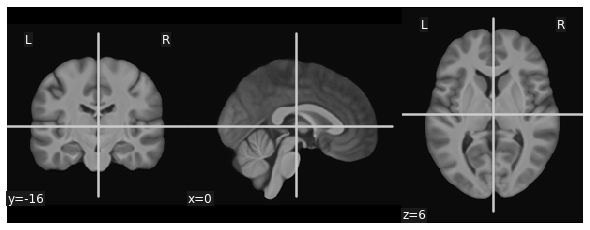

In [4]:
fig = plt.figure(figsize = (8,3))
plotting.plot_anat(anat_mean, black_bg = True, figure = fig)

### First level result

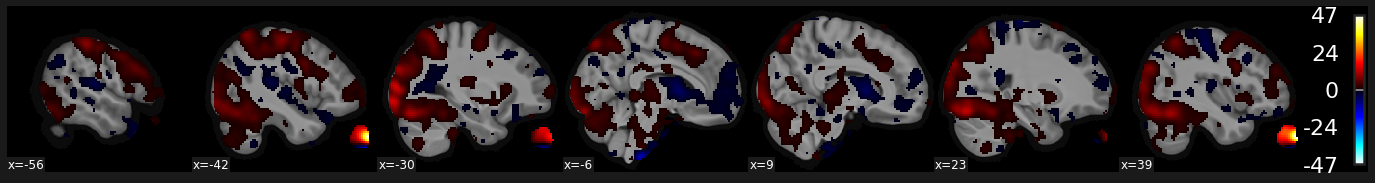

In [14]:
# contrast
con_id = '0002'
plotting.plot_stat_map('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_reward/1stLevel/_subject_id_2073/con_%s.nii' %con_id,
                       anat_mean,
                      threshold = 1,
                      display_mode = 'x')

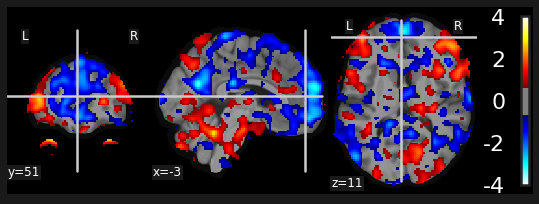

In [40]:
# t map
con_id = '0014'
plotting.plot_stat_map('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_reward/1stLevel/_subject_id_2073/spmT_%s.nii' %con_id,
                       anat_mean,
                      threshold = 0.7,
#                       display_mode = 'x',
                      )

### FDR thresholded <a class = "anchor" id = "fdr-bullet"></a>

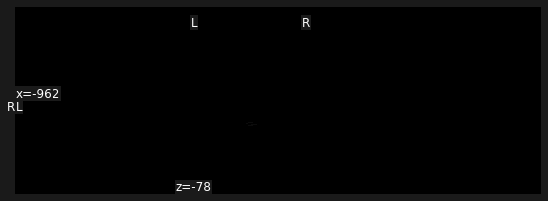

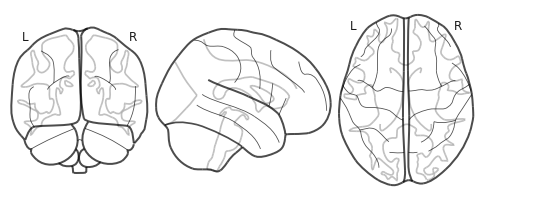

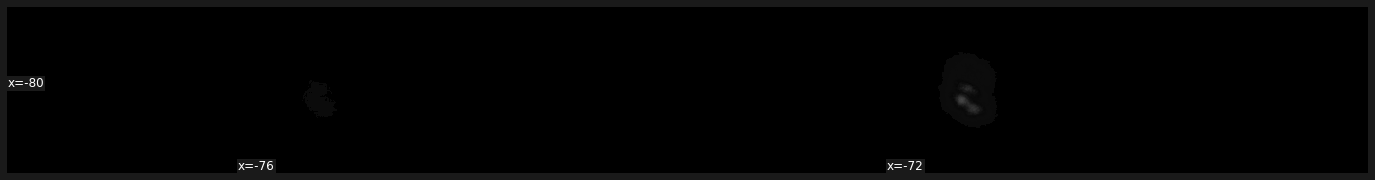

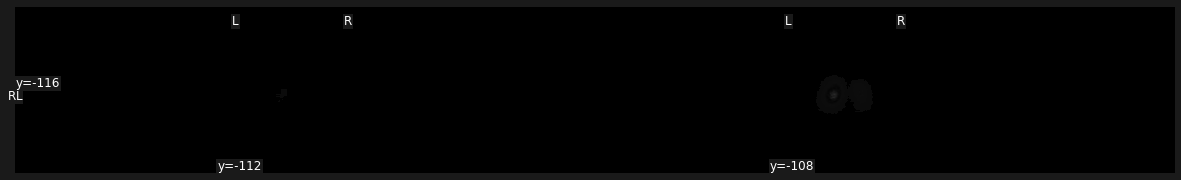

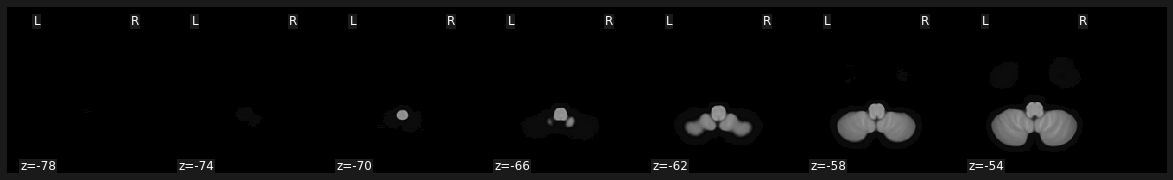

In [11]:
# second-level output: FDR corrected

con_id = '0007'
plotting.plot_stat_map('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_reward/2ndLevel_heightp05/_contrast_id_con_%s/spmT_0001_thr.nii' %con_id,
                       anat_mean)

plotting.plot_glass_brain('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_reward/2ndLevel_heightp05/_contrast_id_con_%s/spmT_0001_thr.nii' %con_id,
                       colorbar = True)

plotting.plot_stat_map('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_reward/2ndLevel_heightp05/_contrast_id_con_%s/spmT_0001_thr.nii' %con_id,
                       anat_mean,
                      display_mode = 'x')

plotting.plot_stat_map('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_reward/2ndLevel_heightp05/_contrast_id_con_%s/spmT_0001_thr.nii' %con_id,
                       anat_mean,
                      display_mode = 'y')

plotting.plot_stat_map('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_reward/2ndLevel_heightp05/_contrast_id_con_%s/spmT_0001_thr.nii' %con_id,
                       anat_mean,
                      display_mode = 'z')

## Voxel-size thresholding <a class = "anchor" id = "voxel-bullet"></a>

Without correction just voxel-wise threshold

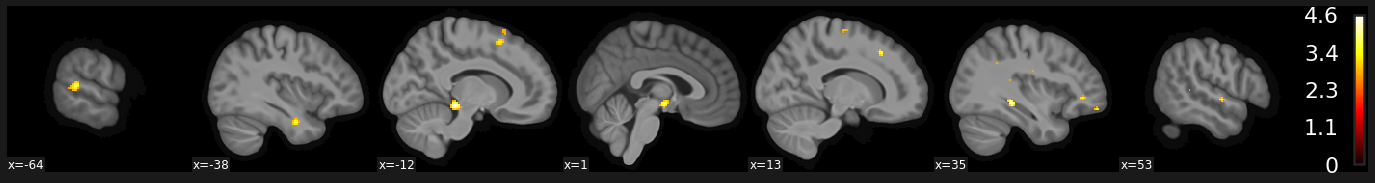

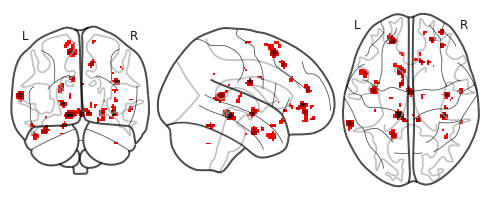

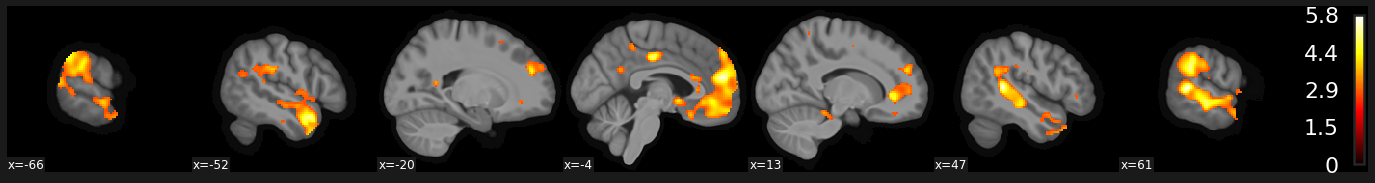

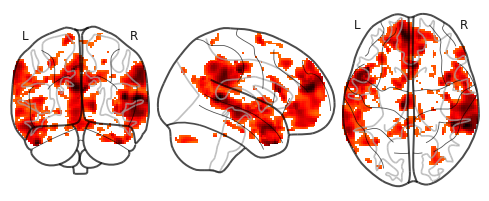

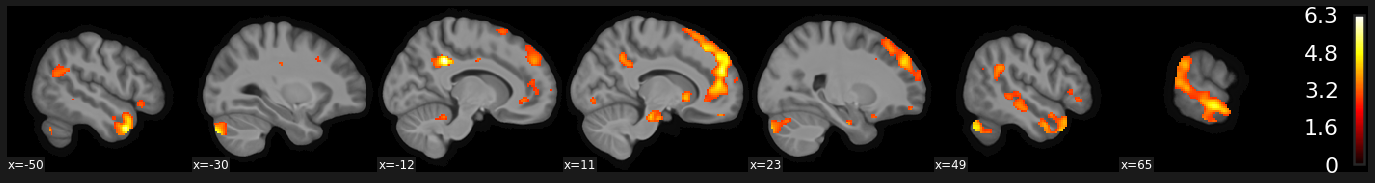

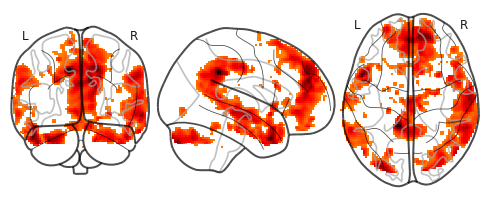

In [12]:
# voxel-wise p threshold
voxel_threshold = 0.005
con_ids = ['0005', '0006', '0007']

for con_id in con_ids:

    spm_thr = spm.Threshold(contrast_index=1,
                            spm_mat_file = os.path.join(out_root, 'imaging', 'Sink_resp_reward/2ndLevel_heightp05/_contrast_id_con_%s/SPM.mat' %con_id),
                            stat_image = os.path.join(out_root, 'imaging', 'Sink_resp_reward/2ndLevel_heightp05/_contrast_id_con_%s/spmT_0001.nii' %con_id),
                            use_topo_fdr=False,
                            use_fwe_correction=False, # here we can use fwe or fdr, default is true
    #                         extent_threshold=10,
                            height_threshold= voxel_threshold, # default is 0.05
    #                         extent_fdr_p_threshold = 0.05,
                            height_threshold_type='p-value', # default is p-value
                            )
    spm_thr.run()

    # plot 
    plotting.plot_stat_map('/home/rj299/project/mdm_analysis/mdm_imaging_analysis/spmT_0001_thr.nii',
                          bg_img = anat_mean,
                           display_mode = 'x')
    
    plotting.plot_glass_brain('/home/rj299/project/mdm_analysis/mdm_imaging_analysis/spmT_0001_thr.nii')
    # plotting.plot_stat_map('/home/rj299/scratch60/mdm_analysis/mdm_imaging_analysis/spmT_0001_pre_topo_thr.nii')

## Concatenate all subjects' contrast <a class = "anchor" id = "concat-bullet"></a>

In [ ]:
con_id = '0005'
con_filenames = ['/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_reward/1stLevel/_subject_id_*/con_%s.nii' %con_id]

con_all = {}

for i in sub_num:
    con_image = glob.glob('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_reward/1stLevel/_subject_id_' + str(i) + '/con_%s.nii' %con_id)
    con_all[str(i)] = list(con_image)
print(len(con_all))
con_all

In [ ]:
smooth_con_all = []

for k, v in con_all.items():
    smooth_con = image.smooth_img(v[0],None) #  If fwhm is None, no filtering is performed (useful when just removal of non-finite values is needed).
    print(v)
    smooth_con_all.append(smooth_con)
    
#     plotting.plot_glass_brain(smooth_con, colorbar = True)

In [21]:
# from nilearn import image
con_concat = image.concat_imgs(smooth_con_all, auto_resample = True)
con_concat.to_filename(os.path.join(out_root, 'imaging', 'Sink_resp_reward', 'reward_glm_con%s_all_sub.nii.gz' %con_id))

In [ ]:
# con_single = image.index_img(con_concat, 0)
# plotting.plot_glass_brain(con_single, colorbar = "w")

In [ ]:
# for con_single in image.iter_img(con_concat):
#     plotting.plot_glass_brain(con_single, display_mode = 'lyrz', colorbar = "w")

In [23]:
# flip sign for the Mon > Med contrast
smooth_con_flip_all = []

for smooth_img in smooth_con_all:
    smooth_img_flip = image.math_img("-img", img=smooth_img)
    smooth_con_flip_all.append(smooth_img_flip)
    
con_concat_flip = image.concat_imgs(smooth_con_flip_all, auto_resample = True)
con_concat_flip.to_filename(os.path.join(out_root, 'imaging', 'Sink_resp_reward', 'reward_glm_con%s_flip_all_sub.nii.gz' %con_id))

## Cluster extent <a class = "anchor" id = "cluster-bullet"></a>

In [31]:
# conduct cluster-extent thresholding
# voxel-wise p threshold
voxel_threshold = 0.001
con_ids = ['0005','0006','0007']

for con_id in con_ids:

    spm_thr = spm.Threshold(contrast_index=1,
                            spm_mat_file = os.path.join(out_root, 'imaging', 'Sink_resp_reward/2ndLevel_heightp05/_contrast_id_con_%s/SPM.mat' %con_id),
                            stat_image = os.path.join(out_root, 'imaging', 'Sink_resp_reward/2ndLevel_heightp05/_contrast_id_con_%s/spmT_0001.nii' %con_id),
                            use_topo_fdr=False,
                            use_fwe_correction=False, # here we can use fwe or fdr, default is true
    #                         extent_threshold=10,
                            height_threshold= voxel_threshold, # default is 0.05
    #                         extent_fdr_p_threshold = 0.05,
                            height_threshold_type='p-value', # default is p-value
                            )
    spm_thr.run()

    # find the critical p value for a certain threshold
    t = nib.load('/home/rj299/project/mdm_analysis/mdm_imaging_analysis/spmT_0001_thr.nii')
    t_data = t.get_data()
    t_data_mask = ~np.isnan(t_data)
    t_critical = np.min(t_data[t_data_mask])
    t_critical

    # cluster extent threshold, using the preivous t_critical for initial thresholing
    cluster_thr = fsl.Randomise(in_file = os.path.join(out_root, 'imaging', 'Sink_resp_reward', 'reward_glm_con%s_all_sub.nii.gz' %con_id),
                                mask = '/home/rj299/project/mdm_analysis/output/imaging/wb_mask_group.nii.gz',
                                base_name = os.path.join(out_root, 'imaging', 'Sink_resp_reward', 'con%s_p001' %con_id),
                                c_thresh = t_critical,
                                one_sample_group_mean = True,
                                tfce = False,
                                vox_p_values = True, 
    #                             raw_stats_imgs = True,
                                num_perm = 5000)
    cluster_thr.run()
    

200518-18:22:00,168 nipype.interface INFO:
	 stdout 2020-05-18T18:22:00.168144:randomise options: -i /home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_reward/reward_glm_con0005_all_sub.nii.gz -o /home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_reward/con0005_p001 -c 3.4 -m /home/rj299/project/mdm_analysis/output/imaging/wb_mask_group.nii.gz -n 5000 -1 -x 
200518-18:22:01,91 nipype.interface INFO:
	 stdout 2020-05-18T18:22:01.091622:Loading Data: 
200518-18:22:01,107 nipype.interface INFO:
	 stdout 2020-05-18T18:22:01.107068:Data loaded
200518-18:22:01,168 nipype.interface INFO:
	 stdout 2020-05-18T18:22:01.168172:One-sample design detected; sign-flipping instead of permuting.
200518-18:22:01,173 nipype.interface INFO:
	 stdout 2020-05-18T18:22:01.173217:8.58993e+09 sign-flips required for exhaustive test of t-test 1
200518-18:22:01,192 nipype.interface INFO:
	 stdout 2020-05-18T18:22:01.192539:Doing 5000 random permutations
200518-18:22:01,199 nipype.interface INFO

200518-18:22:12,142 nipype.interface INFO:
	 stdout 2020-05-18T18:22:12.142764:Starting permutation 72
200518-18:22:12,287 nipype.interface INFO:
	 stdout 2020-05-18T18:22:12.287020:Starting permutation 73
200518-18:22:12,424 nipype.interface INFO:
	 stdout 2020-05-18T18:22:12.424628:Starting permutation 74
200518-18:22:12,561 nipype.interface INFO:
	 stdout 2020-05-18T18:22:12.561291:Starting permutation 75
200518-18:22:12,758 nipype.interface INFO:
	 stdout 2020-05-18T18:22:12.758459:Starting permutation 76
200518-18:22:12,944 nipype.interface INFO:
	 stdout 2020-05-18T18:22:12.944371:Starting permutation 77
200518-18:22:13,102 nipype.interface INFO:
	 stdout 2020-05-18T18:22:13.102646:Starting permutation 78
200518-18:22:13,239 nipype.interface INFO:
	 stdout 2020-05-18T18:22:13.239600:Starting permutation 79
200518-18:22:13,401 nipype.interface INFO:
	 stdout 2020-05-18T18:22:13.401890:Starting permutation 80
200518-18:22:13,591 nipype.interface INFO:
	 stdout 2020-05-18T18:22:13.5

200518-18:22:24,878 nipype.interface INFO:
	 stdout 2020-05-18T18:22:24.878278:Starting permutation 152
200518-18:22:25,19 nipype.interface INFO:
	 stdout 2020-05-18T18:22:25.019698:Starting permutation 153
200518-18:22:25,158 nipype.interface INFO:
	 stdout 2020-05-18T18:22:25.158479:Starting permutation 154
200518-18:22:25,298 nipype.interface INFO:
	 stdout 2020-05-18T18:22:25.298224:Starting permutation 155
200518-18:22:25,437 nipype.interface INFO:
	 stdout 2020-05-18T18:22:25.437061:Starting permutation 156
200518-18:22:25,575 nipype.interface INFO:
	 stdout 2020-05-18T18:22:25.575270:Starting permutation 157
200518-18:22:25,715 nipype.interface INFO:
	 stdout 2020-05-18T18:22:25.715038:Starting permutation 158
200518-18:22:25,854 nipype.interface INFO:
	 stdout 2020-05-18T18:22:25.854923:Starting permutation 159
200518-18:22:25,994 nipype.interface INFO:
	 stdout 2020-05-18T18:22:25.994419:Starting permutation 160
200518-18:22:26,133 nipype.interface INFO:
	 stdout 2020-05-18T18

200518-18:22:36,443 nipype.interface INFO:
	 stdout 2020-05-18T18:22:36.443696:Starting permutation 231
200518-18:22:36,583 nipype.interface INFO:
	 stdout 2020-05-18T18:22:36.583744:Starting permutation 232
200518-18:22:36,741 nipype.interface INFO:
	 stdout 2020-05-18T18:22:36.741422:Starting permutation 233
200518-18:22:36,880 nipype.interface INFO:
	 stdout 2020-05-18T18:22:36.880023:Starting permutation 234
200518-18:22:37,18 nipype.interface INFO:
	 stdout 2020-05-18T18:22:37.018564:Starting permutation 235
200518-18:22:37,157 nipype.interface INFO:
	 stdout 2020-05-18T18:22:37.157459:Starting permutation 236
200518-18:22:37,296 nipype.interface INFO:
	 stdout 2020-05-18T18:22:37.296413:Starting permutation 237
200518-18:22:37,434 nipype.interface INFO:
	 stdout 2020-05-18T18:22:37.434034:Starting permutation 238
200518-18:22:37,575 nipype.interface INFO:
	 stdout 2020-05-18T18:22:37.575502:Starting permutation 239
200518-18:22:37,712 nipype.interface INFO:
	 stdout 2020-05-18T18

200518-18:22:47,456 nipype.interface INFO:
	 stdout 2020-05-18T18:22:47.456932:Starting permutation 310
200518-18:22:47,595 nipype.interface INFO:
	 stdout 2020-05-18T18:22:47.595945:Starting permutation 311
200518-18:22:47,732 nipype.interface INFO:
	 stdout 2020-05-18T18:22:47.732803:Starting permutation 312
200518-18:22:47,870 nipype.interface INFO:
	 stdout 2020-05-18T18:22:47.870313:Starting permutation 313
200518-18:22:48,8 nipype.interface INFO:
	 stdout 2020-05-18T18:22:48.008758:Starting permutation 314
200518-18:22:48,146 nipype.interface INFO:
	 stdout 2020-05-18T18:22:48.146765:Starting permutation 315
200518-18:22:48,284 nipype.interface INFO:
	 stdout 2020-05-18T18:22:48.284049:Starting permutation 316
200518-18:22:48,421 nipype.interface INFO:
	 stdout 2020-05-18T18:22:48.421124:Starting permutation 317
200518-18:22:48,559 nipype.interface INFO:
	 stdout 2020-05-18T18:22:48.559099:Starting permutation 318
200518-18:22:48,827 nipype.interface INFO:
	 stdout 2020-05-18T18:

200518-18:22:58,919 nipype.interface INFO:
	 stdout 2020-05-18T18:22:58.919288:Starting permutation 389
200518-18:22:59,59 nipype.interface INFO:
	 stdout 2020-05-18T18:22:59.059850:Starting permutation 390
200518-18:22:59,197 nipype.interface INFO:
	 stdout 2020-05-18T18:22:59.197200:Starting permutation 391
200518-18:22:59,335 nipype.interface INFO:
	 stdout 2020-05-18T18:22:59.335077:Starting permutation 392
200518-18:22:59,472 nipype.interface INFO:
	 stdout 2020-05-18T18:22:59.472252:Starting permutation 393
200518-18:22:59,610 nipype.interface INFO:
	 stdout 2020-05-18T18:22:59.610363:Starting permutation 394
200518-18:22:59,748 nipype.interface INFO:
	 stdout 2020-05-18T18:22:59.748674:Starting permutation 395
200518-18:22:59,886 nipype.interface INFO:
	 stdout 2020-05-18T18:22:59.886526:Starting permutation 396
200518-18:23:00,23 nipype.interface INFO:
	 stdout 2020-05-18T18:23:00.023720:Starting permutation 397
200518-18:23:00,171 nipype.interface INFO:
	 stdout 2020-05-18T18:

200518-18:23:10,763 nipype.interface INFO:
	 stdout 2020-05-18T18:23:10.763750:Starting permutation 468
200518-18:23:10,907 nipype.interface INFO:
	 stdout 2020-05-18T18:23:10.907059:Starting permutation 469
200518-18:23:11,47 nipype.interface INFO:
	 stdout 2020-05-18T18:23:11.047193:Starting permutation 470
200518-18:23:11,187 nipype.interface INFO:
	 stdout 2020-05-18T18:23:11.187483:Starting permutation 471
200518-18:23:11,357 nipype.interface INFO:
	 stdout 2020-05-18T18:23:11.357737:Starting permutation 472
200518-18:23:11,503 nipype.interface INFO:
	 stdout 2020-05-18T18:23:11.503036:Starting permutation 473
200518-18:23:11,693 nipype.interface INFO:
	 stdout 2020-05-18T18:23:11.693099:Starting permutation 474
200518-18:23:11,832 nipype.interface INFO:
	 stdout 2020-05-18T18:23:11.832210:Starting permutation 475
200518-18:23:11,974 nipype.interface INFO:
	 stdout 2020-05-18T18:23:11.974873:Starting permutation 476
200518-18:23:12,116 nipype.interface INFO:
	 stdout 2020-05-18T18

200518-18:23:22,384 nipype.interface INFO:
	 stdout 2020-05-18T18:23:22.384004:Starting permutation 547
200518-18:23:22,525 nipype.interface INFO:
	 stdout 2020-05-18T18:23:22.525449:Starting permutation 548
200518-18:23:22,665 nipype.interface INFO:
	 stdout 2020-05-18T18:23:22.665205:Starting permutation 549
200518-18:23:22,805 nipype.interface INFO:
	 stdout 2020-05-18T18:23:22.805888:Starting permutation 550
200518-18:23:22,947 nipype.interface INFO:
	 stdout 2020-05-18T18:23:22.947557:Starting permutation 551
200518-18:23:23,88 nipype.interface INFO:
	 stdout 2020-05-18T18:23:23.088476:Starting permutation 552
200518-18:23:23,229 nipype.interface INFO:
	 stdout 2020-05-18T18:23:23.229468:Starting permutation 553
200518-18:23:23,371 nipype.interface INFO:
	 stdout 2020-05-18T18:23:23.371281:Starting permutation 554
200518-18:23:23,514 nipype.interface INFO:
	 stdout 2020-05-18T18:23:23.514826:Starting permutation 555
200518-18:23:23,668 nipype.interface INFO:
	 stdout 2020-05-18T18

200518-18:23:34,40 nipype.interface INFO:
	 stdout 2020-05-18T18:23:34.039966:Starting permutation 626
200518-18:23:34,180 nipype.interface INFO:
	 stdout 2020-05-18T18:23:34.180677:Starting permutation 627
200518-18:23:34,320 nipype.interface INFO:
	 stdout 2020-05-18T18:23:34.320086:Starting permutation 628
200518-18:23:34,460 nipype.interface INFO:
	 stdout 2020-05-18T18:23:34.460816:Starting permutation 629
200518-18:23:34,601 nipype.interface INFO:
	 stdout 2020-05-18T18:23:34.601163:Starting permutation 630
200518-18:23:34,741 nipype.interface INFO:
	 stdout 2020-05-18T18:23:34.740970:Starting permutation 631
200518-18:23:34,880 nipype.interface INFO:
	 stdout 2020-05-18T18:23:34.880381:Starting permutation 632
200518-18:23:35,21 nipype.interface INFO:
	 stdout 2020-05-18T18:23:35.021195:Starting permutation 633
200518-18:23:35,161 nipype.interface INFO:
	 stdout 2020-05-18T18:23:35.161466:Starting permutation 634
200518-18:23:35,302 nipype.interface INFO:
	 stdout 2020-05-18T18:

200518-18:23:45,213 nipype.interface INFO:
	 stdout 2020-05-18T18:23:45.213903:Starting permutation 705
200518-18:23:45,354 nipype.interface INFO:
	 stdout 2020-05-18T18:23:45.354855:Starting permutation 706
200518-18:23:45,494 nipype.interface INFO:
	 stdout 2020-05-18T18:23:45.494475:Starting permutation 707
200518-18:23:45,634 nipype.interface INFO:
	 stdout 2020-05-18T18:23:45.634881:Starting permutation 708
200518-18:23:45,775 nipype.interface INFO:
	 stdout 2020-05-18T18:23:45.775545:Starting permutation 709
200518-18:23:45,916 nipype.interface INFO:
	 stdout 2020-05-18T18:23:45.916226:Starting permutation 710
200518-18:23:46,60 nipype.interface INFO:
	 stdout 2020-05-18T18:23:46.060315:Starting permutation 711
200518-18:23:46,199 nipype.interface INFO:
	 stdout 2020-05-18T18:23:46.199779:Starting permutation 712
200518-18:23:46,340 nipype.interface INFO:
	 stdout 2020-05-18T18:23:46.340004:Starting permutation 713
200518-18:23:46,479 nipype.interface INFO:
	 stdout 2020-05-18T18

200518-18:23:56,838 nipype.interface INFO:
	 stdout 2020-05-18T18:23:56.838249:Starting permutation 784
200518-18:23:56,979 nipype.interface INFO:
	 stdout 2020-05-18T18:23:56.979012:Starting permutation 785
200518-18:23:57,118 nipype.interface INFO:
	 stdout 2020-05-18T18:23:57.118739:Starting permutation 786
200518-18:23:57,257 nipype.interface INFO:
	 stdout 2020-05-18T18:23:57.257719:Starting permutation 787
200518-18:23:57,400 nipype.interface INFO:
	 stdout 2020-05-18T18:23:57.400383:Starting permutation 788
200518-18:23:57,540 nipype.interface INFO:
	 stdout 2020-05-18T18:23:57.540078:Starting permutation 789
200518-18:23:57,679 nipype.interface INFO:
	 stdout 2020-05-18T18:23:57.679882:Starting permutation 790
200518-18:23:57,819 nipype.interface INFO:
	 stdout 2020-05-18T18:23:57.819797:Starting permutation 791
200518-18:23:57,959 nipype.interface INFO:
	 stdout 2020-05-18T18:23:57.959719:Starting permutation 792
200518-18:23:58,99 nipype.interface INFO:
	 stdout 2020-05-18T18

200518-18:24:08,35 nipype.interface INFO:
	 stdout 2020-05-18T18:24:08.035837:Starting permutation 863
200518-18:24:08,178 nipype.interface INFO:
	 stdout 2020-05-18T18:24:08.178005:Starting permutation 864
200518-18:24:08,317 nipype.interface INFO:
	 stdout 2020-05-18T18:24:08.317059:Starting permutation 865
200518-18:24:08,458 nipype.interface INFO:
	 stdout 2020-05-18T18:24:08.458029:Starting permutation 866
200518-18:24:08,598 nipype.interface INFO:
	 stdout 2020-05-18T18:24:08.598158:Starting permutation 867
200518-18:24:08,908 nipype.interface INFO:
	 stdout 2020-05-18T18:24:08.908800:Starting permutation 868
200518-18:24:09,110 nipype.interface INFO:
	 stdout 2020-05-18T18:24:09.110680:Starting permutation 869
200518-18:24:09,295 nipype.interface INFO:
	 stdout 2020-05-18T18:24:09.295124:Starting permutation 870
200518-18:24:09,529 nipype.interface INFO:
	 stdout 2020-05-18T18:24:09.529137:Starting permutation 871
200518-18:24:09,669 nipype.interface INFO:
	 stdout 2020-05-18T18

200518-18:24:19,648 nipype.interface INFO:
	 stdout 2020-05-18T18:24:19.648571:Starting permutation 942
200518-18:24:19,790 nipype.interface INFO:
	 stdout 2020-05-18T18:24:19.790163:Starting permutation 943
200518-18:24:19,931 nipype.interface INFO:
	 stdout 2020-05-18T18:24:19.931146:Starting permutation 944
200518-18:24:20,71 nipype.interface INFO:
	 stdout 2020-05-18T18:24:20.071912:Starting permutation 945
200518-18:24:20,212 nipype.interface INFO:
	 stdout 2020-05-18T18:24:20.211953:Starting permutation 946
200518-18:24:20,352 nipype.interface INFO:
	 stdout 2020-05-18T18:24:20.352422:Starting permutation 947
200518-18:24:20,494 nipype.interface INFO:
	 stdout 2020-05-18T18:24:20.493963:Starting permutation 948
200518-18:24:20,634 nipype.interface INFO:
	 stdout 2020-05-18T18:24:20.634689:Starting permutation 949
200518-18:24:20,775 nipype.interface INFO:
	 stdout 2020-05-18T18:24:20.775716:Starting permutation 950
200518-18:24:20,915 nipype.interface INFO:
	 stdout 2020-05-18T18

200518-18:24:31,209 nipype.interface INFO:
	 stdout 2020-05-18T18:24:31.209866:Starting permutation 1021
200518-18:24:31,351 nipype.interface INFO:
	 stdout 2020-05-18T18:24:31.350943:Starting permutation 1022
200518-18:24:31,550 nipype.interface INFO:
	 stdout 2020-05-18T18:24:31.550389:Starting permutation 1023
200518-18:24:31,700 nipype.interface INFO:
	 stdout 2020-05-18T18:24:31.700651:Starting permutation 1024
200518-18:24:31,841 nipype.interface INFO:
	 stdout 2020-05-18T18:24:31.841511:Starting permutation 1025
200518-18:24:31,981 nipype.interface INFO:
	 stdout 2020-05-18T18:24:31.981014:Starting permutation 1026
200518-18:24:32,121 nipype.interface INFO:
	 stdout 2020-05-18T18:24:32.121501:Starting permutation 1027
200518-18:24:32,260 nipype.interface INFO:
	 stdout 2020-05-18T18:24:32.260746:Starting permutation 1028
200518-18:24:32,405 nipype.interface INFO:
	 stdout 2020-05-18T18:24:32.405825:Starting permutation 1029
200518-18:24:32,547 nipype.interface INFO:
	 stdout 202

200518-18:24:42,472 nipype.interface INFO:
	 stdout 2020-05-18T18:24:42.472193:Starting permutation 1100
200518-18:24:42,613 nipype.interface INFO:
	 stdout 2020-05-18T18:24:42.613005:Starting permutation 1101
200518-18:24:42,752 nipype.interface INFO:
	 stdout 2020-05-18T18:24:42.752569:Starting permutation 1102
200518-18:24:42,892 nipype.interface INFO:
	 stdout 2020-05-18T18:24:42.892881:Starting permutation 1103
200518-18:24:43,32 nipype.interface INFO:
	 stdout 2020-05-18T18:24:43.032777:Starting permutation 1104
200518-18:24:43,174 nipype.interface INFO:
	 stdout 2020-05-18T18:24:43.173990:Starting permutation 1105
200518-18:24:43,314 nipype.interface INFO:
	 stdout 2020-05-18T18:24:43.314494:Starting permutation 1106
200518-18:24:43,453 nipype.interface INFO:
	 stdout 2020-05-18T18:24:43.453806:Starting permutation 1107
200518-18:24:43,593 nipype.interface INFO:
	 stdout 2020-05-18T18:24:43.593451:Starting permutation 1108
200518-18:24:43,734 nipype.interface INFO:
	 stdout 2020

200518-18:24:54,125 nipype.interface INFO:
	 stdout 2020-05-18T18:24:54.125187:Starting permutation 1179
200518-18:24:54,266 nipype.interface INFO:
	 stdout 2020-05-18T18:24:54.266862:Starting permutation 1180
200518-18:24:54,407 nipype.interface INFO:
	 stdout 2020-05-18T18:24:54.407153:Starting permutation 1181
200518-18:24:54,546 nipype.interface INFO:
	 stdout 2020-05-18T18:24:54.546906:Starting permutation 1182
200518-18:24:54,687 nipype.interface INFO:
	 stdout 2020-05-18T18:24:54.687029:Starting permutation 1183
200518-18:24:54,827 nipype.interface INFO:
	 stdout 2020-05-18T18:24:54.826990:Starting permutation 1184
200518-18:24:54,966 nipype.interface INFO:
	 stdout 2020-05-18T18:24:54.966438:Starting permutation 1185
200518-18:24:55,106 nipype.interface INFO:
	 stdout 2020-05-18T18:24:55.106852:Starting permutation 1186
200518-18:24:55,247 nipype.interface INFO:
	 stdout 2020-05-18T18:24:55.247036:Starting permutation 1187
200518-18:24:55,387 nipype.interface INFO:
	 stdout 202

200518-18:25:05,302 nipype.interface INFO:
	 stdout 2020-05-18T18:25:05.302355:Starting permutation 1258
200518-18:25:05,443 nipype.interface INFO:
	 stdout 2020-05-18T18:25:05.443650:Starting permutation 1259
200518-18:25:05,583 nipype.interface INFO:
	 stdout 2020-05-18T18:25:05.583758:Starting permutation 1260
200518-18:25:05,724 nipype.interface INFO:
	 stdout 2020-05-18T18:25:05.724260:Starting permutation 1261
200518-18:25:05,865 nipype.interface INFO:
	 stdout 2020-05-18T18:25:05.865264:Starting permutation 1262
200518-18:25:06,5 nipype.interface INFO:
	 stdout 2020-05-18T18:25:06.005674:Starting permutation 1263
200518-18:25:06,146 nipype.interface INFO:
	 stdout 2020-05-18T18:25:06.146332:Starting permutation 1264
200518-18:25:06,286 nipype.interface INFO:
	 stdout 2020-05-18T18:25:06.286705:Starting permutation 1265
200518-18:25:06,427 nipype.interface INFO:
	 stdout 2020-05-18T18:25:06.427193:Starting permutation 1266
200518-18:25:06,568 nipype.interface INFO:
	 stdout 2020-

200518-18:25:16,977 nipype.interface INFO:
	 stdout 2020-05-18T18:25:16.977008:Starting permutation 1337
200518-18:25:17,117 nipype.interface INFO:
	 stdout 2020-05-18T18:25:17.117217:Starting permutation 1338
200518-18:25:17,256 nipype.interface INFO:
	 stdout 2020-05-18T18:25:17.256574:Starting permutation 1339
200518-18:25:17,399 nipype.interface INFO:
	 stdout 2020-05-18T18:25:17.399159:Starting permutation 1340
200518-18:25:17,538 nipype.interface INFO:
	 stdout 2020-05-18T18:25:17.538410:Starting permutation 1341
200518-18:25:17,677 nipype.interface INFO:
	 stdout 2020-05-18T18:25:17.677828:Starting permutation 1342
200518-18:25:17,818 nipype.interface INFO:
	 stdout 2020-05-18T18:25:17.818824:Starting permutation 1343
200518-18:25:17,958 nipype.interface INFO:
	 stdout 2020-05-18T18:25:17.958174:Starting permutation 1344
200518-18:25:18,97 nipype.interface INFO:
	 stdout 2020-05-18T18:25:18.097625:Starting permutation 1345
200518-18:25:18,237 nipype.interface INFO:
	 stdout 2020

200518-18:25:28,146 nipype.interface INFO:
	 stdout 2020-05-18T18:25:28.146273:Starting permutation 1416
200518-18:25:28,287 nipype.interface INFO:
	 stdout 2020-05-18T18:25:28.287145:Starting permutation 1417
200518-18:25:28,426 nipype.interface INFO:
	 stdout 2020-05-18T18:25:28.426825:Starting permutation 1418
200518-18:25:28,565 nipype.interface INFO:
	 stdout 2020-05-18T18:25:28.565702:Starting permutation 1419
200518-18:25:28,848 nipype.interface INFO:
	 stdout 2020-05-18T18:25:28.847981:Starting permutation 1420
200518-18:25:29,79 nipype.interface INFO:
	 stdout 2020-05-18T18:25:29.079438:Starting permutation 1421
200518-18:25:29,252 nipype.interface INFO:
	 stdout 2020-05-18T18:25:29.252312:Starting permutation 1422
200518-18:25:29,522 nipype.interface INFO:
	 stdout 2020-05-18T18:25:29.522813:Starting permutation 1423
200518-18:25:29,662 nipype.interface INFO:
	 stdout 2020-05-18T18:25:29.662898:Starting permutation 1424
200518-18:25:29,802 nipype.interface INFO:
	 stdout 2020

200518-18:25:39,818 nipype.interface INFO:
	 stdout 2020-05-18T18:25:39.818648:Starting permutation 1495
200518-18:25:39,970 nipype.interface INFO:
	 stdout 2020-05-18T18:25:39.970415:Starting permutation 1496
200518-18:25:40,110 nipype.interface INFO:
	 stdout 2020-05-18T18:25:40.110814:Starting permutation 1497
200518-18:25:40,252 nipype.interface INFO:
	 stdout 2020-05-18T18:25:40.252586:Starting permutation 1498
200518-18:25:40,393 nipype.interface INFO:
	 stdout 2020-05-18T18:25:40.393063:Starting permutation 1499
200518-18:25:40,533 nipype.interface INFO:
	 stdout 2020-05-18T18:25:40.533467:Starting permutation 1500
200518-18:25:40,674 nipype.interface INFO:
	 stdout 2020-05-18T18:25:40.674159:Starting permutation 1501
200518-18:25:40,815 nipype.interface INFO:
	 stdout 2020-05-18T18:25:40.815693:Starting permutation 1502
200518-18:25:40,955 nipype.interface INFO:
	 stdout 2020-05-18T18:25:40.955466:Starting permutation 1503
200518-18:25:41,96 nipype.interface INFO:
	 stdout 2020

200518-18:25:51,363 nipype.interface INFO:
	 stdout 2020-05-18T18:25:51.363524:Starting permutation 1574
200518-18:25:51,550 nipype.interface INFO:
	 stdout 2020-05-18T18:25:51.550040:Starting permutation 1575
200518-18:25:51,690 nipype.interface INFO:
	 stdout 2020-05-18T18:25:51.690707:Starting permutation 1576
200518-18:25:51,837 nipype.interface INFO:
	 stdout 2020-05-18T18:25:51.837539:Starting permutation 1577
200518-18:25:51,977 nipype.interface INFO:
	 stdout 2020-05-18T18:25:51.977237:Starting permutation 1578
200518-18:25:52,117 nipype.interface INFO:
	 stdout 2020-05-18T18:25:52.117390:Starting permutation 1579
200518-18:25:52,258 nipype.interface INFO:
	 stdout 2020-05-18T18:25:52.258012:Starting permutation 1580
200518-18:25:52,404 nipype.interface INFO:
	 stdout 2020-05-18T18:25:52.404136:Starting permutation 1581
200518-18:25:52,546 nipype.interface INFO:
	 stdout 2020-05-18T18:25:52.546628:Starting permutation 1582
200518-18:25:52,688 nipype.interface INFO:
	 stdout 202

200518-18:26:02,691 nipype.interface INFO:
	 stdout 2020-05-18T18:26:02.690977:Starting permutation 1653
200518-18:26:02,831 nipype.interface INFO:
	 stdout 2020-05-18T18:26:02.831700:Starting permutation 1654
200518-18:26:02,971 nipype.interface INFO:
	 stdout 2020-05-18T18:26:02.971152:Starting permutation 1655
200518-18:26:03,110 nipype.interface INFO:
	 stdout 2020-05-18T18:26:03.110530:Starting permutation 1656
200518-18:26:03,251 nipype.interface INFO:
	 stdout 2020-05-18T18:26:03.251220:Starting permutation 1657
200518-18:26:03,390 nipype.interface INFO:
	 stdout 2020-05-18T18:26:03.390638:Starting permutation 1658
200518-18:26:03,530 nipype.interface INFO:
	 stdout 2020-05-18T18:26:03.530886:Starting permutation 1659
200518-18:26:03,670 nipype.interface INFO:
	 stdout 2020-05-18T18:26:03.670485:Starting permutation 1660
200518-18:26:03,810 nipype.interface INFO:
	 stdout 2020-05-18T18:26:03.810190:Starting permutation 1661
200518-18:26:03,949 nipype.interface INFO:
	 stdout 202

200518-18:26:14,309 nipype.interface INFO:
	 stdout 2020-05-18T18:26:14.309423:Starting permutation 1732
200518-18:26:14,451 nipype.interface INFO:
	 stdout 2020-05-18T18:26:14.451392:Starting permutation 1733
200518-18:26:14,591 nipype.interface INFO:
	 stdout 2020-05-18T18:26:14.591418:Starting permutation 1734
200518-18:26:14,731 nipype.interface INFO:
	 stdout 2020-05-18T18:26:14.731896:Starting permutation 1735
200518-18:26:14,872 nipype.interface INFO:
	 stdout 2020-05-18T18:26:14.872263:Starting permutation 1736
200518-18:26:15,12 nipype.interface INFO:
	 stdout 2020-05-18T18:26:15.012026:Starting permutation 1737
200518-18:26:15,153 nipype.interface INFO:
	 stdout 2020-05-18T18:26:15.153521:Starting permutation 1738
200518-18:26:15,294 nipype.interface INFO:
	 stdout 2020-05-18T18:26:15.294256:Starting permutation 1739
200518-18:26:15,434 nipype.interface INFO:
	 stdout 2020-05-18T18:26:15.434704:Starting permutation 1740
200518-18:26:15,574 nipype.interface INFO:
	 stdout 2020

200518-18:26:25,514 nipype.interface INFO:
	 stdout 2020-05-18T18:26:25.514766:Starting permutation 1811
200518-18:26:25,657 nipype.interface INFO:
	 stdout 2020-05-18T18:26:25.657905:Starting permutation 1812
200518-18:26:25,797 nipype.interface INFO:
	 stdout 2020-05-18T18:26:25.797772:Starting permutation 1813
200518-18:26:25,938 nipype.interface INFO:
	 stdout 2020-05-18T18:26:25.938131:Starting permutation 1814
200518-18:26:26,78 nipype.interface INFO:
	 stdout 2020-05-18T18:26:26.078295:Starting permutation 1815
200518-18:26:26,218 nipype.interface INFO:
	 stdout 2020-05-18T18:26:26.218332:Starting permutation 1816
200518-18:26:26,358 nipype.interface INFO:
	 stdout 2020-05-18T18:26:26.358832:Starting permutation 1817
200518-18:26:26,500 nipype.interface INFO:
	 stdout 2020-05-18T18:26:26.500217:Starting permutation 1818
200518-18:26:26,640 nipype.interface INFO:
	 stdout 2020-05-18T18:26:26.640464:Starting permutation 1819
200518-18:26:26,781 nipype.interface INFO:
	 stdout 2020

200518-18:26:38,367 nipype.interface INFO:
	 stdout 2020-05-18T18:26:38.367310:Starting permutation 1890
200518-18:26:38,509 nipype.interface INFO:
	 stdout 2020-05-18T18:26:38.509618:Starting permutation 1891
200518-18:26:38,650 nipype.interface INFO:
	 stdout 2020-05-18T18:26:38.650212:Starting permutation 1892
200518-18:26:38,790 nipype.interface INFO:
	 stdout 2020-05-18T18:26:38.790279:Starting permutation 1893
200518-18:26:38,931 nipype.interface INFO:
	 stdout 2020-05-18T18:26:38.931815:Starting permutation 1894
200518-18:26:39,72 nipype.interface INFO:
	 stdout 2020-05-18T18:26:39.071983:Starting permutation 1895
200518-18:26:39,211 nipype.interface INFO:
	 stdout 2020-05-18T18:26:39.211770:Starting permutation 1896
200518-18:26:39,352 nipype.interface INFO:
	 stdout 2020-05-18T18:26:39.352582:Starting permutation 1897
200518-18:26:39,492 nipype.interface INFO:
	 stdout 2020-05-18T18:26:39.492615:Starting permutation 1898
200518-18:26:39,633 nipype.interface INFO:
	 stdout 2020

200518-18:26:49,956 nipype.interface INFO:
	 stdout 2020-05-18T18:26:49.956369:Starting permutation 1969
200518-18:26:50,97 nipype.interface INFO:
	 stdout 2020-05-18T18:26:50.097257:Starting permutation 1970
200518-18:26:50,237 nipype.interface INFO:
	 stdout 2020-05-18T18:26:50.237179:Starting permutation 1971
200518-18:26:50,377 nipype.interface INFO:
	 stdout 2020-05-18T18:26:50.377449:Starting permutation 1972
200518-18:26:50,521 nipype.interface INFO:
	 stdout 2020-05-18T18:26:50.521115:Starting permutation 1973
200518-18:26:50,661 nipype.interface INFO:
	 stdout 2020-05-18T18:26:50.661503:Starting permutation 1974
200518-18:26:50,801 nipype.interface INFO:
	 stdout 2020-05-18T18:26:50.801368:Starting permutation 1975
200518-18:26:50,942 nipype.interface INFO:
	 stdout 2020-05-18T18:26:50.942737:Starting permutation 1976
200518-18:26:51,83 nipype.interface INFO:
	 stdout 2020-05-18T18:26:51.083329:Starting permutation 1977
200518-18:26:51,223 nipype.interface INFO:
	 stdout 2020-

200518-18:27:01,235 nipype.interface INFO:
	 stdout 2020-05-18T18:27:01.235812:Starting permutation 2048
200518-18:27:01,377 nipype.interface INFO:
	 stdout 2020-05-18T18:27:01.377176:Starting permutation 2049
200518-18:27:01,517 nipype.interface INFO:
	 stdout 2020-05-18T18:27:01.517561:Starting permutation 2050
200518-18:27:01,657 nipype.interface INFO:
	 stdout 2020-05-18T18:27:01.657355:Starting permutation 2051
200518-18:27:01,797 nipype.interface INFO:
	 stdout 2020-05-18T18:27:01.797591:Starting permutation 2052
200518-18:27:01,937 nipype.interface INFO:
	 stdout 2020-05-18T18:27:01.937197:Starting permutation 2053
200518-18:27:02,77 nipype.interface INFO:
	 stdout 2020-05-18T18:27:02.077696:Starting permutation 2054
200518-18:27:02,218 nipype.interface INFO:
	 stdout 2020-05-18T18:27:02.218259:Starting permutation 2055
200518-18:27:02,359 nipype.interface INFO:
	 stdout 2020-05-18T18:27:02.359063:Starting permutation 2056
200518-18:27:02,499 nipype.interface INFO:
	 stdout 2020

200518-18:27:12,889 nipype.interface INFO:
	 stdout 2020-05-18T18:27:12.889018:Starting permutation 2127
200518-18:27:13,30 nipype.interface INFO:
	 stdout 2020-05-18T18:27:13.030146:Starting permutation 2128
200518-18:27:13,170 nipype.interface INFO:
	 stdout 2020-05-18T18:27:13.170003:Starting permutation 2129
200518-18:27:13,309 nipype.interface INFO:
	 stdout 2020-05-18T18:27:13.309530:Starting permutation 2130
200518-18:27:13,450 nipype.interface INFO:
	 stdout 2020-05-18T18:27:13.450806:Starting permutation 2131
200518-18:27:13,591 nipype.interface INFO:
	 stdout 2020-05-18T18:27:13.591354:Starting permutation 2132
200518-18:27:13,732 nipype.interface INFO:
	 stdout 2020-05-18T18:27:13.732472:Starting permutation 2133
200518-18:27:13,872 nipype.interface INFO:
	 stdout 2020-05-18T18:27:13.872627:Starting permutation 2134
200518-18:27:14,13 nipype.interface INFO:
	 stdout 2020-05-18T18:27:14.013673:Starting permutation 2135
200518-18:27:14,154 nipype.interface INFO:
	 stdout 2020-

200518-18:27:24,69 nipype.interface INFO:
	 stdout 2020-05-18T18:27:24.069726:Starting permutation 2206
200518-18:27:24,209 nipype.interface INFO:
	 stdout 2020-05-18T18:27:24.209800:Starting permutation 2207
200518-18:27:24,350 nipype.interface INFO:
	 stdout 2020-05-18T18:27:24.350239:Starting permutation 2208
200518-18:27:24,490 nipype.interface INFO:
	 stdout 2020-05-18T18:27:24.490290:Starting permutation 2209
200518-18:27:24,630 nipype.interface INFO:
	 stdout 2020-05-18T18:27:24.630326:Starting permutation 2210
200518-18:27:24,770 nipype.interface INFO:
	 stdout 2020-05-18T18:27:24.770140:Starting permutation 2211
200518-18:27:24,910 nipype.interface INFO:
	 stdout 2020-05-18T18:27:24.910533:Starting permutation 2212
200518-18:27:25,50 nipype.interface INFO:
	 stdout 2020-05-18T18:27:25.050366:Starting permutation 2213
200518-18:27:25,190 nipype.interface INFO:
	 stdout 2020-05-18T18:27:25.190172:Starting permutation 2214
200518-18:27:25,330 nipype.interface INFO:
	 stdout 2020-

200518-18:27:35,703 nipype.interface INFO:
	 stdout 2020-05-18T18:27:35.703692:Starting permutation 2285
200518-18:27:35,844 nipype.interface INFO:
	 stdout 2020-05-18T18:27:35.844395:Starting permutation 2286
200518-18:27:35,984 nipype.interface INFO:
	 stdout 2020-05-18T18:27:35.984535:Starting permutation 2287
200518-18:27:36,124 nipype.interface INFO:
	 stdout 2020-05-18T18:27:36.124039:Starting permutation 2288
200518-18:27:36,262 nipype.interface INFO:
	 stdout 2020-05-18T18:27:36.262516:Starting permutation 2289
200518-18:27:36,401 nipype.interface INFO:
	 stdout 2020-05-18T18:27:36.401907:Starting permutation 2290
200518-18:27:36,541 nipype.interface INFO:
	 stdout 2020-05-18T18:27:36.540965:Starting permutation 2291
200518-18:27:36,680 nipype.interface INFO:
	 stdout 2020-05-18T18:27:36.680933:Starting permutation 2292
200518-18:27:36,820 nipype.interface INFO:
	 stdout 2020-05-18T18:27:36.820937:Starting permutation 2293
200518-18:27:36,968 nipype.interface INFO:
	 stdout 202

200518-18:27:46,879 nipype.interface INFO:
	 stdout 2020-05-18T18:27:46.879910:Starting permutation 2364
200518-18:27:47,21 nipype.interface INFO:
	 stdout 2020-05-18T18:27:47.021132:Starting permutation 2365
200518-18:27:47,161 nipype.interface INFO:
	 stdout 2020-05-18T18:27:47.161241:Starting permutation 2366
200518-18:27:47,300 nipype.interface INFO:
	 stdout 2020-05-18T18:27:47.300338:Starting permutation 2367
200518-18:27:47,440 nipype.interface INFO:
	 stdout 2020-05-18T18:27:47.440305:Starting permutation 2368
200518-18:27:47,580 nipype.interface INFO:
	 stdout 2020-05-18T18:27:47.580807:Starting permutation 2369
200518-18:27:47,720 nipype.interface INFO:
	 stdout 2020-05-18T18:27:47.720663:Starting permutation 2370
200518-18:27:47,860 nipype.interface INFO:
	 stdout 2020-05-18T18:27:47.860696:Starting permutation 2371
200518-18:27:48,0 nipype.interface INFO:
	 stdout 2020-05-18T18:27:48.000670:Starting permutation 2372
200518-18:27:48,140 nipype.interface INFO:
	 stdout 2020-0

200518-18:27:58,550 nipype.interface INFO:
	 stdout 2020-05-18T18:27:58.550807:Starting permutation 2443
200518-18:27:58,694 nipype.interface INFO:
	 stdout 2020-05-18T18:27:58.694146:Starting permutation 2444
200518-18:27:58,833 nipype.interface INFO:
	 stdout 2020-05-18T18:27:58.833926:Starting permutation 2445
200518-18:27:58,973 nipype.interface INFO:
	 stdout 2020-05-18T18:27:58.973542:Starting permutation 2446
200518-18:27:59,115 nipype.interface INFO:
	 stdout 2020-05-18T18:27:59.115255:Starting permutation 2447
200518-18:27:59,255 nipype.interface INFO:
	 stdout 2020-05-18T18:27:59.255160:Starting permutation 2448
200518-18:27:59,395 nipype.interface INFO:
	 stdout 2020-05-18T18:27:59.395819:Starting permutation 2449
200518-18:27:59,537 nipype.interface INFO:
	 stdout 2020-05-18T18:27:59.537196:Starting permutation 2450
200518-18:27:59,677 nipype.interface INFO:
	 stdout 2020-05-18T18:27:59.677668:Starting permutation 2451
200518-18:27:59,817 nipype.interface INFO:
	 stdout 202

200518-18:28:10,184 nipype.interface INFO:
	 stdout 2020-05-18T18:28:10.184913:Starting permutation 2522
200518-18:28:10,326 nipype.interface INFO:
	 stdout 2020-05-18T18:28:10.326332:Starting permutation 2523
200518-18:28:10,469 nipype.interface INFO:
	 stdout 2020-05-18T18:28:10.468967:Starting permutation 2524
200518-18:28:10,608 nipype.interface INFO:
	 stdout 2020-05-18T18:28:10.608638:Starting permutation 2525
200518-18:28:10,747 nipype.interface INFO:
	 stdout 2020-05-18T18:28:10.747385:Starting permutation 2526
200518-18:28:10,887 nipype.interface INFO:
	 stdout 2020-05-18T18:28:10.886982:Starting permutation 2527
200518-18:28:11,26 nipype.interface INFO:
	 stdout 2020-05-18T18:28:11.026661:Starting permutation 2528
200518-18:28:11,166 nipype.interface INFO:
	 stdout 2020-05-18T18:28:11.166929:Starting permutation 2529
200518-18:28:11,306 nipype.interface INFO:
	 stdout 2020-05-18T18:28:11.306111:Starting permutation 2530
200518-18:28:11,491 nipype.interface INFO:
	 stdout 2020

200518-18:28:21,791 nipype.interface INFO:
	 stdout 2020-05-18T18:28:21.791052:Starting permutation 2601
200518-18:28:21,940 nipype.interface INFO:
	 stdout 2020-05-18T18:28:21.940924:Starting permutation 2602
200518-18:28:22,80 nipype.interface INFO:
	 stdout 2020-05-18T18:28:22.080635:Starting permutation 2603
200518-18:28:22,220 nipype.interface INFO:
	 stdout 2020-05-18T18:28:22.219981:Starting permutation 2604
200518-18:28:22,360 nipype.interface INFO:
	 stdout 2020-05-18T18:28:22.360317:Starting permutation 2605
200518-18:28:22,509 nipype.interface INFO:
	 stdout 2020-05-18T18:28:22.509481:Starting permutation 2606
200518-18:28:22,654 nipype.interface INFO:
	 stdout 2020-05-18T18:28:22.654611:Starting permutation 2607
200518-18:28:22,795 nipype.interface INFO:
	 stdout 2020-05-18T18:28:22.795388:Starting permutation 2608
200518-18:28:22,935 nipype.interface INFO:
	 stdout 2020-05-18T18:28:22.935568:Starting permutation 2609
200518-18:28:23,76 nipype.interface INFO:
	 stdout 2020-

200518-18:28:33,538 nipype.interface INFO:
	 stdout 2020-05-18T18:28:33.538112:Starting permutation 2680
200518-18:28:33,684 nipype.interface INFO:
	 stdout 2020-05-18T18:28:33.684738:Starting permutation 2681
200518-18:28:33,825 nipype.interface INFO:
	 stdout 2020-05-18T18:28:33.825419:Starting permutation 2682
200518-18:28:33,965 nipype.interface INFO:
	 stdout 2020-05-18T18:28:33.965834:Starting permutation 2683
200518-18:28:34,106 nipype.interface INFO:
	 stdout 2020-05-18T18:28:34.106290:Starting permutation 2684
200518-18:28:34,247 nipype.interface INFO:
	 stdout 2020-05-18T18:28:34.247254:Starting permutation 2685
200518-18:28:34,387 nipype.interface INFO:
	 stdout 2020-05-18T18:28:34.387869:Starting permutation 2686
200518-18:28:34,528 nipype.interface INFO:
	 stdout 2020-05-18T18:28:34.528036:Starting permutation 2687
200518-18:28:34,670 nipype.interface INFO:
	 stdout 2020-05-18T18:28:34.669988:Starting permutation 2688
200518-18:28:34,817 nipype.interface INFO:
	 stdout 202

200518-18:28:44,773 nipype.interface INFO:
	 stdout 2020-05-18T18:28:44.773163:Starting permutation 2759
200518-18:28:44,915 nipype.interface INFO:
	 stdout 2020-05-18T18:28:44.915266:Starting permutation 2760
200518-18:28:45,55 nipype.interface INFO:
	 stdout 2020-05-18T18:28:45.055819:Starting permutation 2761
200518-18:28:45,196 nipype.interface INFO:
	 stdout 2020-05-18T18:28:45.196663:Starting permutation 2762
200518-18:28:45,336 nipype.interface INFO:
	 stdout 2020-05-18T18:28:45.336112:Starting permutation 2763
200518-18:28:45,475 nipype.interface INFO:
	 stdout 2020-05-18T18:28:45.475688:Starting permutation 2764
200518-18:28:45,615 nipype.interface INFO:
	 stdout 2020-05-18T18:28:45.615429:Starting permutation 2765
200518-18:28:45,756 nipype.interface INFO:
	 stdout 2020-05-18T18:28:45.756057:Starting permutation 2766
200518-18:28:45,899 nipype.interface INFO:
	 stdout 2020-05-18T18:28:45.899168:Starting permutation 2767
200518-18:28:46,40 nipype.interface INFO:
	 stdout 2020-

200518-18:28:56,476 nipype.interface INFO:
	 stdout 2020-05-18T18:28:56.476768:Starting permutation 2838
200518-18:28:56,617 nipype.interface INFO:
	 stdout 2020-05-18T18:28:56.617650:Starting permutation 2839
200518-18:28:56,757 nipype.interface INFO:
	 stdout 2020-05-18T18:28:56.757149:Starting permutation 2840
200518-18:28:56,897 nipype.interface INFO:
	 stdout 2020-05-18T18:28:56.897390:Starting permutation 2841
200518-18:28:57,37 nipype.interface INFO:
	 stdout 2020-05-18T18:28:57.037899:Starting permutation 2842
200518-18:28:57,177 nipype.interface INFO:
	 stdout 2020-05-18T18:28:57.177738:Starting permutation 2843
200518-18:28:57,318 nipype.interface INFO:
	 stdout 2020-05-18T18:28:57.318116:Starting permutation 2844
200518-18:28:57,460 nipype.interface INFO:
	 stdout 2020-05-18T18:28:57.460669:Starting permutation 2845
200518-18:28:57,600 nipype.interface INFO:
	 stdout 2020-05-18T18:28:57.600382:Starting permutation 2846
200518-18:28:57,740 nipype.interface INFO:
	 stdout 2020

200518-18:29:07,694 nipype.interface INFO:
	 stdout 2020-05-18T18:29:07.694716:Starting permutation 2917
200518-18:29:07,835 nipype.interface INFO:
	 stdout 2020-05-18T18:29:07.835460:Starting permutation 2918
200518-18:29:07,975 nipype.interface INFO:
	 stdout 2020-05-18T18:29:07.975437:Starting permutation 2919
200518-18:29:08,116 nipype.interface INFO:
	 stdout 2020-05-18T18:29:08.116478:Starting permutation 2920
200518-18:29:08,255 nipype.interface INFO:
	 stdout 2020-05-18T18:29:08.255759:Starting permutation 2921
200518-18:29:08,394 nipype.interface INFO:
	 stdout 2020-05-18T18:29:08.394725:Starting permutation 2922
200518-18:29:08,535 nipype.interface INFO:
	 stdout 2020-05-18T18:29:08.535012:Starting permutation 2923
200518-18:29:08,711 nipype.interface INFO:
	 stdout 2020-05-18T18:29:08.711282:Starting permutation 2924
200518-18:29:09,32 nipype.interface INFO:
	 stdout 2020-05-18T18:29:09.032036:Starting permutation 2925
200518-18:29:09,214 nipype.interface INFO:
	 stdout 2020

200518-18:29:19,612 nipype.interface INFO:
	 stdout 2020-05-18T18:29:19.612142:Starting permutation 2996
200518-18:29:19,754 nipype.interface INFO:
	 stdout 2020-05-18T18:29:19.754208:Starting permutation 2997
200518-18:29:19,894 nipype.interface INFO:
	 stdout 2020-05-18T18:29:19.894372:Starting permutation 2998
200518-18:29:20,33 nipype.interface INFO:
	 stdout 2020-05-18T18:29:20.033167:Starting permutation 2999
200518-18:29:20,174 nipype.interface INFO:
	 stdout 2020-05-18T18:29:20.174486:Starting permutation 3000
200518-18:29:20,314 nipype.interface INFO:
	 stdout 2020-05-18T18:29:20.314361:Starting permutation 3001
200518-18:29:20,454 nipype.interface INFO:
	 stdout 2020-05-18T18:29:20.454416:Starting permutation 3002
200518-18:29:20,595 nipype.interface INFO:
	 stdout 2020-05-18T18:29:20.595795:Starting permutation 3003
200518-18:29:20,736 nipype.interface INFO:
	 stdout 2020-05-18T18:29:20.736547:Starting permutation 3004
200518-18:29:20,877 nipype.interface INFO:
	 stdout 2020

200518-18:29:31,300 nipype.interface INFO:
	 stdout 2020-05-18T18:29:31.300886:Starting permutation 3075
200518-18:29:31,443 nipype.interface INFO:
	 stdout 2020-05-18T18:29:31.443530:Starting permutation 3076
200518-18:29:31,640 nipype.interface INFO:
	 stdout 2020-05-18T18:29:31.640680:Starting permutation 3077
200518-18:29:31,782 nipype.interface INFO:
	 stdout 2020-05-18T18:29:31.782311:Starting permutation 3078
200518-18:29:31,922 nipype.interface INFO:
	 stdout 2020-05-18T18:29:31.922497:Starting permutation 3079
200518-18:29:32,63 nipype.interface INFO:
	 stdout 2020-05-18T18:29:32.063238:Starting permutation 3080
200518-18:29:32,202 nipype.interface INFO:
	 stdout 2020-05-18T18:29:32.202874:Starting permutation 3081
200518-18:29:32,343 nipype.interface INFO:
	 stdout 2020-05-18T18:29:32.343730:Starting permutation 3082
200518-18:29:32,489 nipype.interface INFO:
	 stdout 2020-05-18T18:29:32.489882:Starting permutation 3083
200518-18:29:32,630 nipype.interface INFO:
	 stdout 2020

200518-18:29:42,603 nipype.interface INFO:
	 stdout 2020-05-18T18:29:42.602970:Starting permutation 3154
200518-18:29:42,745 nipype.interface INFO:
	 stdout 2020-05-18T18:29:42.745477:Starting permutation 3155
200518-18:29:42,884 nipype.interface INFO:
	 stdout 2020-05-18T18:29:42.884356:Starting permutation 3156
200518-18:29:43,23 nipype.interface INFO:
	 stdout 2020-05-18T18:29:43.023889:Starting permutation 3157
200518-18:29:43,163 nipype.interface INFO:
	 stdout 2020-05-18T18:29:43.163913:Starting permutation 3158
200518-18:29:43,303 nipype.interface INFO:
	 stdout 2020-05-18T18:29:43.303816:Starting permutation 3159
200518-18:29:43,443 nipype.interface INFO:
	 stdout 2020-05-18T18:29:43.443766:Starting permutation 3160
200518-18:29:43,583 nipype.interface INFO:
	 stdout 2020-05-18T18:29:43.583315:Starting permutation 3161
200518-18:29:43,723 nipype.interface INFO:
	 stdout 2020-05-18T18:29:43.723366:Starting permutation 3162
200518-18:29:43,863 nipype.interface INFO:
	 stdout 2020

200518-18:29:54,320 nipype.interface INFO:
	 stdout 2020-05-18T18:29:54.320274:Starting permutation 3233
200518-18:29:54,461 nipype.interface INFO:
	 stdout 2020-05-18T18:29:54.461512:Starting permutation 3234
200518-18:29:54,601 nipype.interface INFO:
	 stdout 2020-05-18T18:29:54.601013:Starting permutation 3235
200518-18:29:54,741 nipype.interface INFO:
	 stdout 2020-05-18T18:29:54.741414:Starting permutation 3236
200518-18:29:54,881 nipype.interface INFO:
	 stdout 2020-05-18T18:29:54.881418:Starting permutation 3237
200518-18:29:55,22 nipype.interface INFO:
	 stdout 2020-05-18T18:29:55.022654:Starting permutation 3238
200518-18:29:55,163 nipype.interface INFO:
	 stdout 2020-05-18T18:29:55.163302:Starting permutation 3239
200518-18:29:55,304 nipype.interface INFO:
	 stdout 2020-05-18T18:29:55.303957:Starting permutation 3240
200518-18:29:55,444 nipype.interface INFO:
	 stdout 2020-05-18T18:29:55.444084:Starting permutation 3241
200518-18:29:55,585 nipype.interface INFO:
	 stdout 2020

200518-18:30:05,526 nipype.interface INFO:
	 stdout 2020-05-18T18:30:05.526072:Starting permutation 3312
200518-18:30:05,668 nipype.interface INFO:
	 stdout 2020-05-18T18:30:05.668112:Starting permutation 3313
200518-18:30:05,808 nipype.interface INFO:
	 stdout 2020-05-18T18:30:05.808051:Starting permutation 3314
200518-18:30:05,948 nipype.interface INFO:
	 stdout 2020-05-18T18:30:05.948021:Starting permutation 3315
200518-18:30:06,88 nipype.interface INFO:
	 stdout 2020-05-18T18:30:06.088255:Starting permutation 3316
200518-18:30:06,228 nipype.interface INFO:
	 stdout 2020-05-18T18:30:06.228074:Starting permutation 3317
200518-18:30:06,367 nipype.interface INFO:
	 stdout 2020-05-18T18:30:06.367873:Starting permutation 3318
200518-18:30:06,507 nipype.interface INFO:
	 stdout 2020-05-18T18:30:06.507805:Starting permutation 3319
200518-18:30:06,647 nipype.interface INFO:
	 stdout 2020-05-18T18:30:06.647829:Starting permutation 3320
200518-18:30:06,787 nipype.interface INFO:
	 stdout 2020

200518-18:30:17,195 nipype.interface INFO:
	 stdout 2020-05-18T18:30:17.195399:Starting permutation 3391
200518-18:30:17,337 nipype.interface INFO:
	 stdout 2020-05-18T18:30:17.337053:Starting permutation 3392
200518-18:30:17,479 nipype.interface INFO:
	 stdout 2020-05-18T18:30:17.479724:Starting permutation 3393
200518-18:30:17,620 nipype.interface INFO:
	 stdout 2020-05-18T18:30:17.620231:Starting permutation 3394
200518-18:30:17,760 nipype.interface INFO:
	 stdout 2020-05-18T18:30:17.760292:Starting permutation 3395
200518-18:30:17,900 nipype.interface INFO:
	 stdout 2020-05-18T18:30:17.900270:Starting permutation 3396
200518-18:30:18,40 nipype.interface INFO:
	 stdout 2020-05-18T18:30:18.040267:Starting permutation 3397
200518-18:30:18,180 nipype.interface INFO:
	 stdout 2020-05-18T18:30:18.180131:Starting permutation 3398
200518-18:30:18,320 nipype.interface INFO:
	 stdout 2020-05-18T18:30:18.320547:Starting permutation 3399
200518-18:30:18,460 nipype.interface INFO:
	 stdout 2020

200518-18:30:28,411 nipype.interface INFO:
	 stdout 2020-05-18T18:30:28.411414:Starting permutation 3470
200518-18:30:28,557 nipype.interface INFO:
	 stdout 2020-05-18T18:30:28.557362:Starting permutation 3471
200518-18:30:28,808 nipype.interface INFO:
	 stdout 2020-05-18T18:30:28.808140:Starting permutation 3472
200518-18:30:29,84 nipype.interface INFO:
	 stdout 2020-05-18T18:30:29.084203:Starting permutation 3473
200518-18:30:29,258 nipype.interface INFO:
	 stdout 2020-05-18T18:30:29.258116:Starting permutation 3474
200518-18:30:29,523 nipype.interface INFO:
	 stdout 2020-05-18T18:30:29.523488:Starting permutation 3475
200518-18:30:29,664 nipype.interface INFO:
	 stdout 2020-05-18T18:30:29.664205:Starting permutation 3476
200518-18:30:29,804 nipype.interface INFO:
	 stdout 2020-05-18T18:30:29.804660:Starting permutation 3477
200518-18:30:29,948 nipype.interface INFO:
	 stdout 2020-05-18T18:30:29.948616:Starting permutation 3478
200518-18:30:30,89 nipype.interface INFO:
	 stdout 2020-

200518-18:30:40,102 nipype.interface INFO:
	 stdout 2020-05-18T18:30:40.102620:Starting permutation 3549
200518-18:30:40,245 nipype.interface INFO:
	 stdout 2020-05-18T18:30:40.245441:Starting permutation 3550
200518-18:30:40,387 nipype.interface INFO:
	 stdout 2020-05-18T18:30:40.387730:Starting permutation 3551
200518-18:30:40,528 nipype.interface INFO:
	 stdout 2020-05-18T18:30:40.528200:Starting permutation 3552
200518-18:30:40,668 nipype.interface INFO:
	 stdout 2020-05-18T18:30:40.668606:Starting permutation 3553
200518-18:30:40,808 nipype.interface INFO:
	 stdout 2020-05-18T18:30:40.808222:Starting permutation 3554
200518-18:30:40,948 nipype.interface INFO:
	 stdout 2020-05-18T18:30:40.948428:Starting permutation 3555
200518-18:30:41,88 nipype.interface INFO:
	 stdout 2020-05-18T18:30:41.088917:Starting permutation 3556
200518-18:30:41,230 nipype.interface INFO:
	 stdout 2020-05-18T18:30:41.230217:Starting permutation 3557
200518-18:30:41,370 nipype.interface INFO:
	 stdout 2020

200518-18:30:51,783 nipype.interface INFO:
	 stdout 2020-05-18T18:30:51.783805:Starting permutation 3628
200518-18:30:51,925 nipype.interface INFO:
	 stdout 2020-05-18T18:30:51.924991:Starting permutation 3629
200518-18:30:52,71 nipype.interface INFO:
	 stdout 2020-05-18T18:30:52.071865:Starting permutation 3630
200518-18:30:52,211 nipype.interface INFO:
	 stdout 2020-05-18T18:30:52.211834:Starting permutation 3631
200518-18:30:52,352 nipype.interface INFO:
	 stdout 2020-05-18T18:30:52.352310:Starting permutation 3632
200518-18:30:52,497 nipype.interface INFO:
	 stdout 2020-05-18T18:30:52.497266:Starting permutation 3633
200518-18:30:52,638 nipype.interface INFO:
	 stdout 2020-05-18T18:30:52.638119:Starting permutation 3634
200518-18:30:52,778 nipype.interface INFO:
	 stdout 2020-05-18T18:30:52.777954:Starting permutation 3635
200518-18:30:53,13 nipype.interface INFO:
	 stdout 2020-05-18T18:30:53.012967:Starting permutation 3636
200518-18:30:53,153 nipype.interface INFO:
	 stdout 2020-

200518-18:31:03,101 nipype.interface INFO:
	 stdout 2020-05-18T18:31:03.101789:Starting permutation 3707
200518-18:31:03,243 nipype.interface INFO:
	 stdout 2020-05-18T18:31:03.243844:Starting permutation 3708
200518-18:31:03,383 nipype.interface INFO:
	 stdout 2020-05-18T18:31:03.383676:Starting permutation 3709
200518-18:31:03,524 nipype.interface INFO:
	 stdout 2020-05-18T18:31:03.524084:Starting permutation 3710
200518-18:31:03,664 nipype.interface INFO:
	 stdout 2020-05-18T18:31:03.664590:Starting permutation 3711
200518-18:31:03,805 nipype.interface INFO:
	 stdout 2020-05-18T18:31:03.805368:Starting permutation 3712
200518-18:31:03,946 nipype.interface INFO:
	 stdout 2020-05-18T18:31:03.946123:Starting permutation 3713
200518-18:31:04,85 nipype.interface INFO:
	 stdout 2020-05-18T18:31:04.085920:Starting permutation 3714
200518-18:31:04,227 nipype.interface INFO:
	 stdout 2020-05-18T18:31:04.227262:Starting permutation 3715
200518-18:31:04,368 nipype.interface INFO:
	 stdout 2020

200518-18:31:14,773 nipype.interface INFO:
	 stdout 2020-05-18T18:31:14.773206:Starting permutation 3786
200518-18:31:14,914 nipype.interface INFO:
	 stdout 2020-05-18T18:31:14.914665:Starting permutation 3787
200518-18:31:15,55 nipype.interface INFO:
	 stdout 2020-05-18T18:31:15.055778:Starting permutation 3788
200518-18:31:15,196 nipype.interface INFO:
	 stdout 2020-05-18T18:31:15.196286:Starting permutation 3789
200518-18:31:15,336 nipype.interface INFO:
	 stdout 2020-05-18T18:31:15.336147:Starting permutation 3790
200518-18:31:15,475 nipype.interface INFO:
	 stdout 2020-05-18T18:31:15.475880:Starting permutation 3791
200518-18:31:15,616 nipype.interface INFO:
	 stdout 2020-05-18T18:31:15.616781:Starting permutation 3792
200518-18:31:15,758 nipype.interface INFO:
	 stdout 2020-05-18T18:31:15.758765:Starting permutation 3793
200518-18:31:15,898 nipype.interface INFO:
	 stdout 2020-05-18T18:31:15.898607:Starting permutation 3794
200518-18:31:16,39 nipype.interface INFO:
	 stdout 2020-

200518-18:31:25,979 nipype.interface INFO:
	 stdout 2020-05-18T18:31:25.979355:Starting permutation 3865
200518-18:31:26,120 nipype.interface INFO:
	 stdout 2020-05-18T18:31:26.120759:Starting permutation 3866
200518-18:31:26,260 nipype.interface INFO:
	 stdout 2020-05-18T18:31:26.259958:Starting permutation 3867
200518-18:31:26,400 nipype.interface INFO:
	 stdout 2020-05-18T18:31:26.399999:Starting permutation 3868
200518-18:31:26,540 nipype.interface INFO:
	 stdout 2020-05-18T18:31:26.539956:Starting permutation 3869
200518-18:31:26,679 nipype.interface INFO:
	 stdout 2020-05-18T18:31:26.679928:Starting permutation 3870
200518-18:31:26,819 nipype.interface INFO:
	 stdout 2020-05-18T18:31:26.819917:Starting permutation 3871
200518-18:31:26,960 nipype.interface INFO:
	 stdout 2020-05-18T18:31:26.960681:Starting permutation 3872
200518-18:31:27,101 nipype.interface INFO:
	 stdout 2020-05-18T18:31:27.101523:Starting permutation 3873
200518-18:31:27,242 nipype.interface INFO:
	 stdout 202

200518-18:31:37,729 nipype.interface INFO:
	 stdout 2020-05-18T18:31:37.729756:Starting permutation 3944
200518-18:31:37,872 nipype.interface INFO:
	 stdout 2020-05-18T18:31:37.871992:Starting permutation 3945
200518-18:31:38,12 nipype.interface INFO:
	 stdout 2020-05-18T18:31:38.012449:Starting permutation 3946
200518-18:31:38,152 nipype.interface INFO:
	 stdout 2020-05-18T18:31:38.152824:Starting permutation 3947
200518-18:31:38,297 nipype.interface INFO:
	 stdout 2020-05-18T18:31:38.297135:Starting permutation 3948
200518-18:31:38,438 nipype.interface INFO:
	 stdout 2020-05-18T18:31:38.438841:Starting permutation 3949
200518-18:31:38,579 nipype.interface INFO:
	 stdout 2020-05-18T18:31:38.579731:Starting permutation 3950
200518-18:31:38,720 nipype.interface INFO:
	 stdout 2020-05-18T18:31:38.720575:Starting permutation 3951
200518-18:31:38,862 nipype.interface INFO:
	 stdout 2020-05-18T18:31:38.862124:Starting permutation 3952
200518-18:31:39,1 nipype.interface INFO:
	 stdout 2020-0

200518-18:31:49,245 nipype.interface INFO:
	 stdout 2020-05-18T18:31:49.244951:Starting permutation 4023
200518-18:31:49,539 nipype.interface INFO:
	 stdout 2020-05-18T18:31:49.539604:Starting permutation 4024
200518-18:31:49,687 nipype.interface INFO:
	 stdout 2020-05-18T18:31:49.687910:Starting permutation 4025
200518-18:31:49,828 nipype.interface INFO:
	 stdout 2020-05-18T18:31:49.828024:Starting permutation 4026
200518-18:31:49,972 nipype.interface INFO:
	 stdout 2020-05-18T18:31:49.972037:Starting permutation 4027
200518-18:31:50,112 nipype.interface INFO:
	 stdout 2020-05-18T18:31:50.112703:Starting permutation 4028
200518-18:31:50,254 nipype.interface INFO:
	 stdout 2020-05-18T18:31:50.254055:Starting permutation 4029
200518-18:31:50,395 nipype.interface INFO:
	 stdout 2020-05-18T18:31:50.395486:Starting permutation 4030
200518-18:31:50,539 nipype.interface INFO:
	 stdout 2020-05-18T18:31:50.539857:Starting permutation 4031
200518-18:31:50,681 nipype.interface INFO:
	 stdout 202

200518-18:32:00,714 nipype.interface INFO:
	 stdout 2020-05-18T18:32:00.714440:Starting permutation 4102
200518-18:32:00,855 nipype.interface INFO:
	 stdout 2020-05-18T18:32:00.855329:Starting permutation 4103
200518-18:32:00,995 nipype.interface INFO:
	 stdout 2020-05-18T18:32:00.995668:Starting permutation 4104
200518-18:32:01,135 nipype.interface INFO:
	 stdout 2020-05-18T18:32:01.135850:Starting permutation 4105
200518-18:32:01,276 nipype.interface INFO:
	 stdout 2020-05-18T18:32:01.276417:Starting permutation 4106
200518-18:32:01,416 nipype.interface INFO:
	 stdout 2020-05-18T18:32:01.416102:Starting permutation 4107
200518-18:32:01,556 nipype.interface INFO:
	 stdout 2020-05-18T18:32:01.556530:Starting permutation 4108
200518-18:32:01,701 nipype.interface INFO:
	 stdout 2020-05-18T18:32:01.701307:Starting permutation 4109
200518-18:32:01,841 nipype.interface INFO:
	 stdout 2020-05-18T18:32:01.841582:Starting permutation 4110
200518-18:32:01,982 nipype.interface INFO:
	 stdout 202

200518-18:32:12,442 nipype.interface INFO:
	 stdout 2020-05-18T18:32:12.442640:Starting permutation 4181
200518-18:32:12,589 nipype.interface INFO:
	 stdout 2020-05-18T18:32:12.589038:Starting permutation 4182
200518-18:32:12,731 nipype.interface INFO:
	 stdout 2020-05-18T18:32:12.731140:Starting permutation 4183
200518-18:32:12,872 nipype.interface INFO:
	 stdout 2020-05-18T18:32:12.872886:Starting permutation 4184
200518-18:32:13,12 nipype.interface INFO:
	 stdout 2020-05-18T18:32:13.012897:Starting permutation 4185
200518-18:32:13,154 nipype.interface INFO:
	 stdout 2020-05-18T18:32:13.154296:Starting permutation 4186
200518-18:32:13,295 nipype.interface INFO:
	 stdout 2020-05-18T18:32:13.295143:Starting permutation 4187
200518-18:32:13,435 nipype.interface INFO:
	 stdout 2020-05-18T18:32:13.435628:Starting permutation 4188
200518-18:32:13,576 nipype.interface INFO:
	 stdout 2020-05-18T18:32:13.576429:Starting permutation 4189
200518-18:32:13,717 nipype.interface INFO:
	 stdout 2020

200518-18:32:23,660 nipype.interface INFO:
	 stdout 2020-05-18T18:32:23.659983:Starting permutation 4260
200518-18:32:23,800 nipype.interface INFO:
	 stdout 2020-05-18T18:32:23.800862:Starting permutation 4261
200518-18:32:23,941 nipype.interface INFO:
	 stdout 2020-05-18T18:32:23.941080:Starting permutation 4262
200518-18:32:24,81 nipype.interface INFO:
	 stdout 2020-05-18T18:32:24.081087:Starting permutation 4263
200518-18:32:24,220 nipype.interface INFO:
	 stdout 2020-05-18T18:32:24.220476:Starting permutation 4264
200518-18:32:24,360 nipype.interface INFO:
	 stdout 2020-05-18T18:32:24.360938:Starting permutation 4265
200518-18:32:24,501 nipype.interface INFO:
	 stdout 2020-05-18T18:32:24.501167:Starting permutation 4266
200518-18:32:24,640 nipype.interface INFO:
	 stdout 2020-05-18T18:32:24.640426:Starting permutation 4267
200518-18:32:24,780 nipype.interface INFO:
	 stdout 2020-05-18T18:32:24.780214:Starting permutation 4268
200518-18:32:24,920 nipype.interface INFO:
	 stdout 2020

200518-18:32:35,297 nipype.interface INFO:
	 stdout 2020-05-18T18:32:35.297620:Starting permutation 4339
200518-18:32:35,438 nipype.interface INFO:
	 stdout 2020-05-18T18:32:35.438641:Starting permutation 4340
200518-18:32:35,578 nipype.interface INFO:
	 stdout 2020-05-18T18:32:35.578939:Starting permutation 4341
200518-18:32:35,720 nipype.interface INFO:
	 stdout 2020-05-18T18:32:35.720686:Starting permutation 4342
200518-18:32:35,860 nipype.interface INFO:
	 stdout 2020-05-18T18:32:35.860867:Starting permutation 4343
200518-18:32:36,1 nipype.interface INFO:
	 stdout 2020-05-18T18:32:36.001223:Starting permutation 4344
200518-18:32:36,141 nipype.interface INFO:
	 stdout 2020-05-18T18:32:36.141598:Starting permutation 4345
200518-18:32:36,281 nipype.interface INFO:
	 stdout 2020-05-18T18:32:36.281809:Starting permutation 4346
200518-18:32:36,422 nipype.interface INFO:
	 stdout 2020-05-18T18:32:36.422586:Starting permutation 4347
200518-18:32:36,562 nipype.interface INFO:
	 stdout 2020-

200518-18:32:46,522 nipype.interface INFO:
	 stdout 2020-05-18T18:32:46.522252:Starting permutation 4418
200518-18:32:46,663 nipype.interface INFO:
	 stdout 2020-05-18T18:32:46.663661:Starting permutation 4419
200518-18:32:46,803 nipype.interface INFO:
	 stdout 2020-05-18T18:32:46.803912:Starting permutation 4420
200518-18:32:46,943 nipype.interface INFO:
	 stdout 2020-05-18T18:32:46.943727:Starting permutation 4421
200518-18:32:47,84 nipype.interface INFO:
	 stdout 2020-05-18T18:32:47.084026:Starting permutation 4422
200518-18:32:47,224 nipype.interface INFO:
	 stdout 2020-05-18T18:32:47.224755:Starting permutation 4423
200518-18:32:47,365 nipype.interface INFO:
	 stdout 2020-05-18T18:32:47.365470:Starting permutation 4424
200518-18:32:47,507 nipype.interface INFO:
	 stdout 2020-05-18T18:32:47.506948:Starting permutation 4425
200518-18:32:47,647 nipype.interface INFO:
	 stdout 2020-05-18T18:32:47.647487:Starting permutation 4426
200518-18:32:47,790 nipype.interface INFO:
	 stdout 2020

200518-18:32:58,251 nipype.interface INFO:
	 stdout 2020-05-18T18:32:58.251597:Starting permutation 4497
200518-18:32:58,393 nipype.interface INFO:
	 stdout 2020-05-18T18:32:58.393337:Starting permutation 4498
200518-18:32:58,533 nipype.interface INFO:
	 stdout 2020-05-18T18:32:58.533332:Starting permutation 4499
200518-18:32:58,673 nipype.interface INFO:
	 stdout 2020-05-18T18:32:58.673546:Starting permutation 4500
200518-18:32:58,814 nipype.interface INFO:
	 stdout 2020-05-18T18:32:58.814023:Starting permutation 4501
200518-18:32:58,955 nipype.interface INFO:
	 stdout 2020-05-18T18:32:58.955086:Starting permutation 4502
200518-18:32:59,97 nipype.interface INFO:
	 stdout 2020-05-18T18:32:59.097054:Starting permutation 4503
200518-18:32:59,237 nipype.interface INFO:
	 stdout 2020-05-18T18:32:59.237618:Starting permutation 4504
200518-18:32:59,377 nipype.interface INFO:
	 stdout 2020-05-18T18:32:59.377925:Starting permutation 4505
200518-18:32:59,519 nipype.interface INFO:
	 stdout 2020

200518-18:33:09,905 nipype.interface INFO:
	 stdout 2020-05-18T18:33:09.905266:Starting permutation 4576
200518-18:33:10,47 nipype.interface INFO:
	 stdout 2020-05-18T18:33:10.047323:Starting permutation 4577
200518-18:33:10,187 nipype.interface INFO:
	 stdout 2020-05-18T18:33:10.187338:Starting permutation 4578
200518-18:33:10,327 nipype.interface INFO:
	 stdout 2020-05-18T18:33:10.327663:Starting permutation 4579
200518-18:33:10,471 nipype.interface INFO:
	 stdout 2020-05-18T18:33:10.471927:Starting permutation 4580
200518-18:33:10,613 nipype.interface INFO:
	 stdout 2020-05-18T18:33:10.613003:Starting permutation 4581
200518-18:33:10,753 nipype.interface INFO:
	 stdout 2020-05-18T18:33:10.753899:Starting permutation 4582
200518-18:33:10,894 nipype.interface INFO:
	 stdout 2020-05-18T18:33:10.894927:Starting permutation 4583
200518-18:33:11,35 nipype.interface INFO:
	 stdout 2020-05-18T18:33:11.035357:Starting permutation 4584
200518-18:33:11,175 nipype.interface INFO:
	 stdout 2020-

200518-18:33:21,196 nipype.interface INFO:
	 stdout 2020-05-18T18:33:21.196380:Starting permutation 4655
200518-18:33:21,337 nipype.interface INFO:
	 stdout 2020-05-18T18:33:21.337308:Starting permutation 4656
200518-18:33:21,478 nipype.interface INFO:
	 stdout 2020-05-18T18:33:21.478109:Starting permutation 4657
200518-18:33:21,618 nipype.interface INFO:
	 stdout 2020-05-18T18:33:21.618533:Starting permutation 4658
200518-18:33:21,758 nipype.interface INFO:
	 stdout 2020-05-18T18:33:21.758165:Starting permutation 4659
200518-18:33:21,898 nipype.interface INFO:
	 stdout 2020-05-18T18:33:21.898643:Starting permutation 4660
200518-18:33:22,40 nipype.interface INFO:
	 stdout 2020-05-18T18:33:22.040777:Starting permutation 4661
200518-18:33:22,184 nipype.interface INFO:
	 stdout 2020-05-18T18:33:22.184672:Starting permutation 4662
200518-18:33:22,325 nipype.interface INFO:
	 stdout 2020-05-18T18:33:22.325453:Starting permutation 4663
200518-18:33:22,466 nipype.interface INFO:
	 stdout 2020

200518-18:33:32,890 nipype.interface INFO:
	 stdout 2020-05-18T18:33:32.890289:Starting permutation 4734
200518-18:33:33,31 nipype.interface INFO:
	 stdout 2020-05-18T18:33:33.031501:Starting permutation 4735
200518-18:33:33,172 nipype.interface INFO:
	 stdout 2020-05-18T18:33:33.172507:Starting permutation 4736
200518-18:33:33,312 nipype.interface INFO:
	 stdout 2020-05-18T18:33:33.312504:Starting permutation 4737
200518-18:33:33,453 nipype.interface INFO:
	 stdout 2020-05-18T18:33:33.453069:Starting permutation 4738
200518-18:33:33,594 nipype.interface INFO:
	 stdout 2020-05-18T18:33:33.594413:Starting permutation 4739
200518-18:33:33,734 nipype.interface INFO:
	 stdout 2020-05-18T18:33:33.734641:Starting permutation 4740
200518-18:33:33,874 nipype.interface INFO:
	 stdout 2020-05-18T18:33:33.874539:Starting permutation 4741
200518-18:33:34,15 nipype.interface INFO:
	 stdout 2020-05-18T18:33:34.014945:Starting permutation 4742
200518-18:33:34,155 nipype.interface INFO:
	 stdout 2020-

200518-18:33:44,61 nipype.interface INFO:
	 stdout 2020-05-18T18:33:44.061777:Starting permutation 4813
200518-18:33:44,202 nipype.interface INFO:
	 stdout 2020-05-18T18:33:44.202483:Starting permutation 4814
200518-18:33:44,342 nipype.interface INFO:
	 stdout 2020-05-18T18:33:44.342092:Starting permutation 4815
200518-18:33:44,482 nipype.interface INFO:
	 stdout 2020-05-18T18:33:44.482382:Starting permutation 4816
200518-18:33:44,622 nipype.interface INFO:
	 stdout 2020-05-18T18:33:44.622482:Starting permutation 4817
200518-18:33:44,762 nipype.interface INFO:
	 stdout 2020-05-18T18:33:44.761992:Starting permutation 4818
200518-18:33:44,902 nipype.interface INFO:
	 stdout 2020-05-18T18:33:44.902401:Starting permutation 4819
200518-18:33:45,42 nipype.interface INFO:
	 stdout 2020-05-18T18:33:45.042561:Starting permutation 4820
200518-18:33:45,183 nipype.interface INFO:
	 stdout 2020-05-18T18:33:45.183212:Starting permutation 4821
200518-18:33:45,322 nipype.interface INFO:
	 stdout 2020-

200518-18:33:55,999 nipype.interface INFO:
	 stdout 2020-05-18T18:33:55.999827:Starting permutation 4892
200518-18:33:56,174 nipype.interface INFO:
	 stdout 2020-05-18T18:33:56.174551:Starting permutation 4893
200518-18:33:56,426 nipype.interface INFO:
	 stdout 2020-05-18T18:33:56.426166:Starting permutation 4894
200518-18:33:56,724 nipype.interface INFO:
	 stdout 2020-05-18T18:33:56.724674:Starting permutation 4895
200518-18:33:56,951 nipype.interface INFO:
	 stdout 2020-05-18T18:33:56.951872:Starting permutation 4896
200518-18:33:57,183 nipype.interface INFO:
	 stdout 2020-05-18T18:33:57.183850:Starting permutation 4897
200518-18:33:57,389 nipype.interface INFO:
	 stdout 2020-05-18T18:33:57.389426:Starting permutation 4898
200518-18:33:57,604 nipype.interface INFO:
	 stdout 2020-05-18T18:33:57.604946:Starting permutation 4899
200518-18:33:57,775 nipype.interface INFO:
	 stdout 2020-05-18T18:33:57.775250:Starting permutation 4900
200518-18:33:57,931 nipype.interface INFO:
	 stdout 202

200518-18:34:08,694 nipype.interface INFO:
	 stdout 2020-05-18T18:34:08.694555:Starting permutation 4971
200518-18:34:09,19 nipype.interface INFO:
	 stdout 2020-05-18T18:34:09.019820:Starting permutation 4972
200518-18:34:09,214 nipype.interface INFO:
	 stdout 2020-05-18T18:34:09.214199:Starting permutation 4973
200518-18:34:09,494 nipype.interface INFO:
	 stdout 2020-05-18T18:34:09.494064:Starting permutation 4974
200518-18:34:09,654 nipype.interface INFO:
	 stdout 2020-05-18T18:34:09.654053:Starting permutation 4975
200518-18:34:09,794 nipype.interface INFO:
	 stdout 2020-05-18T18:34:09.794651:Starting permutation 4976
200518-18:34:09,939 nipype.interface INFO:
	 stdout 2020-05-18T18:34:09.939504:Starting permutation 4977
200518-18:34:10,80 nipype.interface INFO:
	 stdout 2020-05-18T18:34:10.079989:Starting permutation 4978
200518-18:34:10,220 nipype.interface INFO:
	 stdout 2020-05-18T18:34:10.220148:Starting permutation 4979
200518-18:34:10,360 nipype.interface INFO:
	 stdout 2020-

200518-18:34:53,388 nipype.interface INFO:
	 stdout 2020-05-18T18:34:53.388776:Starting permutation 36
200518-18:34:53,530 nipype.interface INFO:
	 stdout 2020-05-18T18:34:53.530216:Starting permutation 37
200518-18:34:53,671 nipype.interface INFO:
	 stdout 2020-05-18T18:34:53.671149:Starting permutation 38
200518-18:34:53,811 nipype.interface INFO:
	 stdout 2020-05-18T18:34:53.811875:Starting permutation 39
200518-18:34:53,952 nipype.interface INFO:
	 stdout 2020-05-18T18:34:53.952315:Starting permutation 40
200518-18:34:54,92 nipype.interface INFO:
	 stdout 2020-05-18T18:34:54.092363:Starting permutation 41
200518-18:34:54,232 nipype.interface INFO:
	 stdout 2020-05-18T18:34:54.232653:Starting permutation 42
200518-18:34:54,373 nipype.interface INFO:
	 stdout 2020-05-18T18:34:54.373326:Starting permutation 43
200518-18:34:54,513 nipype.interface INFO:
	 stdout 2020-05-18T18:34:54.513242:Starting permutation 44
200518-18:34:54,654 nipype.interface INFO:
	 stdout 2020-05-18T18:34:54.65

200518-18:35:04,760 nipype.interface INFO:
	 stdout 2020-05-18T18:35:04.760400:Starting permutation 116
200518-18:35:04,905 nipype.interface INFO:
	 stdout 2020-05-18T18:35:04.905263:Starting permutation 117
200518-18:35:05,45 nipype.interface INFO:
	 stdout 2020-05-18T18:35:05.045248:Starting permutation 118
200518-18:35:05,185 nipype.interface INFO:
	 stdout 2020-05-18T18:35:05.185432:Starting permutation 119
200518-18:35:05,326 nipype.interface INFO:
	 stdout 2020-05-18T18:35:05.326305:Starting permutation 120
200518-18:35:05,467 nipype.interface INFO:
	 stdout 2020-05-18T18:35:05.466987:Starting permutation 121
200518-18:35:05,607 nipype.interface INFO:
	 stdout 2020-05-18T18:35:05.607386:Starting permutation 122
200518-18:35:05,747 nipype.interface INFO:
	 stdout 2020-05-18T18:35:05.747443:Starting permutation 123
200518-18:35:05,887 nipype.interface INFO:
	 stdout 2020-05-18T18:35:05.887575:Starting permutation 124
200518-18:35:06,28 nipype.interface INFO:
	 stdout 2020-05-18T18:

200518-18:35:16,475 nipype.interface INFO:
	 stdout 2020-05-18T18:35:16.475873:Starting permutation 195
200518-18:35:16,617 nipype.interface INFO:
	 stdout 2020-05-18T18:35:16.617635:Starting permutation 196
200518-18:35:16,757 nipype.interface INFO:
	 stdout 2020-05-18T18:35:16.757616:Starting permutation 197
200518-18:35:16,898 nipype.interface INFO:
	 stdout 2020-05-18T18:35:16.898835:Starting permutation 198
200518-18:35:17,39 nipype.interface INFO:
	 stdout 2020-05-18T18:35:17.039431:Starting permutation 199
200518-18:35:17,180 nipype.interface INFO:
	 stdout 2020-05-18T18:35:17.180152:Starting permutation 200
200518-18:35:17,321 nipype.interface INFO:
	 stdout 2020-05-18T18:35:17.320997:Starting permutation 201
200518-18:35:17,464 nipype.interface INFO:
	 stdout 2020-05-18T18:35:17.464804:Starting permutation 202
200518-18:35:17,604 nipype.interface INFO:
	 stdout 2020-05-18T18:35:17.604897:Starting permutation 203
200518-18:35:17,746 nipype.interface INFO:
	 stdout 2020-05-18T18

200518-18:35:27,675 nipype.interface INFO:
	 stdout 2020-05-18T18:35:27.675384:Starting permutation 274
200518-18:35:27,817 nipype.interface INFO:
	 stdout 2020-05-18T18:35:27.817833:Starting permutation 275
200518-18:35:27,958 nipype.interface INFO:
	 stdout 2020-05-18T18:35:27.958364:Starting permutation 276
200518-18:35:28,98 nipype.interface INFO:
	 stdout 2020-05-18T18:35:28.098682:Starting permutation 277
200518-18:35:28,239 nipype.interface INFO:
	 stdout 2020-05-18T18:35:28.239841:Starting permutation 278
200518-18:35:28,379 nipype.interface INFO:
	 stdout 2020-05-18T18:35:28.379843:Starting permutation 279
200518-18:35:28,519 nipype.interface INFO:
	 stdout 2020-05-18T18:35:28.519827:Starting permutation 280
200518-18:35:28,660 nipype.interface INFO:
	 stdout 2020-05-18T18:35:28.660357:Starting permutation 281
200518-18:35:29,14 nipype.interface INFO:
	 stdout 2020-05-18T18:35:29.014565:Starting permutation 282
200518-18:35:29,206 nipype.interface INFO:
	 stdout 2020-05-18T18:

200518-18:35:39,384 nipype.interface INFO:
	 stdout 2020-05-18T18:35:39.384121:Starting permutation 353
200518-18:35:39,525 nipype.interface INFO:
	 stdout 2020-05-18T18:35:39.525538:Starting permutation 354
200518-18:35:39,665 nipype.interface INFO:
	 stdout 2020-05-18T18:35:39.665469:Starting permutation 355
200518-18:35:39,805 nipype.interface INFO:
	 stdout 2020-05-18T18:35:39.805896:Starting permutation 356
200518-18:35:39,946 nipype.interface INFO:
	 stdout 2020-05-18T18:35:39.946589:Starting permutation 357
200518-18:35:40,86 nipype.interface INFO:
	 stdout 2020-05-18T18:35:40.086440:Starting permutation 358
200518-18:35:40,226 nipype.interface INFO:
	 stdout 2020-05-18T18:35:40.226411:Starting permutation 359
200518-18:35:40,367 nipype.interface INFO:
	 stdout 2020-05-18T18:35:40.367286:Starting permutation 360
200518-18:35:40,508 nipype.interface INFO:
	 stdout 2020-05-18T18:35:40.508047:Starting permutation 361
200518-18:35:40,649 nipype.interface INFO:
	 stdout 2020-05-18T18

200518-18:35:51,25 nipype.interface INFO:
	 stdout 2020-05-18T18:35:51.025056:Starting permutation 432
200518-18:35:51,166 nipype.interface INFO:
	 stdout 2020-05-18T18:35:51.166754:Starting permutation 433
200518-18:35:51,307 nipype.interface INFO:
	 stdout 2020-05-18T18:35:51.307376:Starting permutation 434
200518-18:35:51,454 nipype.interface INFO:
	 stdout 2020-05-18T18:35:51.454516:Starting permutation 435
200518-18:35:51,641 nipype.interface INFO:
	 stdout 2020-05-18T18:35:51.641404:Starting permutation 436
200518-18:35:51,781 nipype.interface INFO:
	 stdout 2020-05-18T18:35:51.781907:Starting permutation 437
200518-18:35:51,922 nipype.interface INFO:
	 stdout 2020-05-18T18:35:51.922612:Starting permutation 438
200518-18:35:52,63 nipype.interface INFO:
	 stdout 2020-05-18T18:35:52.063358:Starting permutation 439
200518-18:35:52,203 nipype.interface INFO:
	 stdout 2020-05-18T18:35:52.203555:Starting permutation 440
200518-18:35:52,345 nipype.interface INFO:
	 stdout 2020-05-18T18:

200518-18:36:02,399 nipype.interface INFO:
	 stdout 2020-05-18T18:36:02.399938:Starting permutation 511
200518-18:36:02,542 nipype.interface INFO:
	 stdout 2020-05-18T18:36:02.542346:Starting permutation 512
200518-18:36:02,682 nipype.interface INFO:
	 stdout 2020-05-18T18:36:02.682705:Starting permutation 513
200518-18:36:02,822 nipype.interface INFO:
	 stdout 2020-05-18T18:36:02.822741:Starting permutation 514
200518-18:36:02,963 nipype.interface INFO:
	 stdout 2020-05-18T18:36:02.963844:Starting permutation 515
200518-18:36:03,104 nipype.interface INFO:
	 stdout 2020-05-18T18:36:03.104505:Starting permutation 516
200518-18:36:03,246 nipype.interface INFO:
	 stdout 2020-05-18T18:36:03.245976:Starting permutation 517
200518-18:36:03,386 nipype.interface INFO:
	 stdout 2020-05-18T18:36:03.386159:Starting permutation 518
200518-18:36:03,527 nipype.interface INFO:
	 stdout 2020-05-18T18:36:03.526999:Starting permutation 519
200518-18:36:03,667 nipype.interface INFO:
	 stdout 2020-05-18T1

200518-18:36:14,98 nipype.interface INFO:
	 stdout 2020-05-18T18:36:14.098058:Starting permutation 590
200518-18:36:14,240 nipype.interface INFO:
	 stdout 2020-05-18T18:36:14.240028:Starting permutation 591
200518-18:36:14,379 nipype.interface INFO:
	 stdout 2020-05-18T18:36:14.379405:Starting permutation 592
200518-18:36:14,526 nipype.interface INFO:
	 stdout 2020-05-18T18:36:14.526919:Starting permutation 593
200518-18:36:14,668 nipype.interface INFO:
	 stdout 2020-05-18T18:36:14.668205:Starting permutation 594
200518-18:36:14,808 nipype.interface INFO:
	 stdout 2020-05-18T18:36:14.808589:Starting permutation 595
200518-18:36:14,950 nipype.interface INFO:
	 stdout 2020-05-18T18:36:14.950009:Starting permutation 596
200518-18:36:15,91 nipype.interface INFO:
	 stdout 2020-05-18T18:36:15.091647:Starting permutation 597
200518-18:36:15,231 nipype.interface INFO:
	 stdout 2020-05-18T18:36:15.231524:Starting permutation 598
200518-18:36:15,373 nipype.interface INFO:
	 stdout 2020-05-18T18:

200518-18:36:25,310 nipype.interface INFO:
	 stdout 2020-05-18T18:36:25.310857:Starting permutation 669
200518-18:36:25,451 nipype.interface INFO:
	 stdout 2020-05-18T18:36:25.451756:Starting permutation 670
200518-18:36:25,593 nipype.interface INFO:
	 stdout 2020-05-18T18:36:25.593338:Starting permutation 671
200518-18:36:25,734 nipype.interface INFO:
	 stdout 2020-05-18T18:36:25.734128:Starting permutation 672
200518-18:36:25,874 nipype.interface INFO:
	 stdout 2020-05-18T18:36:25.874064:Starting permutation 673
200518-18:36:26,15 nipype.interface INFO:
	 stdout 2020-05-18T18:36:26.015119:Starting permutation 674
200518-18:36:26,156 nipype.interface INFO:
	 stdout 2020-05-18T18:36:26.156580:Starting permutation 675
200518-18:36:26,297 nipype.interface INFO:
	 stdout 2020-05-18T18:36:26.297003:Starting permutation 676
200518-18:36:26,437 nipype.interface INFO:
	 stdout 2020-05-18T18:36:26.437615:Starting permutation 677
200518-18:36:26,577 nipype.interface INFO:
	 stdout 2020-05-18T18

200518-18:36:37,19 nipype.interface INFO:
	 stdout 2020-05-18T18:36:37.019398:Starting permutation 748
200518-18:36:37,161 nipype.interface INFO:
	 stdout 2020-05-18T18:36:37.161657:Starting permutation 749
200518-18:36:37,302 nipype.interface INFO:
	 stdout 2020-05-18T18:36:37.302102:Starting permutation 750
200518-18:36:37,440 nipype.interface INFO:
	 stdout 2020-05-18T18:36:37.440907:Starting permutation 751
200518-18:36:37,583 nipype.interface INFO:
	 stdout 2020-05-18T18:36:37.583309:Starting permutation 752
200518-18:36:37,723 nipype.interface INFO:
	 stdout 2020-05-18T18:36:37.723490:Starting permutation 753
200518-18:36:37,864 nipype.interface INFO:
	 stdout 2020-05-18T18:36:37.864194:Starting permutation 754
200518-18:36:38,4 nipype.interface INFO:
	 stdout 2020-05-18T18:36:38.004495:Starting permutation 755
200518-18:36:38,145 nipype.interface INFO:
	 stdout 2020-05-18T18:36:38.145315:Starting permutation 756
200518-18:36:38,286 nipype.interface INFO:
	 stdout 2020-05-18T18:3

200518-18:36:48,196 nipype.interface INFO:
	 stdout 2020-05-18T18:36:48.196909:Starting permutation 827
200518-18:36:48,338 nipype.interface INFO:
	 stdout 2020-05-18T18:36:48.337949:Starting permutation 828
200518-18:36:48,477 nipype.interface INFO:
	 stdout 2020-05-18T18:36:48.477517:Starting permutation 829
200518-18:36:48,620 nipype.interface INFO:
	 stdout 2020-05-18T18:36:48.620401:Starting permutation 830
200518-18:36:48,953 nipype.interface INFO:
	 stdout 2020-05-18T18:36:48.953080:Starting permutation 831
200518-18:36:49,170 nipype.interface INFO:
	 stdout 2020-05-18T18:36:49.170207:Starting permutation 832
200518-18:36:49,401 nipype.interface INFO:
	 stdout 2020-05-18T18:36:49.401620:Starting permutation 833
200518-18:36:49,611 nipype.interface INFO:
	 stdout 2020-05-18T18:36:49.611798:Starting permutation 834
200518-18:36:49,752 nipype.interface INFO:
	 stdout 2020-05-18T18:36:49.752344:Starting permutation 835
200518-18:36:49,893 nipype.interface INFO:
	 stdout 2020-05-18T1

200518-18:36:59,910 nipype.interface INFO:
	 stdout 2020-05-18T18:36:59.910557:Starting permutation 906
200518-18:37:00,52 nipype.interface INFO:
	 stdout 2020-05-18T18:37:00.052624:Starting permutation 907
200518-18:37:00,203 nipype.interface INFO:
	 stdout 2020-05-18T18:37:00.203501:Starting permutation 908
200518-18:37:00,342 nipype.interface INFO:
	 stdout 2020-05-18T18:37:00.342884:Starting permutation 909
200518-18:37:00,482 nipype.interface INFO:
	 stdout 2020-05-18T18:37:00.482828:Starting permutation 910
200518-18:37:00,623 nipype.interface INFO:
	 stdout 2020-05-18T18:37:00.623181:Starting permutation 911
200518-18:37:00,762 nipype.interface INFO:
	 stdout 2020-05-18T18:37:00.762570:Starting permutation 912
200518-18:37:00,901 nipype.interface INFO:
	 stdout 2020-05-18T18:37:00.901734:Starting permutation 913
200518-18:37:01,42 nipype.interface INFO:
	 stdout 2020-05-18T18:37:01.042010:Starting permutation 914
200518-18:37:01,180 nipype.interface INFO:
	 stdout 2020-05-18T18:

200518-18:37:11,621 nipype.interface INFO:
	 stdout 2020-05-18T18:37:11.621222:Starting permutation 985
200518-18:37:11,772 nipype.interface INFO:
	 stdout 2020-05-18T18:37:11.772859:Starting permutation 986
200518-18:37:11,912 nipype.interface INFO:
	 stdout 2020-05-18T18:37:11.912373:Starting permutation 987
200518-18:37:12,53 nipype.interface INFO:
	 stdout 2020-05-18T18:37:12.053041:Starting permutation 988
200518-18:37:12,193 nipype.interface INFO:
	 stdout 2020-05-18T18:37:12.193459:Starting permutation 989
200518-18:37:12,333 nipype.interface INFO:
	 stdout 2020-05-18T18:37:12.333618:Starting permutation 990
200518-18:37:12,478 nipype.interface INFO:
	 stdout 2020-05-18T18:37:12.478796:Starting permutation 991
200518-18:37:12,620 nipype.interface INFO:
	 stdout 2020-05-18T18:37:12.620218:Starting permutation 992
200518-18:37:12,762 nipype.interface INFO:
	 stdout 2020-05-18T18:37:12.761991:Starting permutation 993
200518-18:37:12,903 nipype.interface INFO:
	 stdout 2020-05-18T18

200518-18:37:22,838 nipype.interface INFO:
	 stdout 2020-05-18T18:37:22.838836:Starting permutation 1064
200518-18:37:22,980 nipype.interface INFO:
	 stdout 2020-05-18T18:37:22.980515:Starting permutation 1065
200518-18:37:23,120 nipype.interface INFO:
	 stdout 2020-05-18T18:37:23.120090:Starting permutation 1066
200518-18:37:23,259 nipype.interface INFO:
	 stdout 2020-05-18T18:37:23.259550:Starting permutation 1067
200518-18:37:23,401 nipype.interface INFO:
	 stdout 2020-05-18T18:37:23.400963:Starting permutation 1068
200518-18:37:23,542 nipype.interface INFO:
	 stdout 2020-05-18T18:37:23.542029:Starting permutation 1069
200518-18:37:23,682 nipype.interface INFO:
	 stdout 2020-05-18T18:37:23.682192:Starting permutation 1070
200518-18:37:23,822 nipype.interface INFO:
	 stdout 2020-05-18T18:37:23.822259:Starting permutation 1071
200518-18:37:23,962 nipype.interface INFO:
	 stdout 2020-05-18T18:37:23.962377:Starting permutation 1072
200518-18:37:24,102 nipype.interface INFO:
	 stdout 202

200518-18:37:34,535 nipype.interface INFO:
	 stdout 2020-05-18T18:37:34.535042:Starting permutation 1143
200518-18:37:34,686 nipype.interface INFO:
	 stdout 2020-05-18T18:37:34.685968:Starting permutation 1144
200518-18:37:34,825 nipype.interface INFO:
	 stdout 2020-05-18T18:37:34.825654:Starting permutation 1145
200518-18:37:34,966 nipype.interface INFO:
	 stdout 2020-05-18T18:37:34.966437:Starting permutation 1146
200518-18:37:35,106 nipype.interface INFO:
	 stdout 2020-05-18T18:37:35.106014:Starting permutation 1147
200518-18:37:35,245 nipype.interface INFO:
	 stdout 2020-05-18T18:37:35.245720:Starting permutation 1148
200518-18:37:35,386 nipype.interface INFO:
	 stdout 2020-05-18T18:37:35.386561:Starting permutation 1149
200518-18:37:35,527 nipype.interface INFO:
	 stdout 2020-05-18T18:37:35.527026:Starting permutation 1150
200518-18:37:35,668 nipype.interface INFO:
	 stdout 2020-05-18T18:37:35.668317:Starting permutation 1151
200518-18:37:35,809 nipype.interface INFO:
	 stdout 202

200518-18:37:45,749 nipype.interface INFO:
	 stdout 2020-05-18T18:37:45.749831:Starting permutation 1222
200518-18:37:45,893 nipype.interface INFO:
	 stdout 2020-05-18T18:37:45.892982:Starting permutation 1223
200518-18:37:46,33 nipype.interface INFO:
	 stdout 2020-05-18T18:37:46.033420:Starting permutation 1224
200518-18:37:46,177 nipype.interface INFO:
	 stdout 2020-05-18T18:37:46.177802:Starting permutation 1225
200518-18:37:46,317 nipype.interface INFO:
	 stdout 2020-05-18T18:37:46.317769:Starting permutation 1226
200518-18:37:46,457 nipype.interface INFO:
	 stdout 2020-05-18T18:37:46.457631:Starting permutation 1227
200518-18:37:46,599 nipype.interface INFO:
	 stdout 2020-05-18T18:37:46.599159:Starting permutation 1228
200518-18:37:46,740 nipype.interface INFO:
	 stdout 2020-05-18T18:37:46.740556:Starting permutation 1229
200518-18:37:46,880 nipype.interface INFO:
	 stdout 2020-05-18T18:37:46.880836:Starting permutation 1230
200518-18:37:47,21 nipype.interface INFO:
	 stdout 2020-

200518-18:37:57,456 nipype.interface INFO:
	 stdout 2020-05-18T18:37:57.455992:Starting permutation 1301
200518-18:37:57,597 nipype.interface INFO:
	 stdout 2020-05-18T18:37:57.597337:Starting permutation 1302
200518-18:37:57,738 nipype.interface INFO:
	 stdout 2020-05-18T18:37:57.738143:Starting permutation 1303
200518-18:37:57,878 nipype.interface INFO:
	 stdout 2020-05-18T18:37:57.878386:Starting permutation 1304
200518-18:37:58,19 nipype.interface INFO:
	 stdout 2020-05-18T18:37:58.019024:Starting permutation 1305
200518-18:37:58,159 nipype.interface INFO:
	 stdout 2020-05-18T18:37:58.159350:Starting permutation 1306
200518-18:37:58,299 nipype.interface INFO:
	 stdout 2020-05-18T18:37:58.299435:Starting permutation 1307
200518-18:37:58,440 nipype.interface INFO:
	 stdout 2020-05-18T18:37:58.440448:Starting permutation 1308
200518-18:37:58,580 nipype.interface INFO:
	 stdout 2020-05-18T18:37:58.580547:Starting permutation 1309
200518-18:37:58,720 nipype.interface INFO:
	 stdout 2020

200518-18:38:08,646 nipype.interface INFO:
	 stdout 2020-05-18T18:38:08.646527:Starting permutation 1380
200518-18:38:08,986 nipype.interface INFO:
	 stdout 2020-05-18T18:38:08.986907:Starting permutation 1381
200518-18:38:09,201 nipype.interface INFO:
	 stdout 2020-05-18T18:38:09.201120:Starting permutation 1382
200518-18:38:09,421 nipype.interface INFO:
	 stdout 2020-05-18T18:38:09.421455:Starting permutation 1383
200518-18:38:09,647 nipype.interface INFO:
	 stdout 2020-05-18T18:38:09.647125:Starting permutation 1384
200518-18:38:09,788 nipype.interface INFO:
	 stdout 2020-05-18T18:38:09.788261:Starting permutation 1385
200518-18:38:09,927 nipype.interface INFO:
	 stdout 2020-05-18T18:38:09.927944:Starting permutation 1386
200518-18:38:10,69 nipype.interface INFO:
	 stdout 2020-05-18T18:38:10.069171:Starting permutation 1387
200518-18:38:10,210 nipype.interface INFO:
	 stdout 2020-05-18T18:38:10.209946:Starting permutation 1388
200518-18:38:10,350 nipype.interface INFO:
	 stdout 2020

200518-18:38:20,323 nipype.interface INFO:
	 stdout 2020-05-18T18:38:20.323249:Starting permutation 1459
200518-18:38:20,465 nipype.interface INFO:
	 stdout 2020-05-18T18:38:20.465110:Starting permutation 1460
200518-18:38:20,605 nipype.interface INFO:
	 stdout 2020-05-18T18:38:20.605816:Starting permutation 1461
200518-18:38:20,746 nipype.interface INFO:
	 stdout 2020-05-18T18:38:20.746128:Starting permutation 1462
200518-18:38:20,886 nipype.interface INFO:
	 stdout 2020-05-18T18:38:20.886293:Starting permutation 1463
200518-18:38:21,26 nipype.interface INFO:
	 stdout 2020-05-18T18:38:21.026652:Starting permutation 1464
200518-18:38:21,167 nipype.interface INFO:
	 stdout 2020-05-18T18:38:21.167556:Starting permutation 1465
200518-18:38:21,308 nipype.interface INFO:
	 stdout 2020-05-18T18:38:21.308303:Starting permutation 1466
200518-18:38:21,448 nipype.interface INFO:
	 stdout 2020-05-18T18:38:21.448487:Starting permutation 1467
200518-18:38:21,588 nipype.interface INFO:
	 stdout 2020

200518-18:38:32,24 nipype.interface INFO:
	 stdout 2020-05-18T18:38:32.024612:Starting permutation 1538
200518-18:38:32,166 nipype.interface INFO:
	 stdout 2020-05-18T18:38:32.166115:Starting permutation 1539
200518-18:38:32,305 nipype.interface INFO:
	 stdout 2020-05-18T18:38:32.305825:Starting permutation 1540
200518-18:38:32,446 nipype.interface INFO:
	 stdout 2020-05-18T18:38:32.446565:Starting permutation 1541
200518-18:38:32,591 nipype.interface INFO:
	 stdout 2020-05-18T18:38:32.591014:Starting permutation 1542
200518-18:38:32,731 nipype.interface INFO:
	 stdout 2020-05-18T18:38:32.731177:Starting permutation 1543
200518-18:38:32,871 nipype.interface INFO:
	 stdout 2020-05-18T18:38:32.871607:Starting permutation 1544
200518-18:38:33,11 nipype.interface INFO:
	 stdout 2020-05-18T18:38:33.011584:Starting permutation 1545
200518-18:38:33,151 nipype.interface INFO:
	 stdout 2020-05-18T18:38:33.151624:Starting permutation 1546
200518-18:38:33,292 nipype.interface INFO:
	 stdout 2020-

200518-18:38:43,221 nipype.interface INFO:
	 stdout 2020-05-18T18:38:43.221535:Starting permutation 1617
200518-18:38:43,363 nipype.interface INFO:
	 stdout 2020-05-18T18:38:43.363142:Starting permutation 1618
200518-18:38:43,503 nipype.interface INFO:
	 stdout 2020-05-18T18:38:43.503233:Starting permutation 1619
200518-18:38:43,643 nipype.interface INFO:
	 stdout 2020-05-18T18:38:43.643694:Starting permutation 1620
200518-18:38:43,784 nipype.interface INFO:
	 stdout 2020-05-18T18:38:43.784013:Starting permutation 1621
200518-18:38:43,924 nipype.interface INFO:
	 stdout 2020-05-18T18:38:43.924091:Starting permutation 1622
200518-18:38:44,65 nipype.interface INFO:
	 stdout 2020-05-18T18:38:44.065289:Starting permutation 1623
200518-18:38:44,205 nipype.interface INFO:
	 stdout 2020-05-18T18:38:44.205049:Starting permutation 1624
200518-18:38:44,345 nipype.interface INFO:
	 stdout 2020-05-18T18:38:44.345616:Starting permutation 1625
200518-18:38:44,487 nipype.interface INFO:
	 stdout 2020

200518-18:38:54,925 nipype.interface INFO:
	 stdout 2020-05-18T18:38:54.924974:Starting permutation 1696
200518-18:38:55,67 nipype.interface INFO:
	 stdout 2020-05-18T18:38:55.067249:Starting permutation 1697
200518-18:38:55,207 nipype.interface INFO:
	 stdout 2020-05-18T18:38:55.207067:Starting permutation 1698
200518-18:38:55,346 nipype.interface INFO:
	 stdout 2020-05-18T18:38:55.346643:Starting permutation 1699
200518-18:38:55,486 nipype.interface INFO:
	 stdout 2020-05-18T18:38:55.486699:Starting permutation 1700
200518-18:38:55,627 nipype.interface INFO:
	 stdout 2020-05-18T18:38:55.627727:Starting permutation 1701
200518-18:38:55,769 nipype.interface INFO:
	 stdout 2020-05-18T18:38:55.769111:Starting permutation 1702
200518-18:38:55,909 nipype.interface INFO:
	 stdout 2020-05-18T18:38:55.909591:Starting permutation 1703
200518-18:38:56,49 nipype.interface INFO:
	 stdout 2020-05-18T18:38:56.049879:Starting permutation 1704
200518-18:38:56,190 nipype.interface INFO:
	 stdout 2020-

200518-18:39:06,135 nipype.interface INFO:
	 stdout 2020-05-18T18:39:06.134995:Starting permutation 1775
200518-18:39:06,275 nipype.interface INFO:
	 stdout 2020-05-18T18:39:06.275909:Starting permutation 1776
200518-18:39:06,419 nipype.interface INFO:
	 stdout 2020-05-18T18:39:06.419043:Starting permutation 1777
200518-18:39:06,559 nipype.interface INFO:
	 stdout 2020-05-18T18:39:06.559168:Starting permutation 1778
200518-18:39:06,699 nipype.interface INFO:
	 stdout 2020-05-18T18:39:06.699604:Starting permutation 1779
200518-18:39:06,840 nipype.interface INFO:
	 stdout 2020-05-18T18:39:06.840161:Starting permutation 1780
200518-18:39:06,980 nipype.interface INFO:
	 stdout 2020-05-18T18:39:06.980244:Starting permutation 1781
200518-18:39:07,120 nipype.interface INFO:
	 stdout 2020-05-18T18:39:07.120349:Starting permutation 1782
200518-18:39:07,261 nipype.interface INFO:
	 stdout 2020-05-18T18:39:07.261220:Starting permutation 1783
200518-18:39:07,401 nipype.interface INFO:
	 stdout 202

200518-18:39:18,221 nipype.interface INFO:
	 stdout 2020-05-18T18:39:18.221723:Starting permutation 1854
200518-18:39:18,374 nipype.interface INFO:
	 stdout 2020-05-18T18:39:18.374609:Starting permutation 1855
200518-18:39:18,515 nipype.interface INFO:
	 stdout 2020-05-18T18:39:18.515064:Starting permutation 1856
200518-18:39:18,655 nipype.interface INFO:
	 stdout 2020-05-18T18:39:18.655335:Starting permutation 1857
200518-18:39:18,795 nipype.interface INFO:
	 stdout 2020-05-18T18:39:18.795191:Starting permutation 1858
200518-18:39:18,942 nipype.interface INFO:
	 stdout 2020-05-18T18:39:18.942421:Starting permutation 1859
200518-18:39:19,83 nipype.interface INFO:
	 stdout 2020-05-18T18:39:19.083402:Starting permutation 1860
200518-18:39:19,223 nipype.interface INFO:
	 stdout 2020-05-18T18:39:19.223304:Starting permutation 1861
200518-18:39:19,363 nipype.interface INFO:
	 stdout 2020-05-18T18:39:19.363509:Starting permutation 1862
200518-18:39:19,504 nipype.interface INFO:
	 stdout 2020

200518-18:39:29,931 nipype.interface INFO:
	 stdout 2020-05-18T18:39:29.931541:Starting permutation 1933
200518-18:39:30,74 nipype.interface INFO:
	 stdout 2020-05-18T18:39:30.074284:Starting permutation 1934
200518-18:39:30,214 nipype.interface INFO:
	 stdout 2020-05-18T18:39:30.214849:Starting permutation 1935
200518-18:39:30,355 nipype.interface INFO:
	 stdout 2020-05-18T18:39:30.355737:Starting permutation 1936
200518-18:39:30,500 nipype.interface INFO:
	 stdout 2020-05-18T18:39:30.500239:Starting permutation 1937
200518-18:39:30,648 nipype.interface INFO:
	 stdout 2020-05-18T18:39:30.647981:Starting permutation 1938
200518-18:39:30,792 nipype.interface INFO:
	 stdout 2020-05-18T18:39:30.792081:Starting permutation 1939
200518-18:39:30,938 nipype.interface INFO:
	 stdout 2020-05-18T18:39:30.938129:Starting permutation 1940
200518-18:39:31,80 nipype.interface INFO:
	 stdout 2020-05-18T18:39:31.080467:Starting permutation 1941
200518-18:39:31,220 nipype.interface INFO:
	 stdout 2020-

200518-18:39:41,260 nipype.interface INFO:
	 stdout 2020-05-18T18:39:41.260597:Starting permutation 2012
200518-18:39:41,403 nipype.interface INFO:
	 stdout 2020-05-18T18:39:41.403106:Starting permutation 2013
200518-18:39:41,544 nipype.interface INFO:
	 stdout 2020-05-18T18:39:41.544521:Starting permutation 2014
200518-18:39:41,688 nipype.interface INFO:
	 stdout 2020-05-18T18:39:41.688740:Starting permutation 2015
200518-18:39:41,830 nipype.interface INFO:
	 stdout 2020-05-18T18:39:41.830560:Starting permutation 2016
200518-18:39:41,971 nipype.interface INFO:
	 stdout 2020-05-18T18:39:41.971090:Starting permutation 2017
200518-18:39:42,111 nipype.interface INFO:
	 stdout 2020-05-18T18:39:42.111848:Starting permutation 2018
200518-18:39:42,254 nipype.interface INFO:
	 stdout 2020-05-18T18:39:42.254624:Starting permutation 2019
200518-18:39:42,395 nipype.interface INFO:
	 stdout 2020-05-18T18:39:42.395736:Starting permutation 2020
200518-18:39:42,536 nipype.interface INFO:
	 stdout 202

200518-18:39:52,969 nipype.interface INFO:
	 stdout 2020-05-18T18:39:52.969576:Starting permutation 2091
200518-18:39:53,110 nipype.interface INFO:
	 stdout 2020-05-18T18:39:53.110659:Starting permutation 2092
200518-18:39:53,250 nipype.interface INFO:
	 stdout 2020-05-18T18:39:53.250037:Starting permutation 2093
200518-18:39:53,389 nipype.interface INFO:
	 stdout 2020-05-18T18:39:53.389316:Starting permutation 2094
200518-18:39:53,529 nipype.interface INFO:
	 stdout 2020-05-18T18:39:53.529932:Starting permutation 2095
200518-18:39:53,669 nipype.interface INFO:
	 stdout 2020-05-18T18:39:53.669760:Starting permutation 2096
200518-18:39:53,811 nipype.interface INFO:
	 stdout 2020-05-18T18:39:53.811255:Starting permutation 2097
200518-18:39:53,951 nipype.interface INFO:
	 stdout 2020-05-18T18:39:53.950983:Starting permutation 2098
200518-18:39:54,90 nipype.interface INFO:
	 stdout 2020-05-18T18:39:54.090799:Starting permutation 2099
200518-18:39:54,230 nipype.interface INFO:
	 stdout 2020

200518-18:40:04,142 nipype.interface INFO:
	 stdout 2020-05-18T18:40:04.142679:Starting permutation 2170
200518-18:40:04,282 nipype.interface INFO:
	 stdout 2020-05-18T18:40:04.282561:Starting permutation 2171
200518-18:40:04,421 nipype.interface INFO:
	 stdout 2020-05-18T18:40:04.421325:Starting permutation 2172
200518-18:40:04,560 nipype.interface INFO:
	 stdout 2020-05-18T18:40:04.560798:Starting permutation 2173
200518-18:40:04,700 nipype.interface INFO:
	 stdout 2020-05-18T18:40:04.700044:Starting permutation 2174
200518-18:40:04,839 nipype.interface INFO:
	 stdout 2020-05-18T18:40:04.839493:Starting permutation 2175
200518-18:40:04,978 nipype.interface INFO:
	 stdout 2020-05-18T18:40:04.978661:Starting permutation 2176
200518-18:40:05,117 nipype.interface INFO:
	 stdout 2020-05-18T18:40:05.117505:Starting permutation 2177
200518-18:40:05,256 nipype.interface INFO:
	 stdout 2020-05-18T18:40:05.256401:Starting permutation 2178
200518-18:40:05,396 nipype.interface INFO:
	 stdout 202

200518-18:40:16,40 nipype.interface INFO:
	 stdout 2020-05-18T18:40:16.040416:Starting permutation 2249
200518-18:40:16,186 nipype.interface INFO:
	 stdout 2020-05-18T18:40:16.186898:Starting permutation 2250
200518-18:40:16,326 nipype.interface INFO:
	 stdout 2020-05-18T18:40:16.326194:Starting permutation 2251
200518-18:40:16,465 nipype.interface INFO:
	 stdout 2020-05-18T18:40:16.465198:Starting permutation 2252
200518-18:40:16,605 nipype.interface INFO:
	 stdout 2020-05-18T18:40:16.605072:Starting permutation 2253
200518-18:40:16,745 nipype.interface INFO:
	 stdout 2020-05-18T18:40:16.745605:Starting permutation 2254
200518-18:40:16,885 nipype.interface INFO:
	 stdout 2020-05-18T18:40:16.885715:Starting permutation 2255
200518-18:40:17,26 nipype.interface INFO:
	 stdout 2020-05-18T18:40:17.026008:Starting permutation 2256
200518-18:40:17,168 nipype.interface INFO:
	 stdout 2020-05-18T18:40:17.168876:Starting permutation 2257
200518-18:40:17,310 nipype.interface INFO:
	 stdout 2020-

200518-18:40:27,234 nipype.interface INFO:
	 stdout 2020-05-18T18:40:27.234114:Starting permutation 2328
200518-18:40:27,378 nipype.interface INFO:
	 stdout 2020-05-18T18:40:27.378684:Starting permutation 2329
200518-18:40:27,518 nipype.interface INFO:
	 stdout 2020-05-18T18:40:27.518731:Starting permutation 2330
200518-18:40:27,657 nipype.interface INFO:
	 stdout 2020-05-18T18:40:27.657881:Starting permutation 2331
200518-18:40:27,798 nipype.interface INFO:
	 stdout 2020-05-18T18:40:27.798285:Starting permutation 2332
200518-18:40:27,937 nipype.interface INFO:
	 stdout 2020-05-18T18:40:27.937172:Starting permutation 2333
200518-18:40:28,76 nipype.interface INFO:
	 stdout 2020-05-18T18:40:28.076635:Starting permutation 2334
200518-18:40:28,216 nipype.interface INFO:
	 stdout 2020-05-18T18:40:28.216261:Starting permutation 2335
200518-18:40:28,356 nipype.interface INFO:
	 stdout 2020-05-18T18:40:28.356275:Starting permutation 2336
200518-18:40:28,495 nipype.interface INFO:
	 stdout 2020

200518-18:40:38,954 nipype.interface INFO:
	 stdout 2020-05-18T18:40:38.954494:Starting permutation 2407
200518-18:40:39,95 nipype.interface INFO:
	 stdout 2020-05-18T18:40:39.095077:Starting permutation 2408
200518-18:40:39,233 nipype.interface INFO:
	 stdout 2020-05-18T18:40:39.233798:Starting permutation 2409
200518-18:40:39,374 nipype.interface INFO:
	 stdout 2020-05-18T18:40:39.374036:Starting permutation 2410
200518-18:40:39,513 nipype.interface INFO:
	 stdout 2020-05-18T18:40:39.513102:Starting permutation 2411
200518-18:40:39,653 nipype.interface INFO:
	 stdout 2020-05-18T18:40:39.653245:Starting permutation 2412
200518-18:40:39,793 nipype.interface INFO:
	 stdout 2020-05-18T18:40:39.793904:Starting permutation 2413
200518-18:40:39,933 nipype.interface INFO:
	 stdout 2020-05-18T18:40:39.933373:Starting permutation 2414
200518-18:40:40,73 nipype.interface INFO:
	 stdout 2020-05-18T18:40:40.073514:Starting permutation 2415
200518-18:40:40,214 nipype.interface INFO:
	 stdout 2020-

200518-18:40:50,587 nipype.interface INFO:
	 stdout 2020-05-18T18:40:50.587046:Starting permutation 2486
200518-18:40:50,730 nipype.interface INFO:
	 stdout 2020-05-18T18:40:50.730693:Starting permutation 2487
200518-18:40:50,869 nipype.interface INFO:
	 stdout 2020-05-18T18:40:50.869800:Starting permutation 2488
200518-18:40:51,9 nipype.interface INFO:
	 stdout 2020-05-18T18:40:51.009935:Starting permutation 2489
200518-18:40:51,149 nipype.interface INFO:
	 stdout 2020-05-18T18:40:51.148952:Starting permutation 2490
200518-18:40:51,287 nipype.interface INFO:
	 stdout 2020-05-18T18:40:51.287883:Starting permutation 2491
200518-18:40:51,426 nipype.interface INFO:
	 stdout 2020-05-18T18:40:51.426539:Starting permutation 2492
200518-18:40:51,623 nipype.interface INFO:
	 stdout 2020-05-18T18:40:51.622956:Starting permutation 2493
200518-18:40:51,773 nipype.interface INFO:
	 stdout 2020-05-18T18:40:51.773158:Starting permutation 2494
200518-18:40:51,911 nipype.interface INFO:
	 stdout 2020-

200518-18:41:01,931 nipype.interface INFO:
	 stdout 2020-05-18T18:41:01.931740:Starting permutation 2565
200518-18:41:02,73 nipype.interface INFO:
	 stdout 2020-05-18T18:41:02.073132:Starting permutation 2566
200518-18:41:02,212 nipype.interface INFO:
	 stdout 2020-05-18T18:41:02.211988:Starting permutation 2567
200518-18:41:02,351 nipype.interface INFO:
	 stdout 2020-05-18T18:41:02.351470:Starting permutation 2568
200518-18:41:02,492 nipype.interface INFO:
	 stdout 2020-05-18T18:41:02.492387:Starting permutation 2569
200518-18:41:02,632 nipype.interface INFO:
	 stdout 2020-05-18T18:41:02.632437:Starting permutation 2570
200518-18:41:02,771 nipype.interface INFO:
	 stdout 2020-05-18T18:41:02.771619:Starting permutation 2571
200518-18:41:02,911 nipype.interface INFO:
	 stdout 2020-05-18T18:41:02.911450:Starting permutation 2572
200518-18:41:03,51 nipype.interface INFO:
	 stdout 2020-05-18T18:41:03.051795:Starting permutation 2573
200518-18:41:03,191 nipype.interface INFO:
	 stdout 2020-

200518-18:41:13,617 nipype.interface INFO:
	 stdout 2020-05-18T18:41:13.617748:Starting permutation 2644
200518-18:41:13,758 nipype.interface INFO:
	 stdout 2020-05-18T18:41:13.758072:Starting permutation 2645
200518-18:41:13,896 nipype.interface INFO:
	 stdout 2020-05-18T18:41:13.896908:Starting permutation 2646
200518-18:41:14,37 nipype.interface INFO:
	 stdout 2020-05-18T18:41:14.037374:Starting permutation 2647
200518-18:41:14,177 nipype.interface INFO:
	 stdout 2020-05-18T18:41:14.176991:Starting permutation 2648
200518-18:41:14,316 nipype.interface INFO:
	 stdout 2020-05-18T18:41:14.316118:Starting permutation 2649
200518-18:41:14,456 nipype.interface INFO:
	 stdout 2020-05-18T18:41:14.455944:Starting permutation 2650
200518-18:41:14,596 nipype.interface INFO:
	 stdout 2020-05-18T18:41:14.596535:Starting permutation 2651
200518-18:41:14,742 nipype.interface INFO:
	 stdout 2020-05-18T18:41:14.742190:Starting permutation 2652
200518-18:41:14,882 nipype.interface INFO:
	 stdout 2020

200518-18:41:24,760 nipype.interface INFO:
	 stdout 2020-05-18T18:41:24.760926:Starting permutation 2723
200518-18:41:24,902 nipype.interface INFO:
	 stdout 2020-05-18T18:41:24.902104:Starting permutation 2724
200518-18:41:25,41 nipype.interface INFO:
	 stdout 2020-05-18T18:41:25.041243:Starting permutation 2725
200518-18:41:25,180 nipype.interface INFO:
	 stdout 2020-05-18T18:41:25.180512:Starting permutation 2726
200518-18:41:25,320 nipype.interface INFO:
	 stdout 2020-05-18T18:41:25.319955:Starting permutation 2727
200518-18:41:25,459 nipype.interface INFO:
	 stdout 2020-05-18T18:41:25.459238:Starting permutation 2728
200518-18:41:25,599 nipype.interface INFO:
	 stdout 2020-05-18T18:41:25.599442:Starting permutation 2729
200518-18:41:25,739 nipype.interface INFO:
	 stdout 2020-05-18T18:41:25.739146:Starting permutation 2730
200518-18:41:25,879 nipype.interface INFO:
	 stdout 2020-05-18T18:41:25.879880:Starting permutation 2731
200518-18:41:26,20 nipype.interface INFO:
	 stdout 2020-

200518-18:41:36,426 nipype.interface INFO:
	 stdout 2020-05-18T18:41:36.426606:Starting permutation 2802
200518-18:41:36,566 nipype.interface INFO:
	 stdout 2020-05-18T18:41:36.566673:Starting permutation 2803
200518-18:41:36,706 nipype.interface INFO:
	 stdout 2020-05-18T18:41:36.706831:Starting permutation 2804
200518-18:41:36,846 nipype.interface INFO:
	 stdout 2020-05-18T18:41:36.846452:Starting permutation 2805
200518-18:41:36,985 nipype.interface INFO:
	 stdout 2020-05-18T18:41:36.985812:Starting permutation 2806
200518-18:41:37,125 nipype.interface INFO:
	 stdout 2020-05-18T18:41:37.125795:Starting permutation 2807
200518-18:41:37,266 nipype.interface INFO:
	 stdout 2020-05-18T18:41:37.266303:Starting permutation 2808
200518-18:41:37,405 nipype.interface INFO:
	 stdout 2020-05-18T18:41:37.405899:Starting permutation 2809
200518-18:41:37,547 nipype.interface INFO:
	 stdout 2020-05-18T18:41:37.547380:Starting permutation 2810
200518-18:41:37,686 nipype.interface INFO:
	 stdout 202

200518-18:41:47,578 nipype.interface INFO:
	 stdout 2020-05-18T18:41:47.578321:Starting permutation 2881
200518-18:41:47,718 nipype.interface INFO:
	 stdout 2020-05-18T18:41:47.718050:Starting permutation 2882
200518-18:41:47,857 nipype.interface INFO:
	 stdout 2020-05-18T18:41:47.857258:Starting permutation 2883
200518-18:41:47,997 nipype.interface INFO:
	 stdout 2020-05-18T18:41:47.997091:Starting permutation 2884
200518-18:41:48,137 nipype.interface INFO:
	 stdout 2020-05-18T18:41:48.137325:Starting permutation 2885
200518-18:41:48,276 nipype.interface INFO:
	 stdout 2020-05-18T18:41:48.276627:Starting permutation 2886
200518-18:41:48,417 nipype.interface INFO:
	 stdout 2020-05-18T18:41:48.417094:Starting permutation 2887
200518-18:41:48,556 nipype.interface INFO:
	 stdout 2020-05-18T18:41:48.556898:Starting permutation 2888
200518-18:41:48,756 nipype.interface INFO:
	 stdout 2020-05-18T18:41:48.756180:Starting permutation 2889
200518-18:41:49,85 nipype.interface INFO:
	 stdout 2020

200518-18:41:59,288 nipype.interface INFO:
	 stdout 2020-05-18T18:41:59.288558:Starting permutation 2960
200518-18:41:59,428 nipype.interface INFO:
	 stdout 2020-05-18T18:41:59.428153:Starting permutation 2961
200518-18:41:59,567 nipype.interface INFO:
	 stdout 2020-05-18T18:41:59.567041:Starting permutation 2962
200518-18:41:59,707 nipype.interface INFO:
	 stdout 2020-05-18T18:41:59.707060:Starting permutation 2963
200518-18:41:59,852 nipype.interface INFO:
	 stdout 2020-05-18T18:41:59.852107:Starting permutation 2964
200518-18:41:59,990 nipype.interface INFO:
	 stdout 2020-05-18T18:41:59.990882:Starting permutation 2965
200518-18:42:00,141 nipype.interface INFO:
	 stdout 2020-05-18T18:42:00.141815:Starting permutation 2966
200518-18:42:00,281 nipype.interface INFO:
	 stdout 2020-05-18T18:42:00.281231:Starting permutation 2967
200518-18:42:00,420 nipype.interface INFO:
	 stdout 2020-05-18T18:42:00.420624:Starting permutation 2968
200518-18:42:00,559 nipype.interface INFO:
	 stdout 202

200518-18:42:10,906 nipype.interface INFO:
	 stdout 2020-05-18T18:42:10.906556:Starting permutation 3039
200518-18:42:11,49 nipype.interface INFO:
	 stdout 2020-05-18T18:42:11.049305:Starting permutation 3040
200518-18:42:11,190 nipype.interface INFO:
	 stdout 2020-05-18T18:42:11.190255:Starting permutation 3041
200518-18:42:11,330 nipype.interface INFO:
	 stdout 2020-05-18T18:42:11.330284:Starting permutation 3042
200518-18:42:11,478 nipype.interface INFO:
	 stdout 2020-05-18T18:42:11.478532:Starting permutation 3043
200518-18:42:11,665 nipype.interface INFO:
	 stdout 2020-05-18T18:42:11.665311:Starting permutation 3044
200518-18:42:11,806 nipype.interface INFO:
	 stdout 2020-05-18T18:42:11.806287:Starting permutation 3045
200518-18:42:11,947 nipype.interface INFO:
	 stdout 2020-05-18T18:42:11.947010:Starting permutation 3046
200518-18:42:12,86 nipype.interface INFO:
	 stdout 2020-05-18T18:42:12.086765:Starting permutation 3047
200518-18:42:12,227 nipype.interface INFO:
	 stdout 2020-

200518-18:42:22,202 nipype.interface INFO:
	 stdout 2020-05-18T18:42:22.202855:Starting permutation 3118
200518-18:42:22,344 nipype.interface INFO:
	 stdout 2020-05-18T18:42:22.344415:Starting permutation 3119
200518-18:42:22,484 nipype.interface INFO:
	 stdout 2020-05-18T18:42:22.484729:Starting permutation 3120
200518-18:42:22,625 nipype.interface INFO:
	 stdout 2020-05-18T18:42:22.625319:Starting permutation 3121
200518-18:42:22,765 nipype.interface INFO:
	 stdout 2020-05-18T18:42:22.765776:Starting permutation 3122
200518-18:42:22,905 nipype.interface INFO:
	 stdout 2020-05-18T18:42:22.905929:Starting permutation 3123
200518-18:42:23,47 nipype.interface INFO:
	 stdout 2020-05-18T18:42:23.047110:Starting permutation 3124
200518-18:42:23,188 nipype.interface INFO:
	 stdout 2020-05-18T18:42:23.188288:Starting permutation 3125
200518-18:42:23,328 nipype.interface INFO:
	 stdout 2020-05-18T18:42:23.328940:Starting permutation 3126
200518-18:42:23,470 nipype.interface INFO:
	 stdout 2020

200518-18:42:34,7 nipype.interface INFO:
	 stdout 2020-05-18T18:42:34.007528:Starting permutation 3197
200518-18:42:34,148 nipype.interface INFO:
	 stdout 2020-05-18T18:42:34.148257:Starting permutation 3198
200518-18:42:34,287 nipype.interface INFO:
	 stdout 2020-05-18T18:42:34.287769:Starting permutation 3199
200518-18:42:34,427 nipype.interface INFO:
	 stdout 2020-05-18T18:42:34.427767:Starting permutation 3200
200518-18:42:34,568 nipype.interface INFO:
	 stdout 2020-05-18T18:42:34.568133:Starting permutation 3201
200518-18:42:34,737 nipype.interface INFO:
	 stdout 2020-05-18T18:42:34.736980:Starting permutation 3202
200518-18:42:34,881 nipype.interface INFO:
	 stdout 2020-05-18T18:42:34.880964:Starting permutation 3203
200518-18:42:35,20 nipype.interface INFO:
	 stdout 2020-05-18T18:42:35.020111:Starting permutation 3204
200518-18:42:35,159 nipype.interface INFO:
	 stdout 2020-05-18T18:42:35.159154:Starting permutation 3205
200518-18:42:35,300 nipype.interface INFO:
	 stdout 2020-0

200518-18:42:45,234 nipype.interface INFO:
	 stdout 2020-05-18T18:42:45.234527:Starting permutation 3276
200518-18:42:45,377 nipype.interface INFO:
	 stdout 2020-05-18T18:42:45.377897:Starting permutation 3277
200518-18:42:45,518 nipype.interface INFO:
	 stdout 2020-05-18T18:42:45.518203:Starting permutation 3278
200518-18:42:45,658 nipype.interface INFO:
	 stdout 2020-05-18T18:42:45.658906:Starting permutation 3279
200518-18:42:45,798 nipype.interface INFO:
	 stdout 2020-05-18T18:42:45.798811:Starting permutation 3280
200518-18:42:45,939 nipype.interface INFO:
	 stdout 2020-05-18T18:42:45.939045:Starting permutation 3281
200518-18:42:46,83 nipype.interface INFO:
	 stdout 2020-05-18T18:42:46.083320:Starting permutation 3282
200518-18:42:46,224 nipype.interface INFO:
	 stdout 2020-05-18T18:42:46.224823:Starting permutation 3283
200518-18:42:46,365 nipype.interface INFO:
	 stdout 2020-05-18T18:42:46.365941:Starting permutation 3284
200518-18:42:46,506 nipype.interface INFO:
	 stdout 2020

200518-18:42:56,979 nipype.interface INFO:
	 stdout 2020-05-18T18:42:56.979779:Starting permutation 3355
200518-18:42:57,121 nipype.interface INFO:
	 stdout 2020-05-18T18:42:57.121737:Starting permutation 3356
200518-18:42:57,261 nipype.interface INFO:
	 stdout 2020-05-18T18:42:57.261511:Starting permutation 3357
200518-18:42:57,402 nipype.interface INFO:
	 stdout 2020-05-18T18:42:57.402416:Starting permutation 3358
200518-18:42:57,546 nipype.interface INFO:
	 stdout 2020-05-18T18:42:57.545945:Starting permutation 3359
200518-18:42:57,686 nipype.interface INFO:
	 stdout 2020-05-18T18:42:57.686563:Starting permutation 3360
200518-18:42:57,827 nipype.interface INFO:
	 stdout 2020-05-18T18:42:57.827149:Starting permutation 3361
200518-18:42:57,967 nipype.interface INFO:
	 stdout 2020-05-18T18:42:57.967507:Starting permutation 3362
200518-18:42:58,108 nipype.interface INFO:
	 stdout 2020-05-18T18:42:58.108840:Starting permutation 3363
200518-18:42:58,249 nipype.interface INFO:
	 stdout 202

200518-18:43:08,218 nipype.interface INFO:
	 stdout 2020-05-18T18:43:08.218568:Starting permutation 3434
200518-18:43:08,359 nipype.interface INFO:
	 stdout 2020-05-18T18:43:08.359292:Starting permutation 3435
200518-18:43:08,501 nipype.interface INFO:
	 stdout 2020-05-18T18:43:08.501053:Starting permutation 3436
200518-18:43:08,641 nipype.interface INFO:
	 stdout 2020-05-18T18:43:08.641050:Starting permutation 3437
200518-18:43:08,978 nipype.interface INFO:
	 stdout 2020-05-18T18:43:08.978254:Starting permutation 3438
200518-18:43:09,207 nipype.interface INFO:
	 stdout 2020-05-18T18:43:09.207056:Starting permutation 3439
200518-18:43:09,432 nipype.interface INFO:
	 stdout 2020-05-18T18:43:09.431966:Starting permutation 3440
200518-18:43:09,671 nipype.interface INFO:
	 stdout 2020-05-18T18:43:09.671180:Starting permutation 3441
200518-18:43:09,811 nipype.interface INFO:
	 stdout 2020-05-18T18:43:09.811819:Starting permutation 3442
200518-18:43:09,956 nipype.interface INFO:
	 stdout 202

200518-18:43:19,977 nipype.interface INFO:
	 stdout 2020-05-18T18:43:19.977724:Starting permutation 3513
200518-18:43:20,119 nipype.interface INFO:
	 stdout 2020-05-18T18:43:20.119194:Starting permutation 3514
200518-18:43:20,259 nipype.interface INFO:
	 stdout 2020-05-18T18:43:20.259434:Starting permutation 3515
200518-18:43:20,399 nipype.interface INFO:
	 stdout 2020-05-18T18:43:20.399123:Starting permutation 3516
200518-18:43:20,539 nipype.interface INFO:
	 stdout 2020-05-18T18:43:20.539888:Starting permutation 3517
200518-18:43:20,680 nipype.interface INFO:
	 stdout 2020-05-18T18:43:20.680565:Starting permutation 3518
200518-18:43:20,821 nipype.interface INFO:
	 stdout 2020-05-18T18:43:20.821913:Starting permutation 3519
200518-18:43:20,962 nipype.interface INFO:
	 stdout 2020-05-18T18:43:20.962307:Starting permutation 3520
200518-18:43:21,103 nipype.interface INFO:
	 stdout 2020-05-18T18:43:21.103214:Starting permutation 3521
200518-18:43:21,244 nipype.interface INFO:
	 stdout 202

200518-18:43:31,706 nipype.interface INFO:
	 stdout 2020-05-18T18:43:31.705995:Starting permutation 3592
200518-18:43:31,847 nipype.interface INFO:
	 stdout 2020-05-18T18:43:31.847644:Starting permutation 3593
200518-18:43:31,988 nipype.interface INFO:
	 stdout 2020-05-18T18:43:31.987969:Starting permutation 3594
200518-18:43:32,127 nipype.interface INFO:
	 stdout 2020-05-18T18:43:32.127822:Starting permutation 3595
200518-18:43:32,268 nipype.interface INFO:
	 stdout 2020-05-18T18:43:32.268251:Starting permutation 3596
200518-18:43:32,409 nipype.interface INFO:
	 stdout 2020-05-18T18:43:32.409122:Starting permutation 3597
200518-18:43:32,558 nipype.interface INFO:
	 stdout 2020-05-18T18:43:32.558039:Starting permutation 3598
200518-18:43:32,698 nipype.interface INFO:
	 stdout 2020-05-18T18:43:32.698730:Starting permutation 3599
200518-18:43:32,839 nipype.interface INFO:
	 stdout 2020-05-18T18:43:32.839419:Starting permutation 3600
200518-18:43:32,980 nipype.interface INFO:
	 stdout 202

200518-18:43:42,924 nipype.interface INFO:
	 stdout 2020-05-18T18:43:42.924358:Starting permutation 3671
200518-18:43:43,65 nipype.interface INFO:
	 stdout 2020-05-18T18:43:43.065523:Starting permutation 3672
200518-18:43:43,205 nipype.interface INFO:
	 stdout 2020-05-18T18:43:43.205603:Starting permutation 3673
200518-18:43:43,346 nipype.interface INFO:
	 stdout 2020-05-18T18:43:43.346536:Starting permutation 3674
200518-18:43:43,487 nipype.interface INFO:
	 stdout 2020-05-18T18:43:43.487237:Starting permutation 3675
200518-18:43:43,627 nipype.interface INFO:
	 stdout 2020-05-18T18:43:43.627607:Starting permutation 3676
200518-18:43:43,767 nipype.interface INFO:
	 stdout 2020-05-18T18:43:43.767678:Starting permutation 3677
200518-18:43:43,908 nipype.interface INFO:
	 stdout 2020-05-18T18:43:43.907973:Starting permutation 3678
200518-18:43:44,49 nipype.interface INFO:
	 stdout 2020-05-18T18:43:44.048963:Starting permutation 3679
200518-18:43:44,189 nipype.interface INFO:
	 stdout 2020-

200518-18:43:54,681 nipype.interface INFO:
	 stdout 2020-05-18T18:43:54.681702:Starting permutation 3750
200518-18:43:54,823 nipype.interface INFO:
	 stdout 2020-05-18T18:43:54.822992:Starting permutation 3751
200518-18:43:54,963 nipype.interface INFO:
	 stdout 2020-05-18T18:43:54.963266:Starting permutation 3752
200518-18:43:55,103 nipype.interface INFO:
	 stdout 2020-05-18T18:43:55.103513:Starting permutation 3753
200518-18:43:55,244 nipype.interface INFO:
	 stdout 2020-05-18T18:43:55.244687:Starting permutation 3754
200518-18:43:55,384 nipype.interface INFO:
	 stdout 2020-05-18T18:43:55.384877:Starting permutation 3755
200518-18:43:55,525 nipype.interface INFO:
	 stdout 2020-05-18T18:43:55.525262:Starting permutation 3756
200518-18:43:55,666 nipype.interface INFO:
	 stdout 2020-05-18T18:43:55.665997:Starting permutation 3757
200518-18:43:55,808 nipype.interface INFO:
	 stdout 2020-05-18T18:43:55.807987:Starting permutation 3758
200518-18:43:55,948 nipype.interface INFO:
	 stdout 202

200518-18:44:05,928 nipype.interface INFO:
	 stdout 2020-05-18T18:44:05.928090:Starting permutation 3829
200518-18:44:06,68 nipype.interface INFO:
	 stdout 2020-05-18T18:44:06.068445:Starting permutation 3830
200518-18:44:06,208 nipype.interface INFO:
	 stdout 2020-05-18T18:44:06.208629:Starting permutation 3831
200518-18:44:06,348 nipype.interface INFO:
	 stdout 2020-05-18T18:44:06.348574:Starting permutation 3832
200518-18:44:06,488 nipype.interface INFO:
	 stdout 2020-05-18T18:44:06.488356:Starting permutation 3833
200518-18:44:06,628 nipype.interface INFO:
	 stdout 2020-05-18T18:44:06.628904:Starting permutation 3834
200518-18:44:06,769 nipype.interface INFO:
	 stdout 2020-05-18T18:44:06.769210:Starting permutation 3835
200518-18:44:06,909 nipype.interface INFO:
	 stdout 2020-05-18T18:44:06.909773:Starting permutation 3836
200518-18:44:07,50 nipype.interface INFO:
	 stdout 2020-05-18T18:44:07.050054:Starting permutation 3837
200518-18:44:07,191 nipype.interface INFO:
	 stdout 2020-

200518-18:44:17,663 nipype.interface INFO:
	 stdout 2020-05-18T18:44:17.663611:Starting permutation 3908
200518-18:44:17,804 nipype.interface INFO:
	 stdout 2020-05-18T18:44:17.804139:Starting permutation 3909
200518-18:44:17,945 nipype.interface INFO:
	 stdout 2020-05-18T18:44:17.945368:Starting permutation 3910
200518-18:44:18,85 nipype.interface INFO:
	 stdout 2020-05-18T18:44:18.085685:Starting permutation 3911
200518-18:44:18,225 nipype.interface INFO:
	 stdout 2020-05-18T18:44:18.225866:Starting permutation 3912
200518-18:44:18,365 nipype.interface INFO:
	 stdout 2020-05-18T18:44:18.365544:Starting permutation 3913
200518-18:44:18,505 nipype.interface INFO:
	 stdout 2020-05-18T18:44:18.505084:Starting permutation 3914
200518-18:44:18,645 nipype.interface INFO:
	 stdout 2020-05-18T18:44:18.645302:Starting permutation 3915
200518-18:44:18,784 nipype.interface INFO:
	 stdout 2020-05-18T18:44:18.784897:Starting permutation 3916
200518-18:44:18,925 nipype.interface INFO:
	 stdout 2020

200518-18:44:29,97 nipype.interface INFO:
	 stdout 2020-05-18T18:44:29.097931:Starting permutation 3987
200518-18:44:29,281 nipype.interface INFO:
	 stdout 2020-05-18T18:44:29.281417:Starting permutation 3988
200518-18:44:29,567 nipype.interface INFO:
	 stdout 2020-05-18T18:44:29.566999:Starting permutation 3989
200518-18:44:29,731 nipype.interface INFO:
	 stdout 2020-05-18T18:44:29.731916:Starting permutation 3990
200518-18:44:29,880 nipype.interface INFO:
	 stdout 2020-05-18T18:44:29.880080:Starting permutation 3991
200518-18:44:30,24 nipype.interface INFO:
	 stdout 2020-05-18T18:44:30.024044:Starting permutation 3992
200518-18:44:30,164 nipype.interface INFO:
	 stdout 2020-05-18T18:44:30.164312:Starting permutation 3993
200518-18:44:30,303 nipype.interface INFO:
	 stdout 2020-05-18T18:44:30.303857:Starting permutation 3994
200518-18:44:30,445 nipype.interface INFO:
	 stdout 2020-05-18T18:44:30.444942:Starting permutation 3995
200518-18:44:30,586 nipype.interface INFO:
	 stdout 2020-

200518-18:44:40,587 nipype.interface INFO:
	 stdout 2020-05-18T18:44:40.587872:Starting permutation 4066
200518-18:44:40,729 nipype.interface INFO:
	 stdout 2020-05-18T18:44:40.729301:Starting permutation 4067
200518-18:44:40,869 nipype.interface INFO:
	 stdout 2020-05-18T18:44:40.869341:Starting permutation 4068
200518-18:44:41,9 nipype.interface INFO:
	 stdout 2020-05-18T18:44:41.009190:Starting permutation 4069
200518-18:44:41,150 nipype.interface INFO:
	 stdout 2020-05-18T18:44:41.150578:Starting permutation 4070
200518-18:44:41,291 nipype.interface INFO:
	 stdout 2020-05-18T18:44:41.291734:Starting permutation 4071
200518-18:44:41,433 nipype.interface INFO:
	 stdout 2020-05-18T18:44:41.433226:Starting permutation 4072
200518-18:44:41,573 nipype.interface INFO:
	 stdout 2020-05-18T18:44:41.573233:Starting permutation 4073
200518-18:44:41,712 nipype.interface INFO:
	 stdout 2020-05-18T18:44:41.712865:Starting permutation 4074
200518-18:44:41,853 nipype.interface INFO:
	 stdout 2020-

200518-18:44:52,341 nipype.interface INFO:
	 stdout 2020-05-18T18:44:52.341529:Starting permutation 4145
200518-18:44:52,482 nipype.interface INFO:
	 stdout 2020-05-18T18:44:52.482628:Starting permutation 4146
200518-18:44:52,628 nipype.interface INFO:
	 stdout 2020-05-18T18:44:52.628238:Starting permutation 4147
200518-18:44:52,769 nipype.interface INFO:
	 stdout 2020-05-18T18:44:52.769829:Starting permutation 4148
200518-18:44:52,909 nipype.interface INFO:
	 stdout 2020-05-18T18:44:52.909754:Starting permutation 4149
200518-18:44:53,50 nipype.interface INFO:
	 stdout 2020-05-18T18:44:53.050023:Starting permutation 4150
200518-18:44:53,190 nipype.interface INFO:
	 stdout 2020-05-18T18:44:53.190629:Starting permutation 4151
200518-18:44:53,330 nipype.interface INFO:
	 stdout 2020-05-18T18:44:53.330632:Starting permutation 4152
200518-18:44:53,472 nipype.interface INFO:
	 stdout 2020-05-18T18:44:53.471960:Starting permutation 4153
200518-18:44:53,612 nipype.interface INFO:
	 stdout 2020

200518-18:45:03,598 nipype.interface INFO:
	 stdout 2020-05-18T18:45:03.598569:Starting permutation 4224
200518-18:45:03,739 nipype.interface INFO:
	 stdout 2020-05-18T18:45:03.739566:Starting permutation 4225
200518-18:45:03,879 nipype.interface INFO:
	 stdout 2020-05-18T18:45:03.879656:Starting permutation 4226
200518-18:45:04,20 nipype.interface INFO:
	 stdout 2020-05-18T18:45:04.020211:Starting permutation 4227
200518-18:45:04,161 nipype.interface INFO:
	 stdout 2020-05-18T18:45:04.161099:Starting permutation 4228
200518-18:45:04,302 nipype.interface INFO:
	 stdout 2020-05-18T18:45:04.302358:Starting permutation 4229
200518-18:45:04,442 nipype.interface INFO:
	 stdout 2020-05-18T18:45:04.442605:Starting permutation 4230
200518-18:45:04,582 nipype.interface INFO:
	 stdout 2020-05-18T18:45:04.582910:Starting permutation 4231
200518-18:45:04,724 nipype.interface INFO:
	 stdout 2020-05-18T18:45:04.724309:Starting permutation 4232
200518-18:45:04,865 nipype.interface INFO:
	 stdout 2020

200518-18:45:15,356 nipype.interface INFO:
	 stdout 2020-05-18T18:45:15.356430:Starting permutation 4303
200518-18:45:15,497 nipype.interface INFO:
	 stdout 2020-05-18T18:45:15.497125:Starting permutation 4304
200518-18:45:15,637 nipype.interface INFO:
	 stdout 2020-05-18T18:45:15.637862:Starting permutation 4305
200518-18:45:15,779 nipype.interface INFO:
	 stdout 2020-05-18T18:45:15.779100:Starting permutation 4306
200518-18:45:15,919 nipype.interface INFO:
	 stdout 2020-05-18T18:45:15.919034:Starting permutation 4307
200518-18:45:16,63 nipype.interface INFO:
	 stdout 2020-05-18T18:45:16.063926:Starting permutation 4308
200518-18:45:16,204 nipype.interface INFO:
	 stdout 2020-05-18T18:45:16.204717:Starting permutation 4309
200518-18:45:16,344 nipype.interface INFO:
	 stdout 2020-05-18T18:45:16.344674:Starting permutation 4310
200518-18:45:16,485 nipype.interface INFO:
	 stdout 2020-05-18T18:45:16.485214:Starting permutation 4311
200518-18:45:16,626 nipype.interface INFO:
	 stdout 2020

200518-18:45:26,577 nipype.interface INFO:
	 stdout 2020-05-18T18:45:26.577716:Starting permutation 4382
200518-18:45:26,718 nipype.interface INFO:
	 stdout 2020-05-18T18:45:26.717967:Starting permutation 4383
200518-18:45:26,857 nipype.interface INFO:
	 stdout 2020-05-18T18:45:26.857197:Starting permutation 4384
200518-18:45:26,997 nipype.interface INFO:
	 stdout 2020-05-18T18:45:26.996975:Starting permutation 4385
200518-18:45:27,137 nipype.interface INFO:
	 stdout 2020-05-18T18:45:27.137154:Starting permutation 4386
200518-18:45:27,277 nipype.interface INFO:
	 stdout 2020-05-18T18:45:27.276988:Starting permutation 4387
200518-18:45:27,418 nipype.interface INFO:
	 stdout 2020-05-18T18:45:27.418398:Starting permutation 4388
200518-18:45:27,559 nipype.interface INFO:
	 stdout 2020-05-18T18:45:27.559327:Starting permutation 4389
200518-18:45:27,699 nipype.interface INFO:
	 stdout 2020-05-18T18:45:27.699310:Starting permutation 4390
200518-18:45:27,839 nipype.interface INFO:
	 stdout 202

200518-18:45:38,320 nipype.interface INFO:
	 stdout 2020-05-18T18:45:38.320100:Starting permutation 4461
200518-18:45:38,465 nipype.interface INFO:
	 stdout 2020-05-18T18:45:38.465812:Starting permutation 4462
200518-18:45:38,605 nipype.interface INFO:
	 stdout 2020-05-18T18:45:38.605565:Starting permutation 4463
200518-18:45:38,745 nipype.interface INFO:
	 stdout 2020-05-18T18:45:38.745328:Starting permutation 4464
200518-18:45:38,885 nipype.interface INFO:
	 stdout 2020-05-18T18:45:38.885340:Starting permutation 4465
200518-18:45:39,26 nipype.interface INFO:
	 stdout 2020-05-18T18:45:39.026939:Starting permutation 4466
200518-18:45:39,167 nipype.interface INFO:
	 stdout 2020-05-18T18:45:39.167426:Starting permutation 4467
200518-18:45:39,307 nipype.interface INFO:
	 stdout 2020-05-18T18:45:39.307533:Starting permutation 4468
200518-18:45:39,447 nipype.interface INFO:
	 stdout 2020-05-18T18:45:39.447664:Starting permutation 4469
200518-18:45:39,587 nipype.interface INFO:
	 stdout 2020

200518-18:45:50,18 nipype.interface INFO:
	 stdout 2020-05-18T18:45:50.018249:Starting permutation 4540
200518-18:45:50,159 nipype.interface INFO:
	 stdout 2020-05-18T18:45:50.159307:Starting permutation 4541
200518-18:45:50,300 nipype.interface INFO:
	 stdout 2020-05-18T18:45:50.300704:Starting permutation 4542
200518-18:45:50,441 nipype.interface INFO:
	 stdout 2020-05-18T18:45:50.441817:Starting permutation 4543
200518-18:45:50,586 nipype.interface INFO:
	 stdout 2020-05-18T18:45:50.586858:Starting permutation 4544
200518-18:45:50,728 nipype.interface INFO:
	 stdout 2020-05-18T18:45:50.728280:Starting permutation 4545
200518-18:45:50,868 nipype.interface INFO:
	 stdout 2020-05-18T18:45:50.868898:Starting permutation 4546
200518-18:45:51,10 nipype.interface INFO:
	 stdout 2020-05-18T18:45:51.010206:Starting permutation 4547
200518-18:45:51,151 nipype.interface INFO:
	 stdout 2020-05-18T18:45:51.151702:Starting permutation 4548
200518-18:45:51,292 nipype.interface INFO:
	 stdout 2020-

200518-18:46:01,408 nipype.interface INFO:
	 stdout 2020-05-18T18:46:01.408239:Starting permutation 4619
200518-18:46:01,549 nipype.interface INFO:
	 stdout 2020-05-18T18:46:01.549746:Starting permutation 4620
200518-18:46:01,695 nipype.interface INFO:
	 stdout 2020-05-18T18:46:01.694970:Starting permutation 4621
200518-18:46:01,836 nipype.interface INFO:
	 stdout 2020-05-18T18:46:01.836069:Starting permutation 4622
200518-18:46:01,976 nipype.interface INFO:
	 stdout 2020-05-18T18:46:01.976845:Starting permutation 4623
200518-18:46:02,117 nipype.interface INFO:
	 stdout 2020-05-18T18:46:02.116965:Starting permutation 4624
200518-18:46:02,258 nipype.interface INFO:
	 stdout 2020-05-18T18:46:02.258306:Starting permutation 4625
200518-18:46:02,399 nipype.interface INFO:
	 stdout 2020-05-18T18:46:02.399101:Starting permutation 4626
200518-18:46:02,540 nipype.interface INFO:
	 stdout 2020-05-18T18:46:02.540897:Starting permutation 4627
200518-18:46:02,682 nipype.interface INFO:
	 stdout 202

200518-18:46:13,184 nipype.interface INFO:
	 stdout 2020-05-18T18:46:13.184429:Starting permutation 4698
200518-18:46:13,325 nipype.interface INFO:
	 stdout 2020-05-18T18:46:13.325756:Starting permutation 4699
200518-18:46:13,466 nipype.interface INFO:
	 stdout 2020-05-18T18:46:13.466573:Starting permutation 4700
200518-18:46:13,607 nipype.interface INFO:
	 stdout 2020-05-18T18:46:13.607069:Starting permutation 4701
200518-18:46:13,747 nipype.interface INFO:
	 stdout 2020-05-18T18:46:13.747344:Starting permutation 4702
200518-18:46:13,889 nipype.interface INFO:
	 stdout 2020-05-18T18:46:13.889440:Starting permutation 4703
200518-18:46:14,29 nipype.interface INFO:
	 stdout 2020-05-18T18:46:14.029850:Starting permutation 4704
200518-18:46:14,170 nipype.interface INFO:
	 stdout 2020-05-18T18:46:14.170632:Starting permutation 4705
200518-18:46:14,311 nipype.interface INFO:
	 stdout 2020-05-18T18:46:14.311043:Starting permutation 4706
200518-18:46:14,451 nipype.interface INFO:
	 stdout 2020

200518-18:46:24,404 nipype.interface INFO:
	 stdout 2020-05-18T18:46:24.404213:Starting permutation 4777
200518-18:46:24,545 nipype.interface INFO:
	 stdout 2020-05-18T18:46:24.544977:Starting permutation 4778
200518-18:46:24,685 nipype.interface INFO:
	 stdout 2020-05-18T18:46:24.684950:Starting permutation 4779
200518-18:46:24,824 nipype.interface INFO:
	 stdout 2020-05-18T18:46:24.824192:Starting permutation 4780
200518-18:46:24,963 nipype.interface INFO:
	 stdout 2020-05-18T18:46:24.963839:Starting permutation 4781
200518-18:46:25,103 nipype.interface INFO:
	 stdout 2020-05-18T18:46:25.103388:Starting permutation 4782
200518-18:46:25,244 nipype.interface INFO:
	 stdout 2020-05-18T18:46:25.244217:Starting permutation 4783
200518-18:46:25,384 nipype.interface INFO:
	 stdout 2020-05-18T18:46:25.384869:Starting permutation 4784
200518-18:46:25,525 nipype.interface INFO:
	 stdout 2020-05-18T18:46:25.524957:Starting permutation 4785
200518-18:46:25,665 nipype.interface INFO:
	 stdout 202

200518-18:46:36,178 nipype.interface INFO:
	 stdout 2020-05-18T18:46:36.178813:Starting permutation 4856
200518-18:46:36,321 nipype.interface INFO:
	 stdout 2020-05-18T18:46:36.320969:Starting permutation 4857
200518-18:46:36,461 nipype.interface INFO:
	 stdout 2020-05-18T18:46:36.461681:Starting permutation 4858
200518-18:46:36,602 nipype.interface INFO:
	 stdout 2020-05-18T18:46:36.601971:Starting permutation 4859
200518-18:46:36,742 nipype.interface INFO:
	 stdout 2020-05-18T18:46:36.742265:Starting permutation 4860
200518-18:46:36,883 nipype.interface INFO:
	 stdout 2020-05-18T18:46:36.883082:Starting permutation 4861
200518-18:46:37,24 nipype.interface INFO:
	 stdout 2020-05-18T18:46:37.024542:Starting permutation 4862
200518-18:46:37,165 nipype.interface INFO:
	 stdout 2020-05-18T18:46:37.165621:Starting permutation 4863
200518-18:46:37,307 nipype.interface INFO:
	 stdout 2020-05-18T18:46:37.307515:Starting permutation 4864
200518-18:46:37,448 nipype.interface INFO:
	 stdout 2020

200518-18:46:47,425 nipype.interface INFO:
	 stdout 2020-05-18T18:46:47.425901:Starting permutation 4935
200518-18:46:47,567 nipype.interface INFO:
	 stdout 2020-05-18T18:46:47.567305:Starting permutation 4936
200518-18:46:47,707 nipype.interface INFO:
	 stdout 2020-05-18T18:46:47.707533:Starting permutation 4937
200518-18:46:47,849 nipype.interface INFO:
	 stdout 2020-05-18T18:46:47.849200:Starting permutation 4938
200518-18:46:47,990 nipype.interface INFO:
	 stdout 2020-05-18T18:46:47.990534:Starting permutation 4939
200518-18:46:48,131 nipype.interface INFO:
	 stdout 2020-05-18T18:46:48.131340:Starting permutation 4940
200518-18:46:48,272 nipype.interface INFO:
	 stdout 2020-05-18T18:46:48.272429:Starting permutation 4941
200518-18:46:48,413 nipype.interface INFO:
	 stdout 2020-05-18T18:46:48.413861:Starting permutation 4942
200518-18:46:48,554 nipype.interface INFO:
	 stdout 2020-05-18T18:46:48.554011:Starting permutation 4943
200518-18:46:48,729 nipype.interface INFO:
	 stdout 202

200518-18:47:31,544 nipype.interface INFO:
	 stdout 2020-05-18T18:47:31.544408:Doing 5000 random permutations
200518-18:47:31,549 nipype.interface INFO:
	 stdout 2020-05-18T18:47:31.549794:Starting permutation 1 (Unpermuted data)
200518-18:47:31,727 nipype.interface INFO:
	 stdout 2020-05-18T18:47:31.727175:Starting permutation 2
200518-18:47:31,865 nipype.interface INFO:
	 stdout 2020-05-18T18:47:31.865439:Starting permutation 3
200518-18:47:32,5 nipype.interface INFO:
	 stdout 2020-05-18T18:47:32.005574:Starting permutation 4
200518-18:47:32,146 nipype.interface INFO:
	 stdout 2020-05-18T18:47:32.146052:Starting permutation 5
200518-18:47:32,291 nipype.interface INFO:
	 stdout 2020-05-18T18:47:32.291327:Starting permutation 6
200518-18:47:32,435 nipype.interface INFO:
	 stdout 2020-05-18T18:47:32.435284:Starting permutation 7
200518-18:47:32,575 nipype.interface INFO:
	 stdout 2020-05-18T18:47:32.575178:Starting permutation 8
200518-18:47:32,715 nipype.interface INFO:
	 stdout 2020-0

200518-18:47:42,811 nipype.interface INFO:
	 stdout 2020-05-18T18:47:42.811714:Starting permutation 80
200518-18:47:42,952 nipype.interface INFO:
	 stdout 2020-05-18T18:47:42.952123:Starting permutation 81
200518-18:47:43,92 nipype.interface INFO:
	 stdout 2020-05-18T18:47:43.092476:Starting permutation 82
200518-18:47:43,232 nipype.interface INFO:
	 stdout 2020-05-18T18:47:43.232269:Starting permutation 83
200518-18:47:43,373 nipype.interface INFO:
	 stdout 2020-05-18T18:47:43.373209:Starting permutation 84
200518-18:47:43,513 nipype.interface INFO:
	 stdout 2020-05-18T18:47:43.513307:Starting permutation 85
200518-18:47:43,652 nipype.interface INFO:
	 stdout 2020-05-18T18:47:43.652935:Starting permutation 86
200518-18:47:43,793 nipype.interface INFO:
	 stdout 2020-05-18T18:47:43.793109:Starting permutation 87
200518-18:47:43,933 nipype.interface INFO:
	 stdout 2020-05-18T18:47:43.933477:Starting permutation 88
200518-18:47:44,73 nipype.interface INFO:
	 stdout 2020-05-18T18:47:44.073

200518-18:47:54,673 nipype.interface INFO:
	 stdout 2020-05-18T18:47:54.673326:Starting permutation 160
200518-18:47:54,813 nipype.interface INFO:
	 stdout 2020-05-18T18:47:54.813645:Starting permutation 161
200518-18:47:54,954 nipype.interface INFO:
	 stdout 2020-05-18T18:47:54.954368:Starting permutation 162
200518-18:47:55,93 nipype.interface INFO:
	 stdout 2020-05-18T18:47:55.093849:Starting permutation 163
200518-18:47:55,234 nipype.interface INFO:
	 stdout 2020-05-18T18:47:55.233974:Starting permutation 164
200518-18:47:55,374 nipype.interface INFO:
	 stdout 2020-05-18T18:47:55.374360:Starting permutation 165
200518-18:47:55,513 nipype.interface INFO:
	 stdout 2020-05-18T18:47:55.513865:Starting permutation 166
200518-18:47:55,653 nipype.interface INFO:
	 stdout 2020-05-18T18:47:55.653567:Starting permutation 167
200518-18:47:55,793 nipype.interface INFO:
	 stdout 2020-05-18T18:47:55.793830:Starting permutation 168
200518-18:47:55,933 nipype.interface INFO:
	 stdout 2020-05-18T18

200518-18:48:05,889 nipype.interface INFO:
	 stdout 2020-05-18T18:48:05.889028:Starting permutation 239
200518-18:48:06,30 nipype.interface INFO:
	 stdout 2020-05-18T18:48:06.029990:Starting permutation 240
200518-18:48:06,169 nipype.interface INFO:
	 stdout 2020-05-18T18:48:06.169485:Starting permutation 241
200518-18:48:06,309 nipype.interface INFO:
	 stdout 2020-05-18T18:48:06.309101:Starting permutation 242
200518-18:48:06,450 nipype.interface INFO:
	 stdout 2020-05-18T18:48:06.450059:Starting permutation 243
200518-18:48:06,589 nipype.interface INFO:
	 stdout 2020-05-18T18:48:06.589308:Starting permutation 244
200518-18:48:06,730 nipype.interface INFO:
	 stdout 2020-05-18T18:48:06.730084:Starting permutation 245
200518-18:48:06,870 nipype.interface INFO:
	 stdout 2020-05-18T18:48:06.870070:Starting permutation 246
200518-18:48:07,9 nipype.interface INFO:
	 stdout 2020-05-18T18:48:07.009634:Starting permutation 247
200518-18:48:07,149 nipype.interface INFO:
	 stdout 2020-05-18T18:4

200518-18:48:17,631 nipype.interface INFO:
	 stdout 2020-05-18T18:48:17.631901:Starting permutation 318
200518-18:48:17,773 nipype.interface INFO:
	 stdout 2020-05-18T18:48:17.773819:Starting permutation 319
200518-18:48:17,915 nipype.interface INFO:
	 stdout 2020-05-18T18:48:17.915666:Starting permutation 320
200518-18:48:18,56 nipype.interface INFO:
	 stdout 2020-05-18T18:48:18.056121:Starting permutation 321
200518-18:48:18,196 nipype.interface INFO:
	 stdout 2020-05-18T18:48:18.196305:Starting permutation 322
200518-18:48:18,337 nipype.interface INFO:
	 stdout 2020-05-18T18:48:18.337323:Starting permutation 323
200518-18:48:18,478 nipype.interface INFO:
	 stdout 2020-05-18T18:48:18.478422:Starting permutation 324
200518-18:48:18,618 nipype.interface INFO:
	 stdout 2020-05-18T18:48:18.618931:Starting permutation 325
200518-18:48:18,759 nipype.interface INFO:
	 stdout 2020-05-18T18:48:18.759253:Starting permutation 326
200518-18:48:18,900 nipype.interface INFO:
	 stdout 2020-05-18T18

200518-18:48:29,81 nipype.interface INFO:
	 stdout 2020-05-18T18:48:29.081504:Starting permutation 397
200518-18:48:29,295 nipype.interface INFO:
	 stdout 2020-05-18T18:48:29.295699:Starting permutation 398
200518-18:48:29,523 nipype.interface INFO:
	 stdout 2020-05-18T18:48:29.523917:Starting permutation 399
200518-18:48:29,766 nipype.interface INFO:
	 stdout 2020-05-18T18:48:29.766680:Starting permutation 400
200518-18:48:29,907 nipype.interface INFO:
	 stdout 2020-05-18T18:48:29.907134:Starting permutation 401
200518-18:48:30,53 nipype.interface INFO:
	 stdout 2020-05-18T18:48:30.053858:Starting permutation 402
200518-18:48:30,194 nipype.interface INFO:
	 stdout 2020-05-18T18:48:30.194445:Starting permutation 403
200518-18:48:30,335 nipype.interface INFO:
	 stdout 2020-05-18T18:48:30.335480:Starting permutation 404
200518-18:48:30,475 nipype.interface INFO:
	 stdout 2020-05-18T18:48:30.475677:Starting permutation 405
200518-18:48:30,615 nipype.interface INFO:
	 stdout 2020-05-18T18:

200518-18:48:40,599 nipype.interface INFO:
	 stdout 2020-05-18T18:48:40.599337:Starting permutation 476
200518-18:48:40,740 nipype.interface INFO:
	 stdout 2020-05-18T18:48:40.740181:Starting permutation 477
200518-18:48:40,879 nipype.interface INFO:
	 stdout 2020-05-18T18:48:40.879658:Starting permutation 478
200518-18:48:41,20 nipype.interface INFO:
	 stdout 2020-05-18T18:48:41.020929:Starting permutation 479
200518-18:48:41,161 nipype.interface INFO:
	 stdout 2020-05-18T18:48:41.161746:Starting permutation 480
200518-18:48:41,301 nipype.interface INFO:
	 stdout 2020-05-18T18:48:41.301889:Starting permutation 481
200518-18:48:41,442 nipype.interface INFO:
	 stdout 2020-05-18T18:48:41.442516:Starting permutation 482
200518-18:48:41,582 nipype.interface INFO:
	 stdout 2020-05-18T18:48:41.582639:Starting permutation 483
200518-18:48:41,723 nipype.interface INFO:
	 stdout 2020-05-18T18:48:41.722981:Starting permutation 484
200518-18:48:41,864 nipype.interface INFO:
	 stdout 2020-05-18T18

200518-18:48:52,411 nipype.interface INFO:
	 stdout 2020-05-18T18:48:52.411421:Starting permutation 555
200518-18:48:52,550 nipype.interface INFO:
	 stdout 2020-05-18T18:48:52.550941:Starting permutation 556
200518-18:48:52,695 nipype.interface INFO:
	 stdout 2020-05-18T18:48:52.695596:Starting permutation 557
200518-18:48:52,836 nipype.interface INFO:
	 stdout 2020-05-18T18:48:52.836555:Starting permutation 558
200518-18:48:52,976 nipype.interface INFO:
	 stdout 2020-05-18T18:48:52.976857:Starting permutation 559
200518-18:48:53,116 nipype.interface INFO:
	 stdout 2020-05-18T18:48:53.116789:Starting permutation 560
200518-18:48:53,256 nipype.interface INFO:
	 stdout 2020-05-18T18:48:53.256691:Starting permutation 561
200518-18:48:53,396 nipype.interface INFO:
	 stdout 2020-05-18T18:48:53.396490:Starting permutation 562
200518-18:48:53,536 nipype.interface INFO:
	 stdout 2020-05-18T18:48:53.536001:Starting permutation 563
200518-18:48:53,675 nipype.interface INFO:
	 stdout 2020-05-18T1

200518-18:49:03,622 nipype.interface INFO:
	 stdout 2020-05-18T18:49:03.622122:Starting permutation 634
200518-18:49:03,762 nipype.interface INFO:
	 stdout 2020-05-18T18:49:03.762646:Starting permutation 635
200518-18:49:03,902 nipype.interface INFO:
	 stdout 2020-05-18T18:49:03.902508:Starting permutation 636
200518-18:49:04,42 nipype.interface INFO:
	 stdout 2020-05-18T18:49:04.042943:Starting permutation 637
200518-18:49:04,183 nipype.interface INFO:
	 stdout 2020-05-18T18:49:04.183289:Starting permutation 638
200518-18:49:04,324 nipype.interface INFO:
	 stdout 2020-05-18T18:49:04.324244:Starting permutation 639
200518-18:49:04,465 nipype.interface INFO:
	 stdout 2020-05-18T18:49:04.465416:Starting permutation 640
200518-18:49:04,605 nipype.interface INFO:
	 stdout 2020-05-18T18:49:04.605834:Starting permutation 641
200518-18:49:04,746 nipype.interface INFO:
	 stdout 2020-05-18T18:49:04.746337:Starting permutation 642
200518-18:49:04,886 nipype.interface INFO:
	 stdout 2020-05-18T18

200518-18:49:15,389 nipype.interface INFO:
	 stdout 2020-05-18T18:49:15.389940:Starting permutation 713
200518-18:49:15,532 nipype.interface INFO:
	 stdout 2020-05-18T18:49:15.532138:Starting permutation 714
200518-18:49:15,672 nipype.interface INFO:
	 stdout 2020-05-18T18:49:15.672795:Starting permutation 715
200518-18:49:15,812 nipype.interface INFO:
	 stdout 2020-05-18T18:49:15.812590:Starting permutation 716
200518-18:49:15,953 nipype.interface INFO:
	 stdout 2020-05-18T18:49:15.953348:Starting permutation 717
200518-18:49:16,97 nipype.interface INFO:
	 stdout 2020-05-18T18:49:16.097521:Starting permutation 718
200518-18:49:16,238 nipype.interface INFO:
	 stdout 2020-05-18T18:49:16.238499:Starting permutation 719
200518-18:49:16,379 nipype.interface INFO:
	 stdout 2020-05-18T18:49:16.379001:Starting permutation 720
200518-18:49:16,519 nipype.interface INFO:
	 stdout 2020-05-18T18:49:16.519354:Starting permutation 721
200518-18:49:16,661 nipype.interface INFO:
	 stdout 2020-05-18T18

200518-18:49:26,598 nipype.interface INFO:
	 stdout 2020-05-18T18:49:26.598300:Starting permutation 792
200518-18:49:26,739 nipype.interface INFO:
	 stdout 2020-05-18T18:49:26.739339:Starting permutation 793
200518-18:49:26,879 nipype.interface INFO:
	 stdout 2020-05-18T18:49:26.879828:Starting permutation 794
200518-18:49:27,21 nipype.interface INFO:
	 stdout 2020-05-18T18:49:27.021346:Starting permutation 795
200518-18:49:27,161 nipype.interface INFO:
	 stdout 2020-05-18T18:49:27.161518:Starting permutation 796
200518-18:49:27,301 nipype.interface INFO:
	 stdout 2020-05-18T18:49:27.301575:Starting permutation 797
200518-18:49:27,442 nipype.interface INFO:
	 stdout 2020-05-18T18:49:27.442327:Starting permutation 798
200518-18:49:27,582 nipype.interface INFO:
	 stdout 2020-05-18T18:49:27.582572:Starting permutation 799
200518-18:49:27,722 nipype.interface INFO:
	 stdout 2020-05-18T18:49:27.722546:Starting permutation 800
200518-18:49:27,863 nipype.interface INFO:
	 stdout 2020-05-18T18

200518-18:49:38,375 nipype.interface INFO:
	 stdout 2020-05-18T18:49:38.375422:Starting permutation 871
200518-18:49:38,516 nipype.interface INFO:
	 stdout 2020-05-18T18:49:38.516728:Starting permutation 872
200518-18:49:38,658 nipype.interface INFO:
	 stdout 2020-05-18T18:49:38.658143:Starting permutation 873
200518-18:49:38,798 nipype.interface INFO:
	 stdout 2020-05-18T18:49:38.798568:Starting permutation 874
200518-18:49:38,938 nipype.interface INFO:
	 stdout 2020-05-18T18:49:38.938287:Starting permutation 875
200518-18:49:39,79 nipype.interface INFO:
	 stdout 2020-05-18T18:49:39.079157:Starting permutation 876
200518-18:49:39,220 nipype.interface INFO:
	 stdout 2020-05-18T18:49:39.219989:Starting permutation 877
200518-18:49:39,360 nipype.interface INFO:
	 stdout 2020-05-18T18:49:39.360851:Starting permutation 878
200518-18:49:39,500 nipype.interface INFO:
	 stdout 2020-05-18T18:49:39.500685:Starting permutation 879
200518-18:49:39,641 nipype.interface INFO:
	 stdout 2020-05-18T18

200518-18:49:50,152 nipype.interface INFO:
	 stdout 2020-05-18T18:49:50.152695:Starting permutation 950
200518-18:49:50,295 nipype.interface INFO:
	 stdout 2020-05-18T18:49:50.295526:Starting permutation 951
200518-18:49:50,436 nipype.interface INFO:
	 stdout 2020-05-18T18:49:50.436653:Starting permutation 952
200518-18:49:50,577 nipype.interface INFO:
	 stdout 2020-05-18T18:49:50.577842:Starting permutation 953
200518-18:49:50,725 nipype.interface INFO:
	 stdout 2020-05-18T18:49:50.725367:Starting permutation 954
200518-18:49:50,867 nipype.interface INFO:
	 stdout 2020-05-18T18:49:50.867237:Starting permutation 955
200518-18:49:51,11 nipype.interface INFO:
	 stdout 2020-05-18T18:49:51.011869:Starting permutation 956
200518-18:49:51,158 nipype.interface INFO:
	 stdout 2020-05-18T18:49:51.158612:Starting permutation 957
200518-18:49:51,300 nipype.interface INFO:
	 stdout 2020-05-18T18:49:51.300554:Starting permutation 958
200518-18:49:51,440 nipype.interface INFO:
	 stdout 2020-05-18T18

200518-18:50:01,538 nipype.interface INFO:
	 stdout 2020-05-18T18:50:01.538729:Starting permutation 1029
200518-18:50:01,684 nipype.interface INFO:
	 stdout 2020-05-18T18:50:01.684273:Starting permutation 1030
200518-18:50:01,825 nipype.interface INFO:
	 stdout 2020-05-18T18:50:01.825045:Starting permutation 1031
200518-18:50:01,965 nipype.interface INFO:
	 stdout 2020-05-18T18:50:01.965816:Starting permutation 1032
200518-18:50:02,106 nipype.interface INFO:
	 stdout 2020-05-18T18:50:02.106922:Starting permutation 1033
200518-18:50:02,247 nipype.interface INFO:
	 stdout 2020-05-18T18:50:02.247444:Starting permutation 1034
200518-18:50:02,388 nipype.interface INFO:
	 stdout 2020-05-18T18:50:02.388733:Starting permutation 1035
200518-18:50:02,529 nipype.interface INFO:
	 stdout 2020-05-18T18:50:02.529368:Starting permutation 1036
200518-18:50:02,670 nipype.interface INFO:
	 stdout 2020-05-18T18:50:02.670082:Starting permutation 1037
200518-18:50:02,811 nipype.interface INFO:
	 stdout 202

200518-18:50:13,357 nipype.interface INFO:
	 stdout 2020-05-18T18:50:13.357628:Starting permutation 1108
200518-18:50:13,499 nipype.interface INFO:
	 stdout 2020-05-18T18:50:13.499081:Starting permutation 1109
200518-18:50:13,640 nipype.interface INFO:
	 stdout 2020-05-18T18:50:13.640112:Starting permutation 1110
200518-18:50:13,782 nipype.interface INFO:
	 stdout 2020-05-18T18:50:13.782317:Starting permutation 1111
200518-18:50:13,923 nipype.interface INFO:
	 stdout 2020-05-18T18:50:13.923134:Starting permutation 1112
200518-18:50:14,63 nipype.interface INFO:
	 stdout 2020-05-18T18:50:14.063717:Starting permutation 1113
200518-18:50:14,204 nipype.interface INFO:
	 stdout 2020-05-18T18:50:14.204104:Starting permutation 1114
200518-18:50:14,345 nipype.interface INFO:
	 stdout 2020-05-18T18:50:14.345346:Starting permutation 1115
200518-18:50:14,487 nipype.interface INFO:
	 stdout 2020-05-18T18:50:14.486953:Starting permutation 1116
200518-18:50:14,628 nipype.interface INFO:
	 stdout 2020

200518-18:50:24,618 nipype.interface INFO:
	 stdout 2020-05-18T18:50:24.618342:Starting permutation 1187
200518-18:50:24,759 nipype.interface INFO:
	 stdout 2020-05-18T18:50:24.759595:Starting permutation 1188
200518-18:50:24,901 nipype.interface INFO:
	 stdout 2020-05-18T18:50:24.901231:Starting permutation 1189
200518-18:50:25,42 nipype.interface INFO:
	 stdout 2020-05-18T18:50:25.042909:Starting permutation 1190
200518-18:50:25,187 nipype.interface INFO:
	 stdout 2020-05-18T18:50:25.187438:Starting permutation 1191
200518-18:50:25,332 nipype.interface INFO:
	 stdout 2020-05-18T18:50:25.332417:Starting permutation 1192
200518-18:50:25,473 nipype.interface INFO:
	 stdout 2020-05-18T18:50:25.473229:Starting permutation 1193
200518-18:50:25,613 nipype.interface INFO:
	 stdout 2020-05-18T18:50:25.613317:Starting permutation 1194
200518-18:50:25,754 nipype.interface INFO:
	 stdout 2020-05-18T18:50:25.754333:Starting permutation 1195
200518-18:50:25,895 nipype.interface INFO:
	 stdout 2020

200518-18:50:36,392 nipype.interface INFO:
	 stdout 2020-05-18T18:50:36.392070:Starting permutation 1266
200518-18:50:36,534 nipype.interface INFO:
	 stdout 2020-05-18T18:50:36.534201:Starting permutation 1267
200518-18:50:36,675 nipype.interface INFO:
	 stdout 2020-05-18T18:50:36.675912:Starting permutation 1268
200518-18:50:36,817 nipype.interface INFO:
	 stdout 2020-05-18T18:50:36.817473:Starting permutation 1269
200518-18:50:36,957 nipype.interface INFO:
	 stdout 2020-05-18T18:50:36.957689:Starting permutation 1270
200518-18:50:37,98 nipype.interface INFO:
	 stdout 2020-05-18T18:50:37.098847:Starting permutation 1271
200518-18:50:37,240 nipype.interface INFO:
	 stdout 2020-05-18T18:50:37.240297:Starting permutation 1272
200518-18:50:37,381 nipype.interface INFO:
	 stdout 2020-05-18T18:50:37.381449:Starting permutation 1273
200518-18:50:37,521 nipype.interface INFO:
	 stdout 2020-05-18T18:50:37.521808:Starting permutation 1274
200518-18:50:37,665 nipype.interface INFO:
	 stdout 2020

200518-18:50:47,636 nipype.interface INFO:
	 stdout 2020-05-18T18:50:47.636773:Starting permutation 1345
200518-18:50:47,778 nipype.interface INFO:
	 stdout 2020-05-18T18:50:47.778065:Starting permutation 1346
200518-18:50:47,918 nipype.interface INFO:
	 stdout 2020-05-18T18:50:47.918431:Starting permutation 1347
200518-18:50:48,59 nipype.interface INFO:
	 stdout 2020-05-18T18:50:48.059451:Starting permutation 1348
200518-18:50:48,200 nipype.interface INFO:
	 stdout 2020-05-18T18:50:48.200275:Starting permutation 1349
200518-18:50:48,340 nipype.interface INFO:
	 stdout 2020-05-18T18:50:48.340661:Starting permutation 1350
200518-18:50:48,481 nipype.interface INFO:
	 stdout 2020-05-18T18:50:48.481098:Starting permutation 1351
200518-18:50:48,622 nipype.interface INFO:
	 stdout 2020-05-18T18:50:48.622175:Starting permutation 1352
200518-18:50:48,939 nipype.interface INFO:
	 stdout 2020-05-18T18:50:48.939946:Starting permutation 1353
200518-18:50:49,172 nipype.interface INFO:
	 stdout 2020

200518-18:50:59,528 nipype.interface INFO:
	 stdout 2020-05-18T18:50:59.528808:Starting permutation 1424
200518-18:50:59,670 nipype.interface INFO:
	 stdout 2020-05-18T18:50:59.670590:Starting permutation 1425
200518-18:50:59,810 nipype.interface INFO:
	 stdout 2020-05-18T18:50:59.810945:Starting permutation 1426
200518-18:50:59,951 nipype.interface INFO:
	 stdout 2020-05-18T18:50:59.951502:Starting permutation 1427
200518-18:51:00,110 nipype.interface INFO:
	 stdout 2020-05-18T18:51:00.110819:Starting permutation 1428
200518-18:51:00,252 nipype.interface INFO:
	 stdout 2020-05-18T18:51:00.252484:Starting permutation 1429
200518-18:51:00,393 nipype.interface INFO:
	 stdout 2020-05-18T18:51:00.393643:Starting permutation 1430
200518-18:51:00,534 nipype.interface INFO:
	 stdout 2020-05-18T18:51:00.534041:Starting permutation 1431
200518-18:51:00,675 nipype.interface INFO:
	 stdout 2020-05-18T18:51:00.675182:Starting permutation 1432
200518-18:51:00,816 nipype.interface INFO:
	 stdout 202

200518-18:51:11,304 nipype.interface INFO:
	 stdout 2020-05-18T18:51:11.304061:Starting permutation 1503
200518-18:51:11,445 nipype.interface INFO:
	 stdout 2020-05-18T18:51:11.445293:Starting permutation 1504
200518-18:51:11,592 nipype.interface INFO:
	 stdout 2020-05-18T18:51:11.592717:Starting permutation 1505
200518-18:51:11,779 nipype.interface INFO:
	 stdout 2020-05-18T18:51:11.779831:Starting permutation 1506
200518-18:51:11,920 nipype.interface INFO:
	 stdout 2020-05-18T18:51:11.920411:Starting permutation 1507
200518-18:51:12,61 nipype.interface INFO:
	 stdout 2020-05-18T18:51:12.061226:Starting permutation 1508
200518-18:51:12,202 nipype.interface INFO:
	 stdout 2020-05-18T18:51:12.202315:Starting permutation 1509
200518-18:51:12,343 nipype.interface INFO:
	 stdout 2020-05-18T18:51:12.343522:Starting permutation 1510
200518-18:51:12,484 nipype.interface INFO:
	 stdout 2020-05-18T18:51:12.484324:Starting permutation 1511
200518-18:51:12,629 nipype.interface INFO:
	 stdout 2020

200518-18:51:22,600 nipype.interface INFO:
	 stdout 2020-05-18T18:51:22.600570:Starting permutation 1582
200518-18:51:22,741 nipype.interface INFO:
	 stdout 2020-05-18T18:51:22.741470:Starting permutation 1583
200518-18:51:22,881 nipype.interface INFO:
	 stdout 2020-05-18T18:51:22.881363:Starting permutation 1584
200518-18:51:23,22 nipype.interface INFO:
	 stdout 2020-05-18T18:51:23.022532:Starting permutation 1585
200518-18:51:23,163 nipype.interface INFO:
	 stdout 2020-05-18T18:51:23.163699:Starting permutation 1586
200518-18:51:23,304 nipype.interface INFO:
	 stdout 2020-05-18T18:51:23.304207:Starting permutation 1587
200518-18:51:23,445 nipype.interface INFO:
	 stdout 2020-05-18T18:51:23.445827:Starting permutation 1588
200518-18:51:23,586 nipype.interface INFO:
	 stdout 2020-05-18T18:51:23.586860:Starting permutation 1589
200518-18:51:23,727 nipype.interface INFO:
	 stdout 2020-05-18T18:51:23.727321:Starting permutation 1590
200518-18:51:23,867 nipype.interface INFO:
	 stdout 2020

200518-18:51:34,371 nipype.interface INFO:
	 stdout 2020-05-18T18:51:34.371653:Starting permutation 1661
200518-18:51:34,512 nipype.interface INFO:
	 stdout 2020-05-18T18:51:34.512067:Starting permutation 1662
200518-18:51:34,652 nipype.interface INFO:
	 stdout 2020-05-18T18:51:34.652843:Starting permutation 1663
200518-18:51:34,792 nipype.interface INFO:
	 stdout 2020-05-18T18:51:34.792013:Starting permutation 1664
200518-18:51:34,932 nipype.interface INFO:
	 stdout 2020-05-18T18:51:34.932025:Starting permutation 1665
200518-18:51:35,71 nipype.interface INFO:
	 stdout 2020-05-18T18:51:35.071919:Starting permutation 1666
200518-18:51:35,213 nipype.interface INFO:
	 stdout 2020-05-18T18:51:35.213356:Starting permutation 1667
200518-18:51:35,353 nipype.interface INFO:
	 stdout 2020-05-18T18:51:35.353769:Starting permutation 1668
200518-18:51:35,494 nipype.interface INFO:
	 stdout 2020-05-18T18:51:35.494551:Starting permutation 1669
200518-18:51:35,635 nipype.interface INFO:
	 stdout 2020

200518-18:51:45,589 nipype.interface INFO:
	 stdout 2020-05-18T18:51:45.589619:Starting permutation 1740
200518-18:51:45,732 nipype.interface INFO:
	 stdout 2020-05-18T18:51:45.732453:Starting permutation 1741
200518-18:51:45,872 nipype.interface INFO:
	 stdout 2020-05-18T18:51:45.872362:Starting permutation 1742
200518-18:51:46,12 nipype.interface INFO:
	 stdout 2020-05-18T18:51:46.012930:Starting permutation 1743
200518-18:51:46,157 nipype.interface INFO:
	 stdout 2020-05-18T18:51:46.157605:Starting permutation 1744
200518-18:51:46,297 nipype.interface INFO:
	 stdout 2020-05-18T18:51:46.297734:Starting permutation 1745
200518-18:51:46,438 nipype.interface INFO:
	 stdout 2020-05-18T18:51:46.438849:Starting permutation 1746
200518-18:51:46,578 nipype.interface INFO:
	 stdout 2020-05-18T18:51:46.578707:Starting permutation 1747
200518-18:51:46,720 nipype.interface INFO:
	 stdout 2020-05-18T18:51:46.720711:Starting permutation 1748
200518-18:51:46,860 nipype.interface INFO:
	 stdout 2020

200518-18:51:57,379 nipype.interface INFO:
	 stdout 2020-05-18T18:51:57.379383:Starting permutation 1819
200518-18:51:57,520 nipype.interface INFO:
	 stdout 2020-05-18T18:51:57.520738:Starting permutation 1820
200518-18:51:57,664 nipype.interface INFO:
	 stdout 2020-05-18T18:51:57.663951:Starting permutation 1821
200518-18:51:57,805 nipype.interface INFO:
	 stdout 2020-05-18T18:51:57.805151:Starting permutation 1822
200518-18:51:57,946 nipype.interface INFO:
	 stdout 2020-05-18T18:51:57.946053:Starting permutation 1823
200518-18:51:58,86 nipype.interface INFO:
	 stdout 2020-05-18T18:51:58.086695:Starting permutation 1824
200518-18:51:58,227 nipype.interface INFO:
	 stdout 2020-05-18T18:51:58.227636:Starting permutation 1825
200518-18:51:58,368 nipype.interface INFO:
	 stdout 2020-05-18T18:51:58.367979:Starting permutation 1826
200518-18:51:58,509 nipype.interface INFO:
	 stdout 2020-05-18T18:51:58.509303:Starting permutation 1827
200518-18:51:58,650 nipype.interface INFO:
	 stdout 2020

200518-18:52:08,624 nipype.interface INFO:
	 stdout 2020-05-18T18:52:08.624892:Starting permutation 1898
200518-18:52:08,945 nipype.interface INFO:
	 stdout 2020-05-18T18:52:08.945133:Starting permutation 1899
200518-18:52:09,185 nipype.interface INFO:
	 stdout 2020-05-18T18:52:09.185256:Starting permutation 1900
200518-18:52:09,395 nipype.interface INFO:
	 stdout 2020-05-18T18:52:09.395908:Starting permutation 1901
200518-18:52:09,686 nipype.interface INFO:
	 stdout 2020-05-18T18:52:09.686337:Starting permutation 1902
200518-18:52:09,827 nipype.interface INFO:
	 stdout 2020-05-18T18:52:09.827340:Starting permutation 1903
200518-18:52:09,968 nipype.interface INFO:
	 stdout 2020-05-18T18:52:09.968734:Starting permutation 1904
200518-18:52:10,114 nipype.interface INFO:
	 stdout 2020-05-18T18:52:10.114075:Starting permutation 1905
200518-18:52:10,255 nipype.interface INFO:
	 stdout 2020-05-18T18:52:10.255176:Starting permutation 1906
200518-18:52:10,395 nipype.interface INFO:
	 stdout 202

200518-18:52:20,492 nipype.interface INFO:
	 stdout 2020-05-18T18:52:20.492422:Starting permutation 1977
200518-18:52:20,634 nipype.interface INFO:
	 stdout 2020-05-18T18:52:20.634672:Starting permutation 1978
200518-18:52:20,775 nipype.interface INFO:
	 stdout 2020-05-18T18:52:20.775008:Starting permutation 1979
200518-18:52:20,915 nipype.interface INFO:
	 stdout 2020-05-18T18:52:20.915074:Starting permutation 1980
200518-18:52:21,56 nipype.interface INFO:
	 stdout 2020-05-18T18:52:21.056901:Starting permutation 1981
200518-18:52:21,196 nipype.interface INFO:
	 stdout 2020-05-18T18:52:21.196907:Starting permutation 1982
200518-18:52:21,337 nipype.interface INFO:
	 stdout 2020-05-18T18:52:21.337824:Starting permutation 1983
200518-18:52:21,477 nipype.interface INFO:
	 stdout 2020-05-18T18:52:21.477939:Starting permutation 1984
200518-18:52:21,619 nipype.interface INFO:
	 stdout 2020-05-18T18:52:21.619071:Starting permutation 1985
200518-18:52:21,759 nipype.interface INFO:
	 stdout 2020

200518-18:52:32,283 nipype.interface INFO:
	 stdout 2020-05-18T18:52:32.283827:Starting permutation 2056
200518-18:52:32,425 nipype.interface INFO:
	 stdout 2020-05-18T18:52:32.425627:Starting permutation 2057
200518-18:52:32,566 nipype.interface INFO:
	 stdout 2020-05-18T18:52:32.566024:Starting permutation 2058
200518-18:52:32,711 nipype.interface INFO:
	 stdout 2020-05-18T18:52:32.711370:Starting permutation 2059
200518-18:52:32,852 nipype.interface INFO:
	 stdout 2020-05-18T18:52:32.852908:Starting permutation 2060
200518-18:52:32,993 nipype.interface INFO:
	 stdout 2020-05-18T18:52:32.993830:Starting permutation 2061
200518-18:52:33,134 nipype.interface INFO:
	 stdout 2020-05-18T18:52:33.134193:Starting permutation 2062
200518-18:52:33,274 nipype.interface INFO:
	 stdout 2020-05-18T18:52:33.274363:Starting permutation 2063
200518-18:52:33,415 nipype.interface INFO:
	 stdout 2020-05-18T18:52:33.415227:Starting permutation 2064
200518-18:52:33,556 nipype.interface INFO:
	 stdout 202

200518-18:52:43,495 nipype.interface INFO:
	 stdout 2020-05-18T18:52:43.495189:Starting permutation 2135
200518-18:52:43,636 nipype.interface INFO:
	 stdout 2020-05-18T18:52:43.636291:Starting permutation 2136
200518-18:52:43,776 nipype.interface INFO:
	 stdout 2020-05-18T18:52:43.776606:Starting permutation 2137
200518-18:52:43,916 nipype.interface INFO:
	 stdout 2020-05-18T18:52:43.916921:Starting permutation 2138
200518-18:52:44,58 nipype.interface INFO:
	 stdout 2020-05-18T18:52:44.058499:Starting permutation 2139
200518-18:52:44,199 nipype.interface INFO:
	 stdout 2020-05-18T18:52:44.198976:Starting permutation 2140
200518-18:52:44,339 nipype.interface INFO:
	 stdout 2020-05-18T18:52:44.339311:Starting permutation 2141
200518-18:52:44,481 nipype.interface INFO:
	 stdout 2020-05-18T18:52:44.481091:Starting permutation 2142
200518-18:52:44,621 nipype.interface INFO:
	 stdout 2020-05-18T18:52:44.621663:Starting permutation 2143
200518-18:52:44,762 nipype.interface INFO:
	 stdout 2020

200518-18:52:55,265 nipype.interface INFO:
	 stdout 2020-05-18T18:52:55.265263:Starting permutation 2214
200518-18:52:55,407 nipype.interface INFO:
	 stdout 2020-05-18T18:52:55.406991:Starting permutation 2215
200518-18:52:55,547 nipype.interface INFO:
	 stdout 2020-05-18T18:52:55.547658:Starting permutation 2216
200518-18:52:55,688 nipype.interface INFO:
	 stdout 2020-05-18T18:52:55.688151:Starting permutation 2217
200518-18:52:55,829 nipype.interface INFO:
	 stdout 2020-05-18T18:52:55.829665:Starting permutation 2218
200518-18:52:55,970 nipype.interface INFO:
	 stdout 2020-05-18T18:52:55.970357:Starting permutation 2219
200518-18:52:56,111 nipype.interface INFO:
	 stdout 2020-05-18T18:52:56.110977:Starting permutation 2220
200518-18:52:56,251 nipype.interface INFO:
	 stdout 2020-05-18T18:52:56.251915:Starting permutation 2221
200518-18:52:56,393 nipype.interface INFO:
	 stdout 2020-05-18T18:52:56.392971:Starting permutation 2222
200518-18:52:56,534 nipype.interface INFO:
	 stdout 202

200518-18:53:06,522 nipype.interface INFO:
	 stdout 2020-05-18T18:53:06.522087:Starting permutation 2293
200518-18:53:06,663 nipype.interface INFO:
	 stdout 2020-05-18T18:53:06.663539:Starting permutation 2294
200518-18:53:06,803 nipype.interface INFO:
	 stdout 2020-05-18T18:53:06.803915:Starting permutation 2295
200518-18:53:06,944 nipype.interface INFO:
	 stdout 2020-05-18T18:53:06.944076:Starting permutation 2296
200518-18:53:07,84 nipype.interface INFO:
	 stdout 2020-05-18T18:53:07.084562:Starting permutation 2297
200518-18:53:07,226 nipype.interface INFO:
	 stdout 2020-05-18T18:53:07.226247:Starting permutation 2298
200518-18:53:07,367 nipype.interface INFO:
	 stdout 2020-05-18T18:53:07.367567:Starting permutation 2299
200518-18:53:07,508 nipype.interface INFO:
	 stdout 2020-05-18T18:53:07.508675:Starting permutation 2300
200518-18:53:07,649 nipype.interface INFO:
	 stdout 2020-05-18T18:53:07.649203:Starting permutation 2301
200518-18:53:07,791 nipype.interface INFO:
	 stdout 2020

200518-18:53:18,338 nipype.interface INFO:
	 stdout 2020-05-18T18:53:18.338640:Starting permutation 2372
200518-18:53:18,480 nipype.interface INFO:
	 stdout 2020-05-18T18:53:18.480691:Starting permutation 2373
200518-18:53:18,621 nipype.interface INFO:
	 stdout 2020-05-18T18:53:18.621231:Starting permutation 2374
200518-18:53:18,761 nipype.interface INFO:
	 stdout 2020-05-18T18:53:18.761484:Starting permutation 2375
200518-18:53:18,901 nipype.interface INFO:
	 stdout 2020-05-18T18:53:18.901942:Starting permutation 2376
200518-18:53:19,44 nipype.interface INFO:
	 stdout 2020-05-18T18:53:19.044038:Starting permutation 2377
200518-18:53:19,184 nipype.interface INFO:
	 stdout 2020-05-18T18:53:19.184248:Starting permutation 2378
200518-18:53:19,324 nipype.interface INFO:
	 stdout 2020-05-18T18:53:19.324571:Starting permutation 2379
200518-18:53:19,465 nipype.interface INFO:
	 stdout 2020-05-18T18:53:19.464985:Starting permutation 2380
200518-18:53:19,606 nipype.interface INFO:
	 stdout 2020

200518-18:53:30,52 nipype.interface INFO:
	 stdout 2020-05-18T18:53:30.051957:Starting permutation 2451
200518-18:53:30,200 nipype.interface INFO:
	 stdout 2020-05-18T18:53:30.200069:Starting permutation 2452
200518-18:53:30,341 nipype.interface INFO:
	 stdout 2020-05-18T18:53:30.341430:Starting permutation 2453
200518-18:53:30,482 nipype.interface INFO:
	 stdout 2020-05-18T18:53:30.482483:Starting permutation 2454
200518-18:53:30,626 nipype.interface INFO:
	 stdout 2020-05-18T18:53:30.626447:Starting permutation 2455
200518-18:53:30,768 nipype.interface INFO:
	 stdout 2020-05-18T18:53:30.768145:Starting permutation 2456
200518-18:53:30,908 nipype.interface INFO:
	 stdout 2020-05-18T18:53:30.908695:Starting permutation 2457
200518-18:53:31,49 nipype.interface INFO:
	 stdout 2020-05-18T18:53:31.049465:Starting permutation 2458
200518-18:53:31,190 nipype.interface INFO:
	 stdout 2020-05-18T18:53:31.190068:Starting permutation 2459
200518-18:53:31,330 nipype.interface INFO:
	 stdout 2020-

200518-18:53:41,355 nipype.interface INFO:
	 stdout 2020-05-18T18:53:41.354974:Starting permutation 2530
200518-18:53:41,496 nipype.interface INFO:
	 stdout 2020-05-18T18:53:41.496593:Starting permutation 2531
200518-18:53:41,637 nipype.interface INFO:
	 stdout 2020-05-18T18:53:41.637240:Starting permutation 2532
200518-18:53:41,778 nipype.interface INFO:
	 stdout 2020-05-18T18:53:41.777959:Starting permutation 2533
200518-18:53:41,918 nipype.interface INFO:
	 stdout 2020-05-18T18:53:41.918031:Starting permutation 2534
200518-18:53:42,58 nipype.interface INFO:
	 stdout 2020-05-18T18:53:42.058377:Starting permutation 2535
200518-18:53:42,198 nipype.interface INFO:
	 stdout 2020-05-18T18:53:42.198909:Starting permutation 2536
200518-18:53:42,340 nipype.interface INFO:
	 stdout 2020-05-18T18:53:42.340780:Starting permutation 2537
200518-18:53:42,481 nipype.interface INFO:
	 stdout 2020-05-18T18:53:42.481939:Starting permutation 2538
200518-18:53:42,622 nipype.interface INFO:
	 stdout 2020

200518-18:53:53,129 nipype.interface INFO:
	 stdout 2020-05-18T18:53:53.129631:Starting permutation 2609
200518-18:53:53,270 nipype.interface INFO:
	 stdout 2020-05-18T18:53:53.270172:Starting permutation 2610
200518-18:53:53,410 nipype.interface INFO:
	 stdout 2020-05-18T18:53:53.410535:Starting permutation 2611
200518-18:53:53,550 nipype.interface INFO:
	 stdout 2020-05-18T18:53:53.550683:Starting permutation 2612
200518-18:53:53,690 nipype.interface INFO:
	 stdout 2020-05-18T18:53:53.690336:Starting permutation 2613
200518-18:53:53,830 nipype.interface INFO:
	 stdout 2020-05-18T18:53:53.830731:Starting permutation 2614
200518-18:53:53,971 nipype.interface INFO:
	 stdout 2020-05-18T18:53:53.971149:Starting permutation 2615
200518-18:53:54,111 nipype.interface INFO:
	 stdout 2020-05-18T18:53:54.111162:Starting permutation 2616
200518-18:53:54,250 nipype.interface INFO:
	 stdout 2020-05-18T18:53:54.250940:Starting permutation 2617
200518-18:53:54,390 nipype.interface INFO:
	 stdout 202

200518-18:54:04,367 nipype.interface INFO:
	 stdout 2020-05-18T18:54:04.367160:Starting permutation 2688
200518-18:54:04,508 nipype.interface INFO:
	 stdout 2020-05-18T18:54:04.508384:Starting permutation 2689
200518-18:54:04,648 nipype.interface INFO:
	 stdout 2020-05-18T18:54:04.648537:Starting permutation 2690
200518-18:54:04,789 nipype.interface INFO:
	 stdout 2020-05-18T18:54:04.789642:Starting permutation 2691
200518-18:54:04,930 nipype.interface INFO:
	 stdout 2020-05-18T18:54:04.930556:Starting permutation 2692
200518-18:54:05,71 nipype.interface INFO:
	 stdout 2020-05-18T18:54:05.071320:Starting permutation 2693
200518-18:54:05,211 nipype.interface INFO:
	 stdout 2020-05-18T18:54:05.211726:Starting permutation 2694
200518-18:54:05,352 nipype.interface INFO:
	 stdout 2020-05-18T18:54:05.352773:Starting permutation 2695
200518-18:54:05,494 nipype.interface INFO:
	 stdout 2020-05-18T18:54:05.494292:Starting permutation 2696
200518-18:54:05,635 nipype.interface INFO:
	 stdout 2020

200518-18:54:16,159 nipype.interface INFO:
	 stdout 2020-05-18T18:54:16.159613:Starting permutation 2767
200518-18:54:16,300 nipype.interface INFO:
	 stdout 2020-05-18T18:54:16.300275:Starting permutation 2768
200518-18:54:16,440 nipype.interface INFO:
	 stdout 2020-05-18T18:54:16.440629:Starting permutation 2769
200518-18:54:16,581 nipype.interface INFO:
	 stdout 2020-05-18T18:54:16.581337:Starting permutation 2770
200518-18:54:16,720 nipype.interface INFO:
	 stdout 2020-05-18T18:54:16.720577:Starting permutation 2771
200518-18:54:16,861 nipype.interface INFO:
	 stdout 2020-05-18T18:54:16.861009:Starting permutation 2772
200518-18:54:17,1 nipype.interface INFO:
	 stdout 2020-05-18T18:54:17.001737:Starting permutation 2773
200518-18:54:17,141 nipype.interface INFO:
	 stdout 2020-05-18T18:54:17.141587:Starting permutation 2774
200518-18:54:17,282 nipype.interface INFO:
	 stdout 2020-05-18T18:54:17.282301:Starting permutation 2775
200518-18:54:17,423 nipype.interface INFO:
	 stdout 2020-

200518-18:54:27,590 nipype.interface INFO:
	 stdout 2020-05-18T18:54:27.590090:Starting permutation 2846
200518-18:54:27,732 nipype.interface INFO:
	 stdout 2020-05-18T18:54:27.732423:Starting permutation 2847
200518-18:54:27,872 nipype.interface INFO:
	 stdout 2020-05-18T18:54:27.872461:Starting permutation 2848
200518-18:54:28,13 nipype.interface INFO:
	 stdout 2020-05-18T18:54:28.013004:Starting permutation 2849
200518-18:54:28,153 nipype.interface INFO:
	 stdout 2020-05-18T18:54:28.153542:Starting permutation 2850
200518-18:54:28,294 nipype.interface INFO:
	 stdout 2020-05-18T18:54:28.294330:Starting permutation 2851
200518-18:54:28,435 nipype.interface INFO:
	 stdout 2020-05-18T18:54:28.435097:Starting permutation 2852
200518-18:54:28,576 nipype.interface INFO:
	 stdout 2020-05-18T18:54:28.576938:Starting permutation 2853
200518-18:54:28,760 nipype.interface INFO:
	 stdout 2020-05-18T18:54:28.760292:Starting permutation 2854
200518-18:54:29,105 nipype.interface INFO:
	 stdout 2020

200518-18:54:39,401 nipype.interface INFO:
	 stdout 2020-05-18T18:54:39.401589:Starting permutation 2925
200518-18:54:39,543 nipype.interface INFO:
	 stdout 2020-05-18T18:54:39.543799:Starting permutation 2926
200518-18:54:39,695 nipype.interface INFO:
	 stdout 2020-05-18T18:54:39.695703:Starting permutation 2927
200518-18:54:39,837 nipype.interface INFO:
	 stdout 2020-05-18T18:54:39.837919:Starting permutation 2928
200518-18:54:39,978 nipype.interface INFO:
	 stdout 2020-05-18T18:54:39.978502:Starting permutation 2929
200518-18:54:40,119 nipype.interface INFO:
	 stdout 2020-05-18T18:54:40.119611:Starting permutation 2930
200518-18:54:40,259 nipype.interface INFO:
	 stdout 2020-05-18T18:54:40.259650:Starting permutation 2931
200518-18:54:40,400 nipype.interface INFO:
	 stdout 2020-05-18T18:54:40.400635:Starting permutation 2932
200518-18:54:40,541 nipype.interface INFO:
	 stdout 2020-05-18T18:54:40.541178:Starting permutation 2933
200518-18:54:40,682 nipype.interface INFO:
	 stdout 202

200518-18:54:51,134 nipype.interface INFO:
	 stdout 2020-05-18T18:54:51.134078:Starting permutation 3004
200518-18:54:51,275 nipype.interface INFO:
	 stdout 2020-05-18T18:54:51.275255:Starting permutation 3005
200518-18:54:51,416 nipype.interface INFO:
	 stdout 2020-05-18T18:54:51.415971:Starting permutation 3006
200518-18:54:51,556 nipype.interface INFO:
	 stdout 2020-05-18T18:54:51.556859:Starting permutation 3007
200518-18:54:51,742 nipype.interface INFO:
	 stdout 2020-05-18T18:54:51.742044:Starting permutation 3008
200518-18:54:51,883 nipype.interface INFO:
	 stdout 2020-05-18T18:54:51.883471:Starting permutation 3009
200518-18:54:52,24 nipype.interface INFO:
	 stdout 2020-05-18T18:54:52.024806:Starting permutation 3010
200518-18:54:52,165 nipype.interface INFO:
	 stdout 2020-05-18T18:54:52.165206:Starting permutation 3011
200518-18:54:52,305 nipype.interface INFO:
	 stdout 2020-05-18T18:54:52.305417:Starting permutation 3012
200518-18:54:52,445 nipype.interface INFO:
	 stdout 2020

200518-18:55:02,439 nipype.interface INFO:
	 stdout 2020-05-18T18:55:02.439571:Starting permutation 3083
200518-18:55:02,581 nipype.interface INFO:
	 stdout 2020-05-18T18:55:02.581030:Starting permutation 3084
200518-18:55:02,721 nipype.interface INFO:
	 stdout 2020-05-18T18:55:02.721827:Starting permutation 3085
200518-18:55:02,863 nipype.interface INFO:
	 stdout 2020-05-18T18:55:02.863152:Starting permutation 3086
200518-18:55:03,4 nipype.interface INFO:
	 stdout 2020-05-18T18:55:03.004300:Starting permutation 3087
200518-18:55:03,146 nipype.interface INFO:
	 stdout 2020-05-18T18:55:03.146251:Starting permutation 3088
200518-18:55:03,286 nipype.interface INFO:
	 stdout 2020-05-18T18:55:03.286865:Starting permutation 3089
200518-18:55:03,427 nipype.interface INFO:
	 stdout 2020-05-18T18:55:03.427726:Starting permutation 3090
200518-18:55:03,569 nipype.interface INFO:
	 stdout 2020-05-18T18:55:03.569062:Starting permutation 3091
200518-18:55:03,710 nipype.interface INFO:
	 stdout 2020-

200518-18:55:14,245 nipype.interface INFO:
	 stdout 2020-05-18T18:55:14.245160:Starting permutation 3162
200518-18:55:14,390 nipype.interface INFO:
	 stdout 2020-05-18T18:55:14.390285:Starting permutation 3163
200518-18:55:14,531 nipype.interface INFO:
	 stdout 2020-05-18T18:55:14.531515:Starting permutation 3164
200518-18:55:14,672 nipype.interface INFO:
	 stdout 2020-05-18T18:55:14.672096:Starting permutation 3165
200518-18:55:14,814 nipype.interface INFO:
	 stdout 2020-05-18T18:55:14.813999:Starting permutation 3166
200518-18:55:14,955 nipype.interface INFO:
	 stdout 2020-05-18T18:55:14.955414:Starting permutation 3167
200518-18:55:15,96 nipype.interface INFO:
	 stdout 2020-05-18T18:55:15.096362:Starting permutation 3168
200518-18:55:15,237 nipype.interface INFO:
	 stdout 2020-05-18T18:55:15.237461:Starting permutation 3169
200518-18:55:15,381 nipype.interface INFO:
	 stdout 2020-05-18T18:55:15.381680:Starting permutation 3170
200518-18:55:15,522 nipype.interface INFO:
	 stdout 2020

200518-18:55:25,518 nipype.interface INFO:
	 stdout 2020-05-18T18:55:25.518278:Starting permutation 3241
200518-18:55:25,659 nipype.interface INFO:
	 stdout 2020-05-18T18:55:25.659910:Starting permutation 3242
200518-18:55:25,799 nipype.interface INFO:
	 stdout 2020-05-18T18:55:25.799901:Starting permutation 3243
200518-18:55:25,942 nipype.interface INFO:
	 stdout 2020-05-18T18:55:25.942264:Starting permutation 3244
200518-18:55:26,82 nipype.interface INFO:
	 stdout 2020-05-18T18:55:26.082652:Starting permutation 3245
200518-18:55:26,224 nipype.interface INFO:
	 stdout 2020-05-18T18:55:26.224076:Starting permutation 3246
200518-18:55:26,364 nipype.interface INFO:
	 stdout 2020-05-18T18:55:26.364396:Starting permutation 3247
200518-18:55:26,506 nipype.interface INFO:
	 stdout 2020-05-18T18:55:26.506895:Starting permutation 3248
200518-18:55:26,647 nipype.interface INFO:
	 stdout 2020-05-18T18:55:26.647645:Starting permutation 3249
200518-18:55:26,789 nipype.interface INFO:
	 stdout 2020

200518-18:55:37,301 nipype.interface INFO:
	 stdout 2020-05-18T18:55:37.301309:Starting permutation 3320
200518-18:55:37,441 nipype.interface INFO:
	 stdout 2020-05-18T18:55:37.441895:Starting permutation 3321
200518-18:55:37,582 nipype.interface INFO:
	 stdout 2020-05-18T18:55:37.582654:Starting permutation 3322
200518-18:55:37,726 nipype.interface INFO:
	 stdout 2020-05-18T18:55:37.725985:Starting permutation 3323
200518-18:55:37,865 nipype.interface INFO:
	 stdout 2020-05-18T18:55:37.865748:Starting permutation 3324
200518-18:55:38,6 nipype.interface INFO:
	 stdout 2020-05-18T18:55:38.006622:Starting permutation 3325
200518-18:55:38,148 nipype.interface INFO:
	 stdout 2020-05-18T18:55:38.148273:Starting permutation 3326
200518-18:55:38,288 nipype.interface INFO:
	 stdout 2020-05-18T18:55:38.288373:Starting permutation 3327
200518-18:55:38,429 nipype.interface INFO:
	 stdout 2020-05-18T18:55:38.429336:Starting permutation 3328
200518-18:55:38,570 nipype.interface INFO:
	 stdout 2020-

200518-18:55:48,543 nipype.interface INFO:
	 stdout 2020-05-18T18:55:48.543140:Starting permutation 3399
200518-18:55:48,685 nipype.interface INFO:
	 stdout 2020-05-18T18:55:48.685249:Starting permutation 3400
200518-18:55:49,41 nipype.interface INFO:
	 stdout 2020-05-18T18:55:49.041877:Starting permutation 3401
200518-18:55:49,278 nipype.interface INFO:
	 stdout 2020-05-18T18:55:49.278880:Starting permutation 3402
200518-18:55:49,459 nipype.interface INFO:
	 stdout 2020-05-18T18:55:49.459306:Starting permutation 3403
200518-18:55:49,733 nipype.interface INFO:
	 stdout 2020-05-18T18:55:49.733137:Starting permutation 3404
200518-18:55:49,888 nipype.interface INFO:
	 stdout 2020-05-18T18:55:49.888230:Starting permutation 3405
200518-18:55:50,40 nipype.interface INFO:
	 stdout 2020-05-18T18:55:50.040258:Starting permutation 3406
200518-18:55:50,183 nipype.interface INFO:
	 stdout 2020-05-18T18:55:50.183689:Starting permutation 3407
200518-18:55:50,324 nipype.interface INFO:
	 stdout 2020-

200518-18:56:00,469 nipype.interface INFO:
	 stdout 2020-05-18T18:56:00.469590:Starting permutation 3478
200518-18:56:00,610 nipype.interface INFO:
	 stdout 2020-05-18T18:56:00.610874:Starting permutation 3479
200518-18:56:00,751 nipype.interface INFO:
	 stdout 2020-05-18T18:56:00.751444:Starting permutation 3480
200518-18:56:00,892 nipype.interface INFO:
	 stdout 2020-05-18T18:56:00.892139:Starting permutation 3481
200518-18:56:01,32 nipype.interface INFO:
	 stdout 2020-05-18T18:56:01.032626:Starting permutation 3482
200518-18:56:01,173 nipype.interface INFO:
	 stdout 2020-05-18T18:56:01.173574:Starting permutation 3483
200518-18:56:01,315 nipype.interface INFO:
	 stdout 2020-05-18T18:56:01.315319:Starting permutation 3484
200518-18:56:01,456 nipype.interface INFO:
	 stdout 2020-05-18T18:56:01.455967:Starting permutation 3485
200518-18:56:01,597 nipype.interface INFO:
	 stdout 2020-05-18T18:56:01.597013:Starting permutation 3486
200518-18:56:01,742 nipype.interface INFO:
	 stdout 2020

200518-18:56:12,299 nipype.interface INFO:
	 stdout 2020-05-18T18:56:12.299930:Starting permutation 3557
200518-18:56:12,442 nipype.interface INFO:
	 stdout 2020-05-18T18:56:12.442611:Starting permutation 3558
200518-18:56:12,583 nipype.interface INFO:
	 stdout 2020-05-18T18:56:12.583284:Starting permutation 3559
200518-18:56:12,729 nipype.interface INFO:
	 stdout 2020-05-18T18:56:12.729273:Starting permutation 3560
200518-18:56:12,870 nipype.interface INFO:
	 stdout 2020-05-18T18:56:12.870693:Starting permutation 3561
200518-18:56:13,11 nipype.interface INFO:
	 stdout 2020-05-18T18:56:13.011562:Starting permutation 3562
200518-18:56:13,152 nipype.interface INFO:
	 stdout 2020-05-18T18:56:13.152424:Starting permutation 3563
200518-18:56:13,294 nipype.interface INFO:
	 stdout 2020-05-18T18:56:13.294172:Starting permutation 3564
200518-18:56:13,436 nipype.interface INFO:
	 stdout 2020-05-18T18:56:13.436163:Starting permutation 3565
200518-18:56:13,576 nipype.interface INFO:
	 stdout 2020

200518-18:56:23,561 nipype.interface INFO:
	 stdout 2020-05-18T18:56:23.561358:Starting permutation 3636
200518-18:56:23,702 nipype.interface INFO:
	 stdout 2020-05-18T18:56:23.702673:Starting permutation 3637
200518-18:56:23,843 nipype.interface INFO:
	 stdout 2020-05-18T18:56:23.843561:Starting permutation 3638
200518-18:56:23,984 nipype.interface INFO:
	 stdout 2020-05-18T18:56:23.984771:Starting permutation 3639
200518-18:56:24,125 nipype.interface INFO:
	 stdout 2020-05-18T18:56:24.125183:Starting permutation 3640
200518-18:56:24,266 nipype.interface INFO:
	 stdout 2020-05-18T18:56:24.266578:Starting permutation 3641
200518-18:56:24,407 nipype.interface INFO:
	 stdout 2020-05-18T18:56:24.407531:Starting permutation 3642
200518-18:56:24,549 nipype.interface INFO:
	 stdout 2020-05-18T18:56:24.549004:Starting permutation 3643
200518-18:56:24,689 nipype.interface INFO:
	 stdout 2020-05-18T18:56:24.689890:Starting permutation 3644
200518-18:56:24,831 nipype.interface INFO:
	 stdout 202

200518-18:56:36,249 nipype.interface INFO:
	 stdout 2020-05-18T18:56:36.249090:Starting permutation 3715
200518-18:56:36,521 nipype.interface INFO:
	 stdout 2020-05-18T18:56:36.521730:Starting permutation 3716
200518-18:56:36,778 nipype.interface INFO:
	 stdout 2020-05-18T18:56:36.777957:Starting permutation 3717
200518-18:56:36,987 nipype.interface INFO:
	 stdout 2020-05-18T18:56:36.987868:Starting permutation 3718
200518-18:56:37,145 nipype.interface INFO:
	 stdout 2020-05-18T18:56:37.145649:Starting permutation 3719
200518-18:56:37,287 nipype.interface INFO:
	 stdout 2020-05-18T18:56:37.287193:Starting permutation 3720
200518-18:56:37,428 nipype.interface INFO:
	 stdout 2020-05-18T18:56:37.428397:Starting permutation 3721
200518-18:56:37,571 nipype.interface INFO:
	 stdout 2020-05-18T18:56:37.571086:Starting permutation 3722
200518-18:56:37,714 nipype.interface INFO:
	 stdout 2020-05-18T18:56:37.714214:Starting permutation 3723
200518-18:56:37,855 nipype.interface INFO:
	 stdout 202

200518-18:56:47,848 nipype.interface INFO:
	 stdout 2020-05-18T18:56:47.848248:Starting permutation 3794
200518-18:56:47,989 nipype.interface INFO:
	 stdout 2020-05-18T18:56:47.989220:Starting permutation 3795
200518-18:56:48,129 nipype.interface INFO:
	 stdout 2020-05-18T18:56:48.129351:Starting permutation 3796
200518-18:56:48,270 nipype.interface INFO:
	 stdout 2020-05-18T18:56:48.270035:Starting permutation 3797
200518-18:56:48,410 nipype.interface INFO:
	 stdout 2020-05-18T18:56:48.410186:Starting permutation 3798
200518-18:56:48,550 nipype.interface INFO:
	 stdout 2020-05-18T18:56:48.550348:Starting permutation 3799
200518-18:56:48,692 nipype.interface INFO:
	 stdout 2020-05-18T18:56:48.692134:Starting permutation 3800
200518-18:56:49,50 nipype.interface INFO:
	 stdout 2020-05-18T18:56:49.050880:Starting permutation 3801
200518-18:56:49,298 nipype.interface INFO:
	 stdout 2020-05-18T18:56:49.298866:Starting permutation 3802
200518-18:56:49,514 nipype.interface INFO:
	 stdout 2020

200518-18:56:59,684 nipype.interface INFO:
	 stdout 2020-05-18T18:56:59.684684:Starting permutation 3873
200518-18:56:59,826 nipype.interface INFO:
	 stdout 2020-05-18T18:56:59.825988:Starting permutation 3874
200518-18:56:59,967 nipype.interface INFO:
	 stdout 2020-05-18T18:56:59.967417:Starting permutation 3875
200518-18:57:00,119 nipype.interface INFO:
	 stdout 2020-05-18T18:57:00.119452:Starting permutation 3876
200518-18:57:00,260 nipype.interface INFO:
	 stdout 2020-05-18T18:57:00.260537:Starting permutation 3877
200518-18:57:00,409 nipype.interface INFO:
	 stdout 2020-05-18T18:57:00.409149:Starting permutation 3878
200518-18:57:00,550 nipype.interface INFO:
	 stdout 2020-05-18T18:57:00.550233:Starting permutation 3879
200518-18:57:00,691 nipype.interface INFO:
	 stdout 2020-05-18T18:57:00.690998:Starting permutation 3880
200518-18:57:00,832 nipype.interface INFO:
	 stdout 2020-05-18T18:57:00.832158:Starting permutation 3881
200518-18:57:00,974 nipype.interface INFO:
	 stdout 202

200518-18:57:11,489 nipype.interface INFO:
	 stdout 2020-05-18T18:57:11.489641:Starting permutation 3952
200518-18:57:11,632 nipype.interface INFO:
	 stdout 2020-05-18T18:57:11.632136:Starting permutation 3953
200518-18:57:11,823 nipype.interface INFO:
	 stdout 2020-05-18T18:57:11.823450:Starting permutation 3954
200518-18:57:11,963 nipype.interface INFO:
	 stdout 2020-05-18T18:57:11.963533:Starting permutation 3955
200518-18:57:12,104 nipype.interface INFO:
	 stdout 2020-05-18T18:57:12.104273:Starting permutation 3956
200518-18:57:12,243 nipype.interface INFO:
	 stdout 2020-05-18T18:57:12.243945:Starting permutation 3957
200518-18:57:12,383 nipype.interface INFO:
	 stdout 2020-05-18T18:57:12.383008:Starting permutation 3958
200518-18:57:12,523 nipype.interface INFO:
	 stdout 2020-05-18T18:57:12.523131:Starting permutation 3959
200518-18:57:12,666 nipype.interface INFO:
	 stdout 2020-05-18T18:57:12.666427:Starting permutation 3960
200518-18:57:12,806 nipype.interface INFO:
	 stdout 202

200518-18:57:22,802 nipype.interface INFO:
	 stdout 2020-05-18T18:57:22.802770:Starting permutation 4031
200518-18:57:22,944 nipype.interface INFO:
	 stdout 2020-05-18T18:57:22.944149:Starting permutation 4032
200518-18:57:23,86 nipype.interface INFO:
	 stdout 2020-05-18T18:57:23.086112:Starting permutation 4033
200518-18:57:23,227 nipype.interface INFO:
	 stdout 2020-05-18T18:57:23.227444:Starting permutation 4034
200518-18:57:23,368 nipype.interface INFO:
	 stdout 2020-05-18T18:57:23.368873:Starting permutation 4035
200518-18:57:23,510 nipype.interface INFO:
	 stdout 2020-05-18T18:57:23.510028:Starting permutation 4036
200518-18:57:23,651 nipype.interface INFO:
	 stdout 2020-05-18T18:57:23.651324:Starting permutation 4037
200518-18:57:23,792 nipype.interface INFO:
	 stdout 2020-05-18T18:57:23.792152:Starting permutation 4038
200518-18:57:23,933 nipype.interface INFO:
	 stdout 2020-05-18T18:57:23.933802:Starting permutation 4039
200518-18:57:24,75 nipype.interface INFO:
	 stdout 2020-

200518-18:57:34,644 nipype.interface INFO:
	 stdout 2020-05-18T18:57:34.644906:Starting permutation 4110
200518-18:57:34,794 nipype.interface INFO:
	 stdout 2020-05-18T18:57:34.794888:Starting permutation 4111
200518-18:57:34,936 nipype.interface INFO:
	 stdout 2020-05-18T18:57:34.936726:Starting permutation 4112
200518-18:57:35,77 nipype.interface INFO:
	 stdout 2020-05-18T18:57:35.077430:Starting permutation 4113
200518-18:57:35,217 nipype.interface INFO:
	 stdout 2020-05-18T18:57:35.217897:Starting permutation 4114
200518-18:57:35,358 nipype.interface INFO:
	 stdout 2020-05-18T18:57:35.358817:Starting permutation 4115
200518-18:57:35,500 nipype.interface INFO:
	 stdout 2020-05-18T18:57:35.500237:Starting permutation 4116
200518-18:57:35,640 nipype.interface INFO:
	 stdout 2020-05-18T18:57:35.640916:Starting permutation 4117
200518-18:57:35,781 nipype.interface INFO:
	 stdout 2020-05-18T18:57:35.781002:Starting permutation 4118
200518-18:57:35,923 nipype.interface INFO:
	 stdout 2020

200518-18:57:45,909 nipype.interface INFO:
	 stdout 2020-05-18T18:57:45.909105:Starting permutation 4189
200518-18:57:46,56 nipype.interface INFO:
	 stdout 2020-05-18T18:57:46.056099:Starting permutation 4190
200518-18:57:46,197 nipype.interface INFO:
	 stdout 2020-05-18T18:57:46.197456:Starting permutation 4191
200518-18:57:46,338 nipype.interface INFO:
	 stdout 2020-05-18T18:57:46.338221:Starting permutation 4192
200518-18:57:46,479 nipype.interface INFO:
	 stdout 2020-05-18T18:57:46.479075:Starting permutation 4193
200518-18:57:46,621 nipype.interface INFO:
	 stdout 2020-05-18T18:57:46.621102:Starting permutation 4194
200518-18:57:46,763 nipype.interface INFO:
	 stdout 2020-05-18T18:57:46.763050:Starting permutation 4195
200518-18:57:46,905 nipype.interface INFO:
	 stdout 2020-05-18T18:57:46.905280:Starting permutation 4196
200518-18:57:47,46 nipype.interface INFO:
	 stdout 2020-05-18T18:57:47.046333:Starting permutation 4197
200518-18:57:47,187 nipype.interface INFO:
	 stdout 2020-

200518-18:57:57,737 nipype.interface INFO:
	 stdout 2020-05-18T18:57:57.737502:Starting permutation 4268
200518-18:57:57,879 nipype.interface INFO:
	 stdout 2020-05-18T18:57:57.879214:Starting permutation 4269
200518-18:57:58,20 nipype.interface INFO:
	 stdout 2020-05-18T18:57:58.020331:Starting permutation 4270
200518-18:57:58,162 nipype.interface INFO:
	 stdout 2020-05-18T18:57:58.162079:Starting permutation 4271
200518-18:57:58,302 nipype.interface INFO:
	 stdout 2020-05-18T18:57:58.302841:Starting permutation 4272
200518-18:57:58,444 nipype.interface INFO:
	 stdout 2020-05-18T18:57:58.444416:Starting permutation 4273
200518-18:57:58,586 nipype.interface INFO:
	 stdout 2020-05-18T18:57:58.586321:Starting permutation 4274
200518-18:57:58,726 nipype.interface INFO:
	 stdout 2020-05-18T18:57:58.726538:Starting permutation 4275
200518-18:57:58,868 nipype.interface INFO:
	 stdout 2020-05-18T18:57:58.868001:Starting permutation 4276
200518-18:57:59,9 nipype.interface INFO:
	 stdout 2020-0

200518-18:58:09,357 nipype.interface INFO:
	 stdout 2020-05-18T18:58:09.357646:Starting permutation 4347
200518-18:58:09,584 nipype.interface INFO:
	 stdout 2020-05-18T18:58:09.584876:Starting permutation 4348
200518-18:58:09,828 nipype.interface INFO:
	 stdout 2020-05-18T18:58:09.828087:Starting permutation 4349
200518-18:58:09,978 nipype.interface INFO:
	 stdout 2020-05-18T18:58:09.978323:Starting permutation 4350
200518-18:58:10,122 nipype.interface INFO:
	 stdout 2020-05-18T18:58:10.122138:Starting permutation 4351
200518-18:58:10,262 nipype.interface INFO:
	 stdout 2020-05-18T18:58:10.262639:Starting permutation 4352
200518-18:58:10,402 nipype.interface INFO:
	 stdout 2020-05-18T18:58:10.402425:Starting permutation 4353
200518-18:58:10,543 nipype.interface INFO:
	 stdout 2020-05-18T18:58:10.543097:Starting permutation 4354
200518-18:58:10,687 nipype.interface INFO:
	 stdout 2020-05-18T18:58:10.687008:Starting permutation 4355
200518-18:58:10,827 nipype.interface INFO:
	 stdout 202

200518-18:58:20,829 nipype.interface INFO:
	 stdout 2020-05-18T18:58:20.829258:Starting permutation 4426
200518-18:58:20,970 nipype.interface INFO:
	 stdout 2020-05-18T18:58:20.970807:Starting permutation 4427
200518-18:58:21,110 nipype.interface INFO:
	 stdout 2020-05-18T18:58:21.110200:Starting permutation 4428
200518-18:58:21,250 nipype.interface INFO:
	 stdout 2020-05-18T18:58:21.250888:Starting permutation 4429
200518-18:58:21,391 nipype.interface INFO:
	 stdout 2020-05-18T18:58:21.391015:Starting permutation 4430
200518-18:58:21,532 nipype.interface INFO:
	 stdout 2020-05-18T18:58:21.532025:Starting permutation 4431
200518-18:58:21,672 nipype.interface INFO:
	 stdout 2020-05-18T18:58:21.672350:Starting permutation 4432
200518-18:58:21,812 nipype.interface INFO:
	 stdout 2020-05-18T18:58:21.812513:Starting permutation 4433
200518-18:58:21,952 nipype.interface INFO:
	 stdout 2020-05-18T18:58:21.952450:Starting permutation 4434
200518-18:58:22,92 nipype.interface INFO:
	 stdout 2020

200518-18:58:32,578 nipype.interface INFO:
	 stdout 2020-05-18T18:58:32.578402:Starting permutation 4505
200518-18:58:32,725 nipype.interface INFO:
	 stdout 2020-05-18T18:58:32.725133:Starting permutation 4506
200518-18:58:32,866 nipype.interface INFO:
	 stdout 2020-05-18T18:58:32.866588:Starting permutation 4507
200518-18:58:33,8 nipype.interface INFO:
	 stdout 2020-05-18T18:58:33.007980:Starting permutation 4508
200518-18:58:33,148 nipype.interface INFO:
	 stdout 2020-05-18T18:58:33.147949:Starting permutation 4509
200518-18:58:33,288 nipype.interface INFO:
	 stdout 2020-05-18T18:58:33.287970:Starting permutation 4510
200518-18:58:33,428 nipype.interface INFO:
	 stdout 2020-05-18T18:58:33.428119:Starting permutation 4511
200518-18:58:33,568 nipype.interface INFO:
	 stdout 2020-05-18T18:58:33.568026:Starting permutation 4512
200518-18:58:33,708 nipype.interface INFO:
	 stdout 2020-05-18T18:58:33.708646:Starting permutation 4513
200518-18:58:33,850 nipype.interface INFO:
	 stdout 2020-

200518-18:58:43,794 nipype.interface INFO:
	 stdout 2020-05-18T18:58:43.794039:Starting permutation 4584
200518-18:58:43,934 nipype.interface INFO:
	 stdout 2020-05-18T18:58:43.934758:Starting permutation 4585
200518-18:58:44,75 nipype.interface INFO:
	 stdout 2020-05-18T18:58:44.075069:Starting permutation 4586
200518-18:58:44,216 nipype.interface INFO:
	 stdout 2020-05-18T18:58:44.216689:Starting permutation 4587
200518-18:58:44,358 nipype.interface INFO:
	 stdout 2020-05-18T18:58:44.358186:Starting permutation 4588
200518-18:58:44,498 nipype.interface INFO:
	 stdout 2020-05-18T18:58:44.498813:Starting permutation 4589
200518-18:58:44,639 nipype.interface INFO:
	 stdout 2020-05-18T18:58:44.638995:Starting permutation 4590
200518-18:58:44,779 nipype.interface INFO:
	 stdout 2020-05-18T18:58:44.779745:Starting permutation 4591
200518-18:58:44,920 nipype.interface INFO:
	 stdout 2020-05-18T18:58:44.920472:Starting permutation 4592
200518-18:58:45,60 nipype.interface INFO:
	 stdout 2020-

200518-18:58:55,564 nipype.interface INFO:
	 stdout 2020-05-18T18:58:55.564645:Starting permutation 4663
200518-18:58:55,711 nipype.interface INFO:
	 stdout 2020-05-18T18:58:55.711112:Starting permutation 4664
200518-18:58:55,853 nipype.interface INFO:
	 stdout 2020-05-18T18:58:55.853357:Starting permutation 4665
200518-18:58:55,994 nipype.interface INFO:
	 stdout 2020-05-18T18:58:55.994177:Starting permutation 4666
200518-18:58:56,134 nipype.interface INFO:
	 stdout 2020-05-18T18:58:56.134012:Starting permutation 4667
200518-18:58:56,274 nipype.interface INFO:
	 stdout 2020-05-18T18:58:56.274887:Starting permutation 4668
200518-18:58:56,414 nipype.interface INFO:
	 stdout 2020-05-18T18:58:56.414097:Starting permutation 4669
200518-18:58:56,554 nipype.interface INFO:
	 stdout 2020-05-18T18:58:56.554886:Starting permutation 4670
200518-18:58:56,694 nipype.interface INFO:
	 stdout 2020-05-18T18:58:56.694819:Starting permutation 4671
200518-18:58:56,835 nipype.interface INFO:
	 stdout 202

200518-18:59:06,797 nipype.interface INFO:
	 stdout 2020-05-18T18:59:06.796983:Starting permutation 4742
200518-18:59:06,938 nipype.interface INFO:
	 stdout 2020-05-18T18:59:06.938058:Starting permutation 4743
200518-18:59:07,78 nipype.interface INFO:
	 stdout 2020-05-18T18:59:07.078814:Starting permutation 4744
200518-18:59:07,220 nipype.interface INFO:
	 stdout 2020-05-18T18:59:07.219947:Starting permutation 4745
200518-18:59:07,359 nipype.interface INFO:
	 stdout 2020-05-18T18:59:07.359792:Starting permutation 4746
200518-18:59:07,501 nipype.interface INFO:
	 stdout 2020-05-18T18:59:07.501180:Starting permutation 4747
200518-18:59:07,641 nipype.interface INFO:
	 stdout 2020-05-18T18:59:07.641039:Starting permutation 4748
200518-18:59:07,780 nipype.interface INFO:
	 stdout 2020-05-18T18:59:07.780645:Starting permutation 4749
200518-18:59:07,920 nipype.interface INFO:
	 stdout 2020-05-18T18:59:07.920763:Starting permutation 4750
200518-18:59:08,61 nipype.interface INFO:
	 stdout 2020-

200518-18:59:18,568 nipype.interface INFO:
	 stdout 2020-05-18T18:59:18.568176:Starting permutation 4821
200518-18:59:18,708 nipype.interface INFO:
	 stdout 2020-05-18T18:59:18.708339:Starting permutation 4822
200518-18:59:18,848 nipype.interface INFO:
	 stdout 2020-05-18T18:59:18.848586:Starting permutation 4823
200518-18:59:18,989 nipype.interface INFO:
	 stdout 2020-05-18T18:59:18.989692:Starting permutation 4824
200518-18:59:19,130 nipype.interface INFO:
	 stdout 2020-05-18T18:59:19.130557:Starting permutation 4825
200518-18:59:19,270 nipype.interface INFO:
	 stdout 2020-05-18T18:59:19.270375:Starting permutation 4826
200518-18:59:19,410 nipype.interface INFO:
	 stdout 2020-05-18T18:59:19.410348:Starting permutation 4827
200518-18:59:19,550 nipype.interface INFO:
	 stdout 2020-05-18T18:59:19.550274:Starting permutation 4828
200518-18:59:19,691 nipype.interface INFO:
	 stdout 2020-05-18T18:59:19.691247:Starting permutation 4829
200518-18:59:19,832 nipype.interface INFO:
	 stdout 202

200518-18:59:30,259 nipype.interface INFO:
	 stdout 2020-05-18T18:59:30.259046:Starting permutation 4900
200518-18:59:30,399 nipype.interface INFO:
	 stdout 2020-05-18T18:59:30.399522:Starting permutation 4901
200518-18:59:30,542 nipype.interface INFO:
	 stdout 2020-05-18T18:59:30.542125:Starting permutation 4902
200518-18:59:30,685 nipype.interface INFO:
	 stdout 2020-05-18T18:59:30.685256:Starting permutation 4903
200518-18:59:30,827 nipype.interface INFO:
	 stdout 2020-05-18T18:59:30.827171:Starting permutation 4904
200518-18:59:30,968 nipype.interface INFO:
	 stdout 2020-05-18T18:59:30.968191:Starting permutation 4905
200518-18:59:31,108 nipype.interface INFO:
	 stdout 2020-05-18T18:59:31.108197:Starting permutation 4906
200518-18:59:31,248 nipype.interface INFO:
	 stdout 2020-05-18T18:59:31.248511:Starting permutation 4907
200518-18:59:31,387 nipype.interface INFO:
	 stdout 2020-05-18T18:59:31.387634:Starting permutation 4908
200518-18:59:31,527 nipype.interface INFO:
	 stdout 202

200518-18:59:41,500 nipype.interface INFO:
	 stdout 2020-05-18T18:59:41.500836:Starting permutation 4979
200518-18:59:41,642 nipype.interface INFO:
	 stdout 2020-05-18T18:59:41.642215:Starting permutation 4980
200518-18:59:41,782 nipype.interface INFO:
	 stdout 2020-05-18T18:59:41.782103:Starting permutation 4981
200518-18:59:41,921 nipype.interface INFO:
	 stdout 2020-05-18T18:59:41.921918:Starting permutation 4982
200518-18:59:42,62 nipype.interface INFO:
	 stdout 2020-05-18T18:59:42.062596:Starting permutation 4983
200518-18:59:42,203 nipype.interface INFO:
	 stdout 2020-05-18T18:59:42.203403:Starting permutation 4984
200518-18:59:42,343 nipype.interface INFO:
	 stdout 2020-05-18T18:59:42.343890:Starting permutation 4985
200518-18:59:42,484 nipype.interface INFO:
	 stdout 2020-05-18T18:59:42.484114:Starting permutation 4986
200518-18:59:42,624 nipype.interface INFO:
	 stdout 2020-05-18T18:59:42.624179:Starting permutation 4987
200518-18:59:42,765 nipype.interface INFO:
	 stdout 2020

0.9794

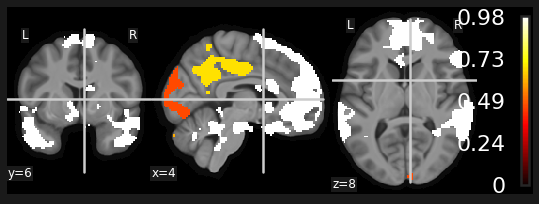

In [25]:
# visualize p values
plotting.plot_stat_map('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_reward/con0007_p05_clustere_corrp_tstat1.nii.gz',
                      bg_img = anat_mean,
#                       threshold = 0
                      )

p = nib.load('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_reward/con0007_p05_clustere_corrp_tstat1.nii.gz')

p_data = p.get_data()
np.max(p_data)

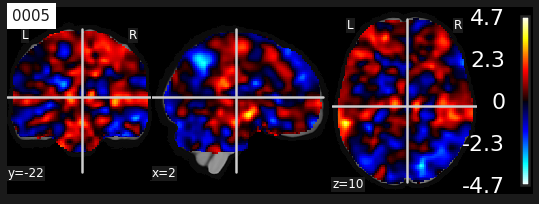

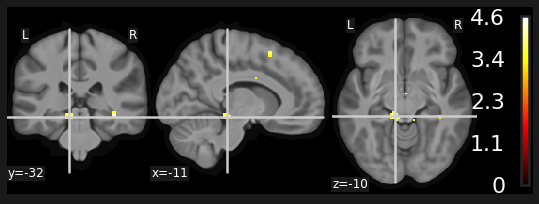

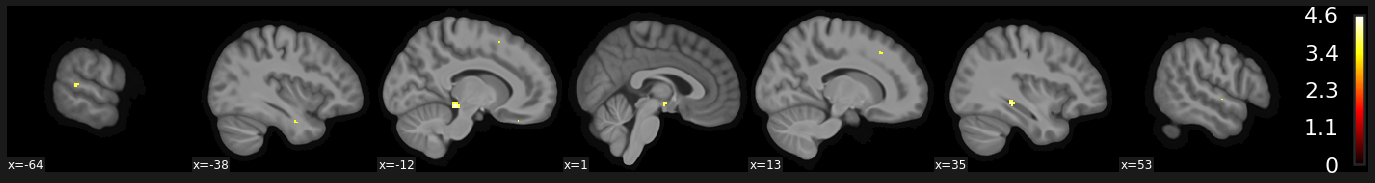

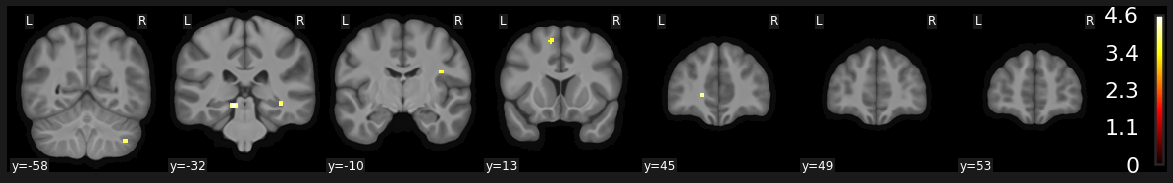

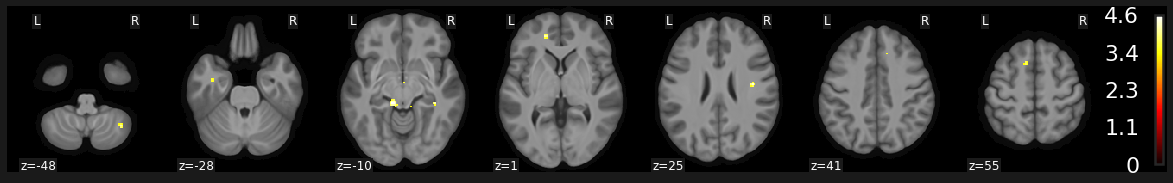

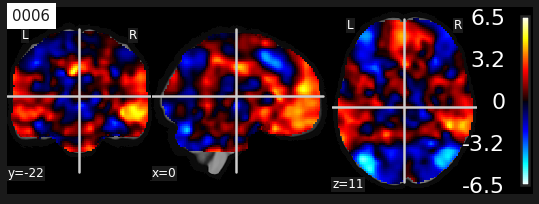

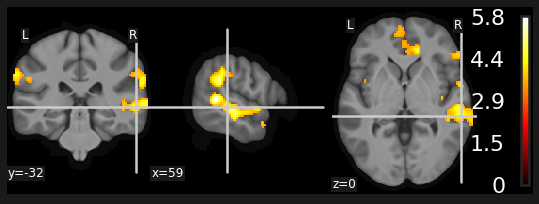

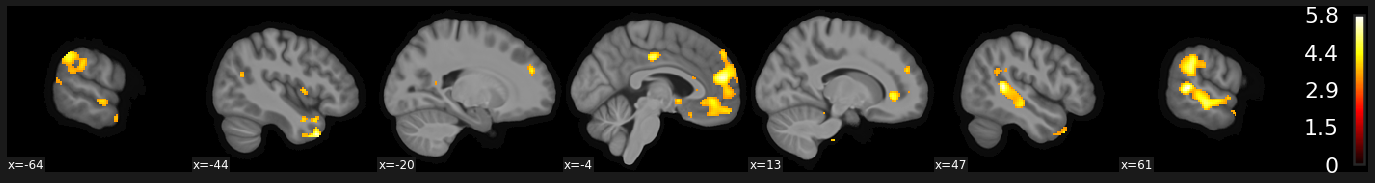

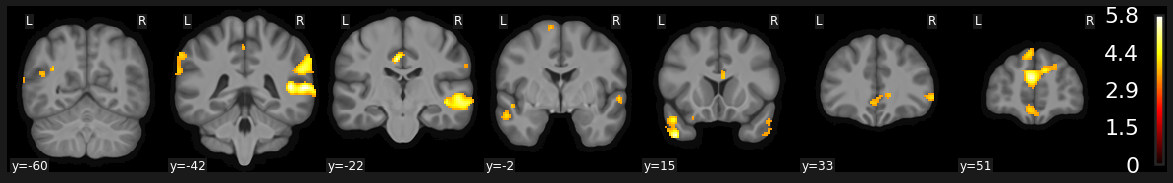

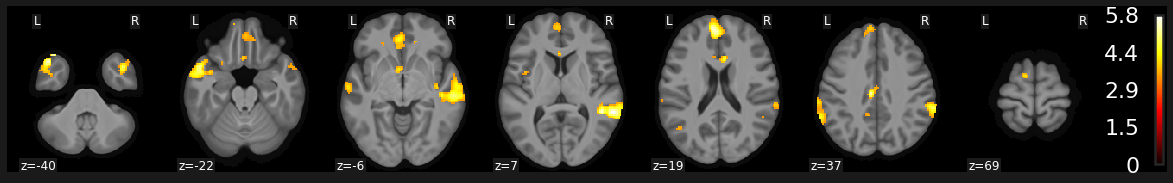

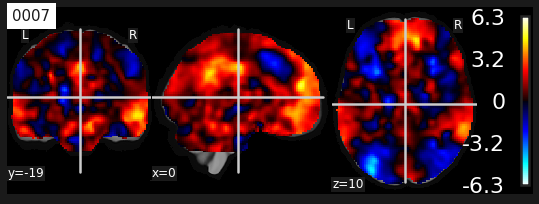

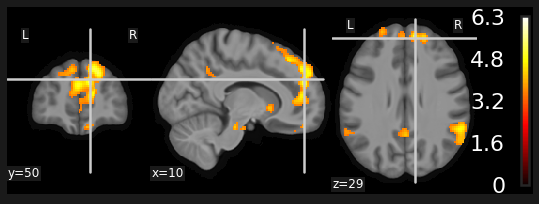

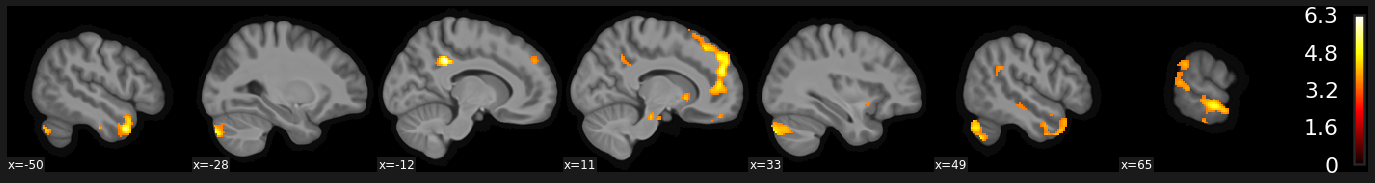

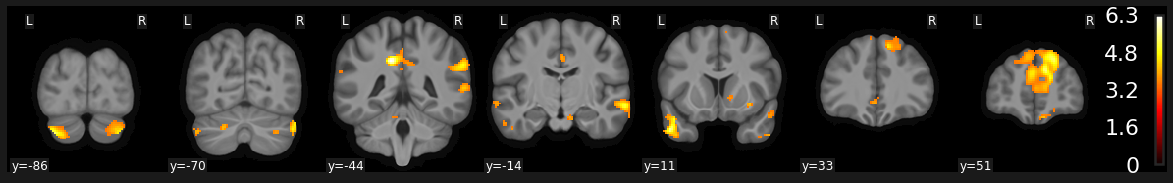

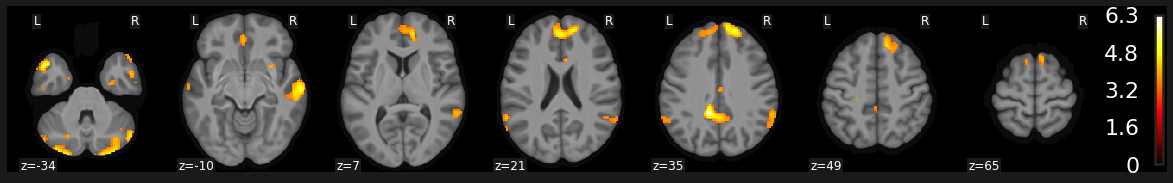

In [32]:
# visualize thresholded t values
con_ids = ['0005', '0006', '0007']

for con_id in con_ids:
    
    t_plot = nib.load('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_reward/con%s_p001_tstat1.nii.gz' %con_id)
    p = nib.load('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_reward/con%s_p001_clustere_corrp_tstat1.nii.gz' %con_id)

    # thr = 0.95
    t_plot_data = t_plot.get_data()
    p_data = p.get_data()

    # threshold raw t map by p values
    p_mask = p_data == 0
    t_plot_data[p_mask] = 0    
    
    plotting.plot_stat_map('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_reward/con%s_p001_tstat1.nii.gz' %con_id,
                          bg_img = anat_mean,
                          title = con_id)

    plotting.plot_stat_map(t_plot,
                          bg_img = anat_mean)

    plotting.plot_stat_map(t_plot,
                          bg_img = anat_mean,
                           display_mode="x", 
                           colorbar=True)

    plotting.plot_stat_map(t_plot,
                          bg_img = anat_mean,
                           display_mode="y",
                           colorbar=True)

    plotting.plot_stat_map(t_plot,
                          bg_img = anat_mean,
                           display_mode="z",
                           colorbar=True)

## TFCE

Positive SV maps <a class = "anchor" id = "tfce_pos-bullet"></a>

In [ ]:
con_id = '0013'

con_all = {}

for i in sub_num:
    con_image = glob.glob('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/1stLevel/_subject_id_' + str(i) + '/con_' + con_id + '.nii')
    con_all[str(i)] = list(con_image)
# con_all
# len(con_all)

# smooth, fwhm = none
smooth_con_all = []

for k, v in con_all.items():
    smooth_con = image.smooth_img(v[0],None) #  If fwhm is None, no filtering is performed (useful when just removal of non-finite values is needed).
    print(v)
    smooth_con_all.append(smooth_con)
    
#     plotting.plot_glass_brain(smooth_con, colorbar = True)

# concatenate
con_concat = image.concat_imgs(smooth_con_all, auto_resample = True)
con_concat.to_filename(os.path.join(out_root, 'imaging', 'Sink_resp_mon_sv', 'mon_sv_glm_con%s_all_sub.nii.gz' %con_id))


cluster_thr = fsl.Randomise(in_file = os.path.join(out_root, 'imaging', 'Sink_resp_mon_sv', 'mon_sv_glm_con%s_all_sub.nii.gz' %con_id),
                            mask = '/home/rj299/scratch60/mdm_analysis/output/imaging/wb_mask_group.nii.gz',
                            base_name = os.path.join(out_root, 'imaging', 'Sink_resp_mon_sv', 'con%s' %con_id),
                            one_sample_group_mean = True,
                            tfce = True,
                            vox_p_values = True,
                            num_perm = 5000)
cluster_thr.run()

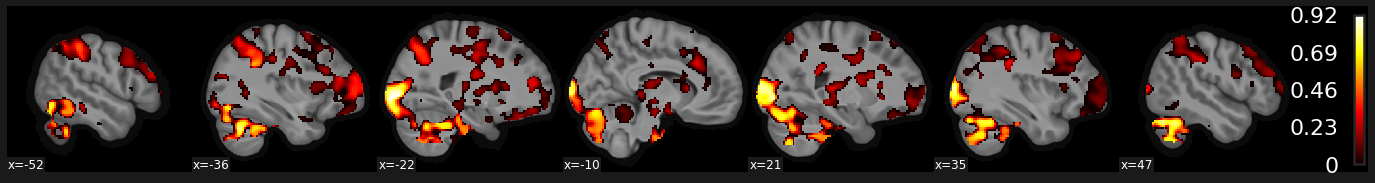

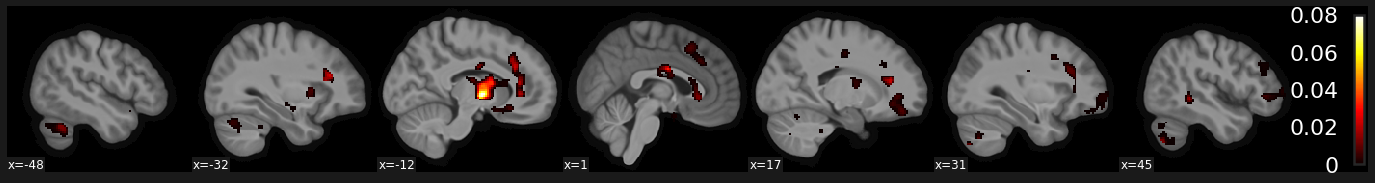

In [13]:
# p maps
con_ids = ['0012', '0013']
# con_id = '0013'

for con_id in con_ids:

    plotting.plot_stat_map('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/con%s_tfce_corrp_tstat1.nii.gz' %con_id,
                          bg_img = anat_mean,
                           display_mode = 'x',
                           colorbar=True)
    
#     plotting.plot_stat_map('/home/rj299/scratch60/mdm_analysis/output/imaging/sv_map_correction/con%s_tfce_corrp_tstat1.nii.gz' %con_id,
#                           bg_img = anat_mean,
#                            display_mode = 'x',
#                            threshold = 0.8, 
#                            colorbar=True)

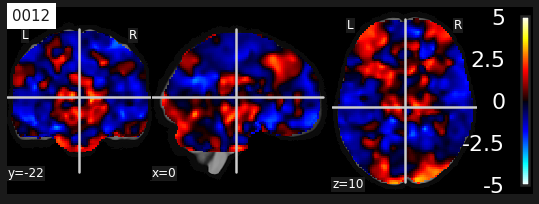

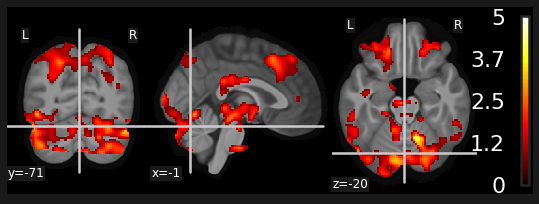

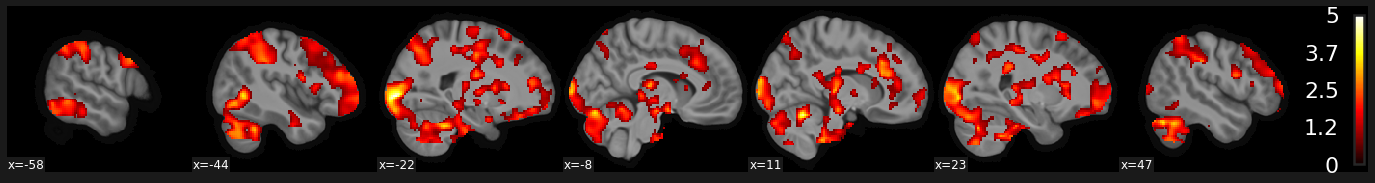

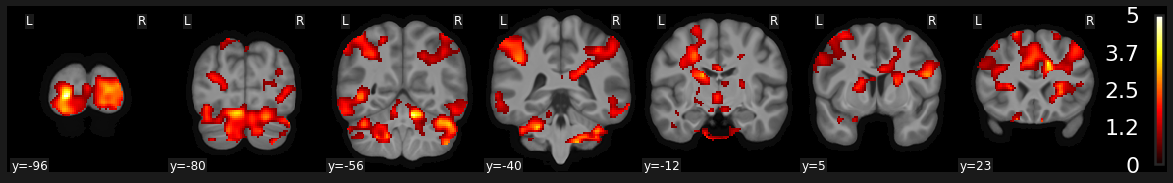

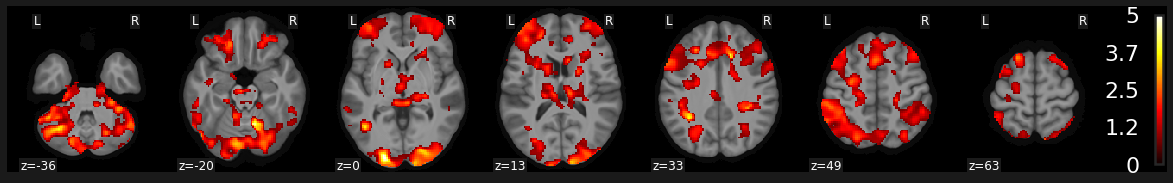

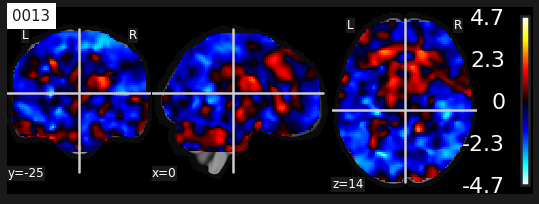

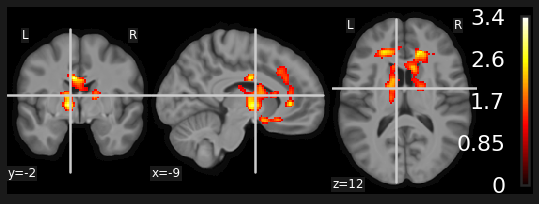

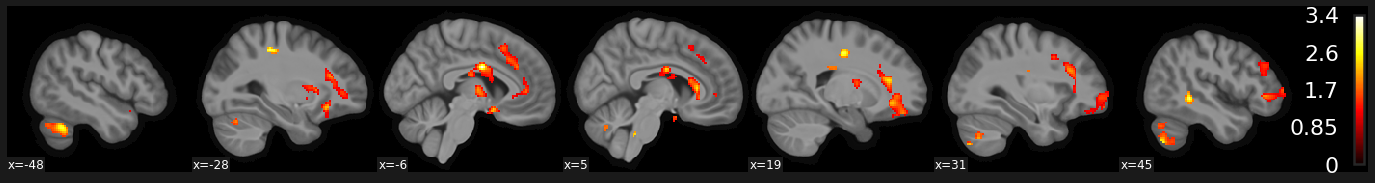

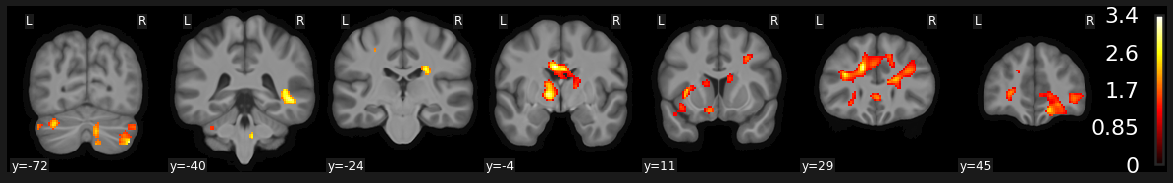

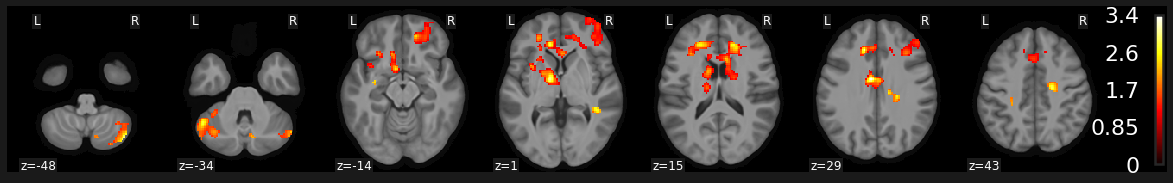

In [14]:
# visualize thresholded t values
con_ids = ['0012', '0013']


for con_id in con_ids:
    
    t_plot = nib.load('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/con%s_tstat1.nii.gz' %con_id)
    p = nib.load('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/con%s_tfce_corrp_tstat1.nii.gz' %con_id)

    # thr = 0.95
    t_plot_data = t_plot.get_data()
    p_data = p.get_data()

    # threshold raw t map by p values
    p_mask = p_data == 0
    t_plot_data[p_mask] = 0    
    
    plotting.plot_stat_map('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/con%s_tstat1.nii.gz' %con_id,
                          bg_img = anat_mean,
                          title = con_id)

    plotting.plot_stat_map(t_plot,
                          bg_img = anat_mean)

    plotting.plot_stat_map(t_plot,
                          bg_img = anat_mean,
                           display_mode="x", 
                           colorbar=True)

    plotting.plot_stat_map(t_plot,
                          bg_img = anat_mean,
                           display_mode="y",
                           colorbar=True)

    plotting.plot_stat_map(t_plot,
                          bg_img = anat_mean,
                           display_mode="z",
                           colorbar=True)

Flipped, Negative SV maps <a class = "anchor" id = "tfce_neg-bullet"></a>

In [ ]:
# flipped
con_ids = ['0012', '0013']

for con_id in con_ids:
#     con_id = '0010'

    con_all = {}

    for i in sub_num:
        con_image = glob.glob('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/1stLevel/_subject_id_' + str(i) + '/con_' + con_id + '.nii')
        con_all[str(i)] = list(con_image)
    # con_all
    # len(con_all)

    # smooth, fwhm = none
    smooth_con_all = []

    for k, v in con_all.items():
        smooth_con = image.smooth_img(v[0],None) #  If fwhm is None, no filtering is performed (useful when just removal of non-finite values is needed).
        smooth_con_all.append(smooth_con)

    #     plotting.plot_glass_brain(smooth_con, colorbar = True)

    # flip sign for negative SV maps
    smooth_con_flip_all = []

    for smooth_img in smooth_con_all:
        smooth_img_flip = image.math_img("-img", img=smooth_img)
        smooth_con_flip_all.append(smooth_img_flip)

    # concatenate    
    con_concat_flip = image.concat_imgs(smooth_con_flip_all, auto_resample = True)
    con_concat_flip.to_filename(os.path.join(out_root, 'imaging', 'Sink_resp_mon_sv', 'mon_sv_glm_con%s_flip_all_sub.nii.gz' %con_id))


    cluster_thr = fsl.Randomise(in_file = os.path.join(out_root, 'imaging', 'Sink_resp_mon_sv', 'mon_sv_glm_con%s_flip_all_sub.nii.gz' %con_id),
                                mask = '/home/rj299/scratch60/mdm_analysis/output/imaging/wb_mask_group.nii.gz',
                                base_name = os.path.join(out_root, 'imaging', 'Sink_resp_mon_sv', 'con%s_flip' %con_id),
                                one_sample_group_mean = True,
                                tfce = True,
                                vox_p_values = True,
                                num_perm = 5000)
    cluster_thr.run()

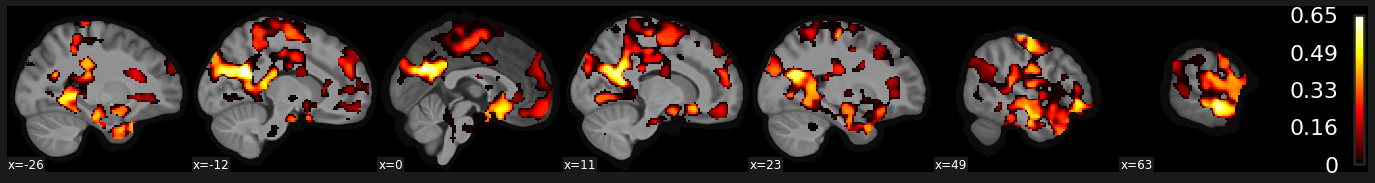

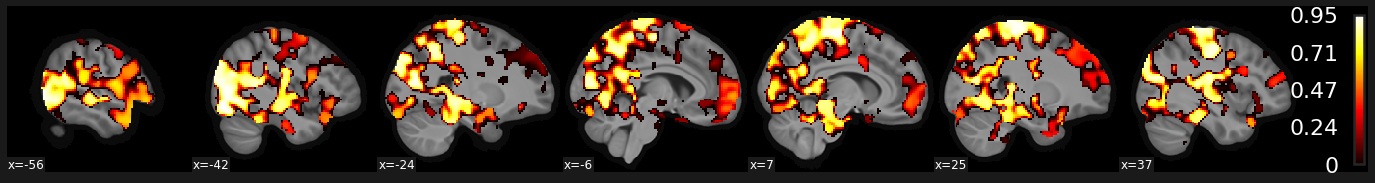

In [4]:
# p maps
con_ids = ['0012', '0013']
# con_id = '0013'

for con_id in con_ids:

    plotting.plot_stat_map('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/con%s_flip_tfce_corrp_tstat1.nii.gz' %con_id,
                          bg_img = anat_mean,
                           display_mode = 'x',
#                            threshold = 8,
                           colorbar=True)
    

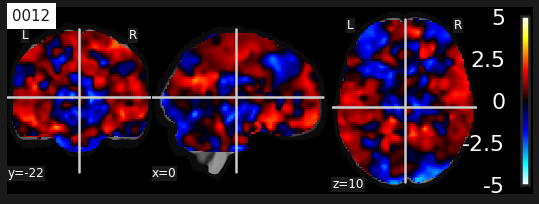

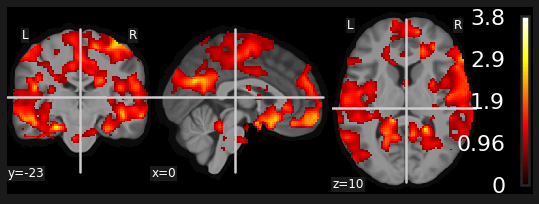

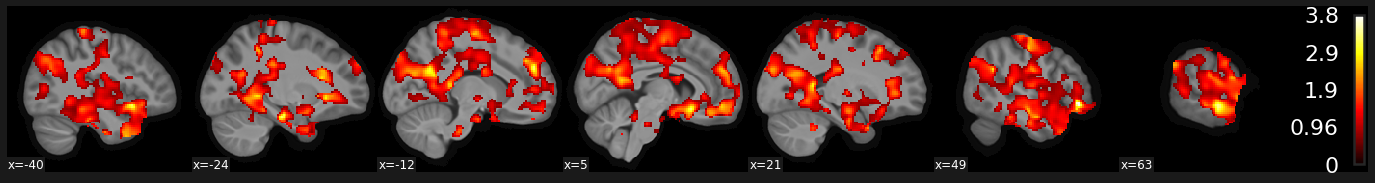

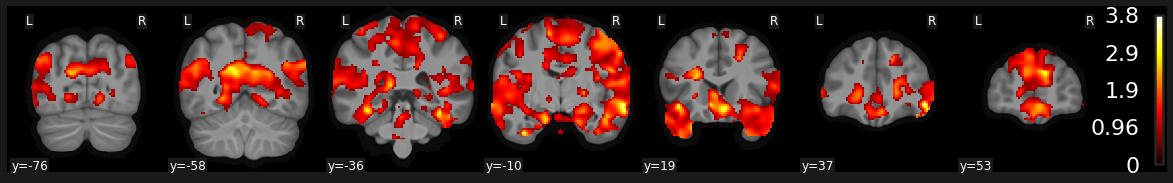

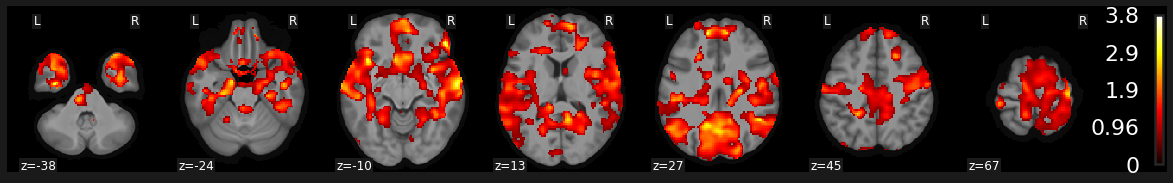

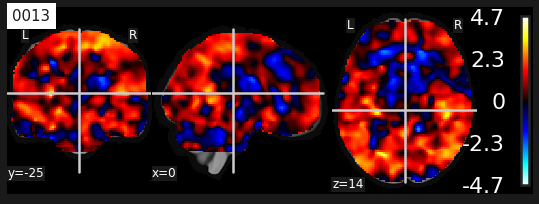

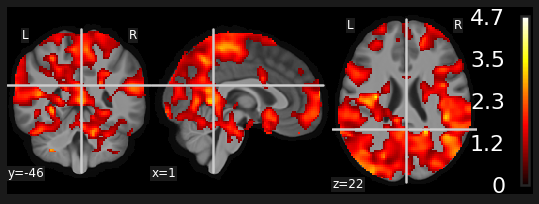

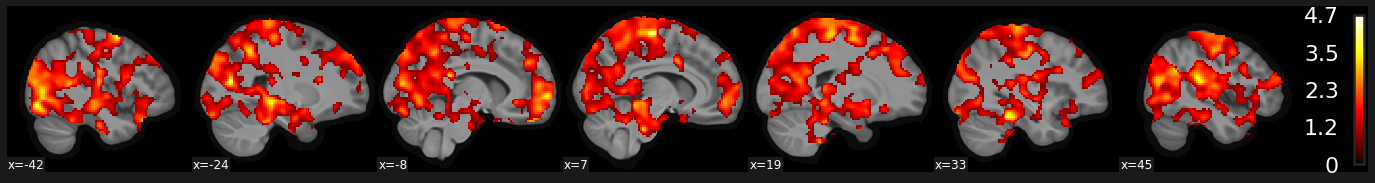

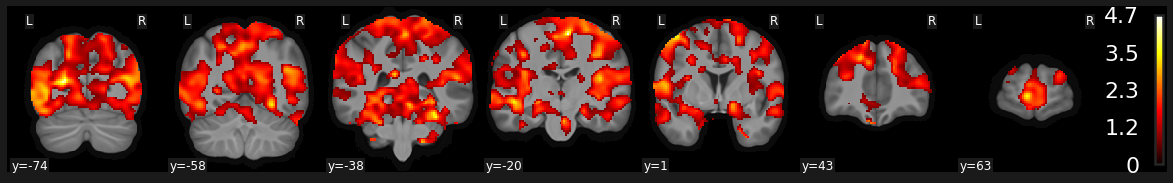

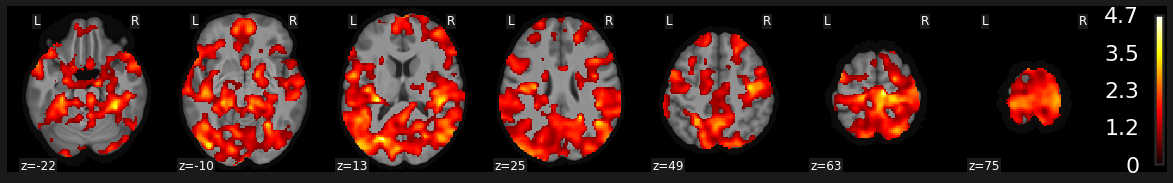

In [9]:
# visualize thresholded t values
con_ids = ['0012', '0013']


for con_id in con_ids:
    
    t_plot = nib.load('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/con%s_flip_tstat1.nii.gz' %con_id)
    p = nib.load('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/con%s_flip_tfce_corrp_tstat1.nii.gz' %con_id)

#     thr = 0.95
    t_plot_data = t_plot.get_data()
    p_data = p.get_data()

    # threshold raw t map by p values
#     p_mask = p_data < thr
    p_mask = p_data == 0
    t_plot_data[p_mask] = 0    
    
    plotting.plot_stat_map('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/con%s_flip_tstat1.nii.gz' %con_id,
                          bg_img = anat_mean,
                          title = con_id)

    plotting.plot_stat_map(t_plot,
                          bg_img = anat_mean)

    plotting.plot_stat_map(t_plot,
                          bg_img = anat_mean,
                           display_mode="x", 
                           colorbar=True)

    plotting.plot_stat_map(t_plot,
                          bg_img = anat_mean,
                           display_mode="y",
                           colorbar=True)

    plotting.plot_stat_map(t_plot,
                          bg_img = anat_mean,
                           display_mode="z",
                           colorbar=True)

## ROI analysis

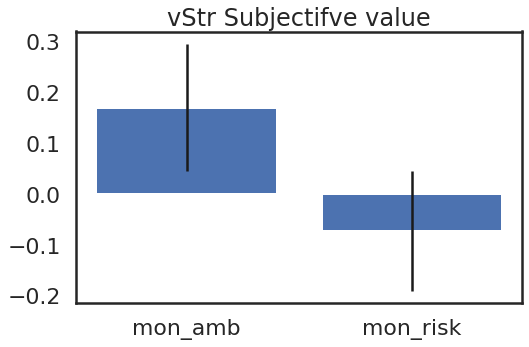

In [14]:
# vStr
# extract betas (t) from ROI

con_ids = ['0012', '0013']
con_names = ["mon_amb", "mon_risk"]

betas = []

for (idx, con_id) in enumerate(con_ids):
    
    beta = []
    for sub in sub_num:

        masker = NiftiMasker(os.path.join(out_root, "imaging", "binConjunc_PvNxDECxRECxMONxPRI_striatum.nii.gz"))

#         beta_sub = masker.fit_transform('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/1stLevel/_subject_id_%s/con_%s.nii' %(sub, con_id))
        beta_sub = masker.fit_transform('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/1stLevel/_subject_id_%s/spmT_%s.nii' %(sub, con_id))
        
        # average of beta from this ROI, a list of all participants
        beta.append(np.mean(beta_sub[0]))
    
    # a list of 
    betas.append(np.array(beta))
    
# plot
# calculate mean and se
betas_mean = np.mean(betas, axis = 1)
betas_se = stats.sem(betas, axis = 1)

fig, ax = plt.subplots(1,1,figsize = (8,5))
ax.bar(range(len(con_names)), betas_mean, yerr = betas_se, tick_label = con_names)
ax.set_title("vStr Subjectifve value")
plt.show()

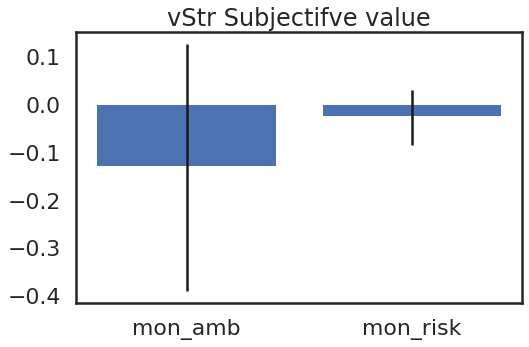

In [18]:
# vStr
# extract betas (con) from ROI

con_ids = ['0012', '0013']
con_names = ["mon_amb", "mon_risk"]

betas = []

for (idx, con_id) in enumerate(con_ids):
    
    beta = []
    for sub in sub_num:

        masker = NiftiMasker(os.path.join(out_root, "imaging", "binConjunc_PvNxDECxRECxMONxPRI_striatum.nii.gz"))

        img = nib.load('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/1stLevel/_subject_id_%s/con_%s.nii' %(sub, con_id))
        img_data = img.get_data()
        img_data[np.isnan(img_data)] =0
        beta_sub = masker.fit_transform(img)
        
#         beta_sub = masker.fit_transform('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/1stLevel/_subject_id_%s/spmT_%s.nii' %(sub, con_id))
        
    # average of beta from this ROI, a list of all participants
        beta.append(np.mean(beta_sub[0]))
    
    # a list of 
    betas.append(np.array(beta))
    
# plot
# calculate mean and se
betas_mean = np.mean(betas, axis = 1)
betas_se = stats.sem(betas, axis = 1)

fig, ax = plt.subplots(1,1,figsize = (8,5))
ax.bar(range(len(con_names)), betas_mean, yerr = betas_se, tick_label = con_names)
ax.set_title("vStr Subjectifve value")
plt.show()

fig.savefig(os.path.join(out_root,"imaging","Sink_resp_mon_sv", "Bartra_vStr_roi_mon_sv.eps"), format = 'eps')

In [19]:
#stats
for (con_idx, con_id) in enumerate(con_ids):
    print(stats.ttest_1samp(betas[con_idx], popmean = 0))

Ttest_1sampResult(statistic=-0.5093166002023068, pvalue=0.6140247718099849)
Ttest_1sampResult(statistic=-0.46219801399026017, pvalue=0.6470665886398983)


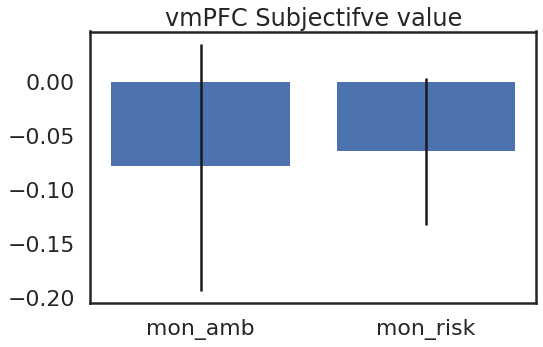

In [20]:
# vmPFC
# extract betas (t) from ROI

con_ids = ['0012', '0013']
con_names = ["mon_amb", "mon_risk"]

betas = []

for (idx, con_id) in enumerate(con_ids):
    
    beta = []
    for sub in sub_num:

        masker = NiftiMasker(os.path.join(out_root, "imaging", "binConjunc_PvNxDECxRECxMONxPRI_vmpfc.nii.gz"))
        
        img = nib.load('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/1stLevel/_subject_id_%s/con_%s.nii' %(sub, con_id))
        img_data = img.get_data()
        img_data[np.isnan(img_data)] =0
        beta_sub = masker.fit_transform(img)
        
#         beta_sub = masker.fit_transform('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_mon_sv/1stLevel/_subject_id_%s/spmT_%s.nii' %(sub, con_id))
        
        # average of beta from this ROI, a list of all participants
        beta.append(np.mean(beta_sub[0]))
    
    # a list of 
    betas.append(np.array(beta))
    
# plot
# calculate mean and se
betas_mean = np.mean(betas, axis = 1)
betas_se = stats.sem(betas, axis = 1)

fig, ax = plt.subplots(1,1,figsize = (8,5))
ax.bar(range(len(con_names)), betas_mean, yerr = betas_se, tick_label = con_names)
ax.set_title("vmPFC Subjectifve value")
plt.show()

fig.savefig(os.path.join(out_root,"imaging","Sink_resp_mon_sv", "Bartra_vmPFC_roi_mon_sv.eps"), format = 'eps')

In [21]:
#stats
for (con_idx, con_id) in enumerate(con_ids):
    print(stats.ttest_1samp(betas[con_idx], popmean = 0))

Ttest_1sampResult(statistic=-0.6998553921738916, pvalue=0.48907454493429636)
Ttest_1sampResult(statistic=-0.9600525135150698, pvalue=0.34422717561225324)
